# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


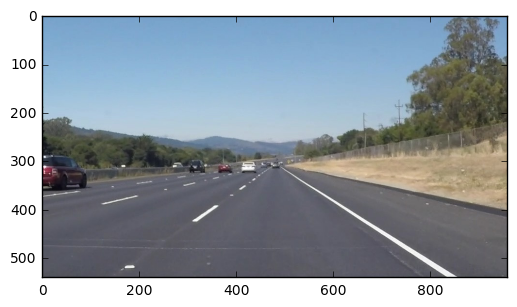

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [27]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    # classify into 'left' and 'right' lane markers
    slope_left = 0
    intercept_left = 0
    num_left = 0
    slope_right = 0
    intercept_right = 0
    num_right = 0
    for line in lines:
        for x1, y1, x2, y2 in line:
            m = (y2 - y1)/(x2 - x1)
            if m < 0:
                num_left += 1
                intercept_left += y2 - m * x2
                slope_left += m
            else:
                num_right += 1
                intercept_right += y2 - m * x2
                slope_right += m
                
    if num_left > 0 and num_right > 0:
        
        # compute 'average' line slope and intercept
        slope_left = slope_left/num_left
        slope_right = slope_right/num_right
        intercept_left = intercept_left/num_left
        intercept_right = intercept_right/num_right

        print('Left Lane average slope:', slope_left, ', intercept: ', intercept_left, ' n:', num_left)
        print('Right Lane average slope:', slope_right, ', intercept: ', intercept_right, ' n:', num_right)

        # compute vanishing point for lanes
        (sy, sx, nc) = img.shape
        x_top = (intercept_left - intercept_right)/(slope_right - slope_left)
        y_top = slope_left * x_top + intercept_left
        top = (int(x_top), int(y_top))
        
        # compute bottom coordinates for both lanes in the image
        # and draw lines
        left_lane_bottom = (int((sy-intercept_left)/slope_left), sy)
        print('Left Lane (', top, ')->(', left_lane_bottom,')')   
        right_lane_bottom = (int((sy-intercept_right)/slope_right), sy)
        print('Right Lane (', top, ')->(', right_lane_bottom,')')   

        cv2.line(img, top, left_lane_bottom, color, thickness)
        cv2.line(img, top, right_lane_bottom, color, thickness)


        #for line in lines:
        #    for x1,y1,x2,y2 in line:
        #        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [18]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg']

run your solution on all test_images and make copies into the test_images directory).

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Left Lane average slope: -0.744892093182 , intercept:  665.332602071  n: 6
Left Lane ( (477, 309) )->( (168, 540) )
Right Lane average slope: 0.582905659486 , intercept:  31.0565693728  n: 7
Right Lane ( (477, 309) )->( (873, 540) )


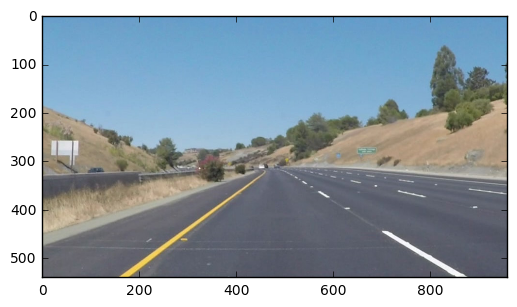

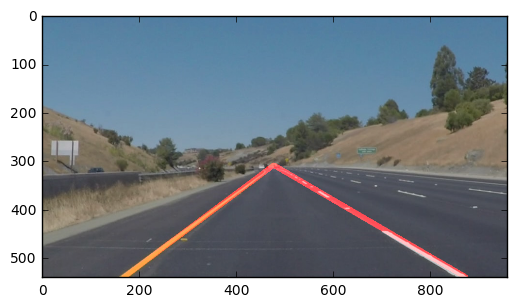

In [19]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def lane_detector(img):
    '''
    My lane detection pipeline. Takes a single image as input and returns an image
    with lane markings highlighted
    '''   
    # convert to grayscale
    gray = grayscale(img)

    # smooth the image
    kernel_size = 5
    blurred_gray = gaussian_blur(gray, kernel_size)

    # find edges
    canny_low_threshold = 50
    canny_high_threshold = 150
    edges = canny(blurred_gray, canny_low_threshold, canny_high_threshold)

    # mask out all edges not directly in front of us
    imshape = img.shape
    bottom_left = (20,imshape[0]-50)
    top_left = (imshape[1]/2-10, imshape[0]/2+50)
    top_right = (imshape[1]/2+10, imshape[0]/2+50)
    bottom_right = (imshape[1]-20,imshape[0]-50)
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    roi = region_of_interest(edges, vertices)

    # extract lane markings
    rho = 1
    theta = np.pi/180.
    threshold = 15
    min_line_len = 40
    max_line_gap = 20
    lines = hough_lines(roi, rho, theta, threshold, min_line_len, max_line_gap)

    # create composite image with detected lanes
    final = weighted_img(lines, img, α=0.8, β=1., λ=0.)
    return final

# load an image
image = mpimg.imread('test_images/solidYellowCurve2.jpg')
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.figure(1)
plt.imshow(image)

# apply the processing pipeline
final = lane_detector(image)

# show result
plt.figure(2)
plt.imshow(final, cmap='gray')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [21]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    result = lane_detector(image)
    
    return result

Let's try the one with the solid white lane on the right first ...

In [28]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Left Lane average slope: -0.716571218165 , intercept:  648.13612238  n: 8
Right Lane average slope: 0.614741840842 , intercept:  10.3070049552  n: 9
Left Lane ( (479, 304) )->( (150, 540) )
Right Lane ( (479, 304) )->( (861, 540) )
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4




  0%|          | 0/222 [00:00<?, ?it/s]

  3%|▎         | 7/222 [00:00<00:03, 60.83it/s]

Left Lane average slope: -0.716571218165 , intercept:  648.13612238  n: 8
Right Lane average slope: 0.614741840842 , intercept:  10.3070049552  n: 9
Left Lane ( (479, 304) )->( (150, 540) )
Right Lane ( (479, 304) )->( (861, 540) )
Left Lane average slope: -0.749196998889 , intercept:  659.906957075  n: 8
Right Lane average slope: 0.613230636002 , intercept:  11.5214922811  n: 6
Left Lane ( (475, 303) )->( (160, 540) )
Right Lane ( (475, 303) )->( (861, 540) )
Left Lane average slope: -0.748510233013 , intercept:  661.649723445  n: 5
Right Lane average slope: 0.61618578017 , intercept:  9.89811745658  n: 5
Left Lane ( (477, 304) )->( (162, 540) )
Right Lane ( (477, 304) )->( (860, 540) )
Left Lane average slope: -0.711677534842 , intercept:  646.577257384  n: 5
Right Lane average slope: 0.613746478537 , intercept:  10.9585814191  n: 6
Left Lane ( (479, 305) )->( (149, 540) )
Right Lane ( (479, 305) )->( (861, 540) )
Left Lane average slope: -0.706623093682 , intercept:  643.800348584  

Left Lane average slope: -0.717136508418 , intercept:  651.739329105  n: 9
Right Lane average slope: 0.623348030661 , intercept:  9.71987763145  n: 6
Left Lane ( (478, 308) )->( (155, 540) )
Right Lane ( (478, 308) )->( (850, 540) )
Left Lane average slope: -0.706300701832 , intercept:  648.570636812  n: 7
Right Lane average slope: 0.634746269275 , intercept:  4.35448971865  n: 6
Left Lane ( (480, 309) )->( (153, 540) )
Right Lane ( (480, 309) )->( (843, 540) )




  5%|▌         | 12/222 [00:00<00:03, 55.91it/s]

  8%|▊         | 17/222 [00:00<00:03, 52.40it/s]

Left Lane average slope: -0.701947499435 , intercept:  644.541274028  n: 9
Right Lane average slope: 0.637334111694 , intercept:  2.14854440817  n: 6
Left Lane ( (479, 307) )->( (148, 540) )
Right Lane ( (479, 307) )->( (843, 540) )
Left Lane average slope: -0.710260102256 , intercept:  645.751144647  n: 7
Right Lane average slope: 0.640150157202 , intercept:  0.361666436914  n: 6
Left Lane ( (477, 306) )->( (148, 540) )
Right Lane ( (477, 306) )->( (842, 540) )
Left Lane average slope: -0.723495353476 , intercept:  649.926544787  n: 4
Right Lane average slope: 0.640441760616 , intercept:  -2.4136042951  n: 7
Left Lane ( (478, 303) )->( (151, 540) )
Right Lane ( (478, 303) )->( (846, 540) )
Left Lane average slope: -0.689302787548 , intercept:  635.366814998  n: 4
Right Lane average slope: 0.647406139912 , intercept:  -8.826318162  n: 6
Left Lane ( (481, 303) )->( (138, 540) )
Right Lane ( (481, 303) )->( (847, 540) )
Left Lane average slope: -0.699879625002 , intercept:  638.229557687

Left Lane average slope: -0.671031210505 , intercept:  631.271340745  n: 4
Right Lane average slope: 0.640501213916 , intercept:  -1.12736836608  n: 6
Left Lane ( (482, 307) )->( (136, 540) )
Right Lane ( (482, 307) )->( (844, 540) )
Left Lane average slope: -0.709339351134 , intercept:  648.03322494  n: 7
Right Lane average slope: 0.640623012031 , intercept:  -0.759898757657  n: 5
Left Lane ( (480, 307) )->( (152, 540) )
Right Lane ( (480, 307) )->( (844, 540) )




 10%|▉         | 22/222 [00:00<00:04, 48.82it/s]

 12%|█▏        | 27/222 [00:00<00:04, 47.51it/s]

Left Lane average slope: -0.690682012404 , intercept:  640.573354551  n: 7
Right Lane average slope: 0.639974678057 , intercept:  -0.281223383909  n: 5
Left Lane ( (481, 307) )->( (145, 540) )
Right Lane ( (481, 307) )->( (844, 540) )
Left Lane average slope: -0.671666456634 , intercept:  633.088445481  n: 7
Right Lane average slope: 0.640593727628 , intercept:  -0.832028572976  n: 5
Left Lane ( (483, 308) )->( (138, 540) )
Right Lane ( (483, 308) )->( (844, 540) )
Left Lane average slope: -0.686508568022 , intercept:  638.05036787  n: 8
Right Lane average slope: 0.655490069661 , intercept:  -10.1074648203  n: 7
Left Lane ( (482, 306) )->( (142, 540) )
Right Lane ( (482, 306) )->( (839, 540) )
Left Lane average slope: -0.712107848024 , intercept:  648.057671512  n: 10
Right Lane average slope: 0.641429666044 , intercept:  -2.45408453922  n: 5
Left Lane ( (480, 305) )->( (151, 540) )
Right Lane ( (480, 305) )->( (845, 540) )
Left Lane average slope: -0.710409519882 , intercept:  646.157



 14%|█▍        | 32/222 [00:00<00:04, 45.61it/s]

 18%|█▊        | 39/222 [00:00<00:03, 49.83it/s]

Left Lane average slope: -0.705556514361 , intercept:  644.494371575  n: 4
Right Lane average slope: 0.635495335788 , intercept:  0.102384273194  n: 6
Left Lane ( (480, 305) )->( (148, 540) )
Right Lane ( (480, 305) )->( (849, 540) )
Left Lane average slope: -0.708074534161 , intercept:  644.439958592  n: 3
Right Lane average slope: 0.629448348565 , intercept:  3.24425709903  n: 7
Left Lane ( (479, 304) )->( (147, 540) )
Right Lane ( (479, 304) )->( (852, 540) )
Left Lane average slope: -0.708951824575 , intercept:  645.552676146  n: 7
Right Lane average slope: 0.636811453345 , intercept:  -1.09706805023  n: 6
Left Lane ( (480, 304) )->( (148, 540) )
Right Lane ( (480, 304) )->( (849, 540) )
Left Lane average slope: -0.732723938103 , intercept:  655.143946256  n: 6
Right Lane average slope: 0.636391785883 , intercept:  -0.3742969792  n: 4
Left Lane ( (478, 304) )->( (157, 540) )
Right Lane ( (478, 304) )->( (849, 540) )
Left Lane average slope: -0.72406241628 , intercept:  653.64930454



 20%|█▉        | 44/222 [00:00<00:03, 45.88it/s]

Left Lane average slope: -0.755105547374 , intercept:  662.672631321  n: 3
Right Lane average slope: 0.649512699445 , intercept:  -9.80824508422  n: 7
Left Lane ( (478, 301) )->( (162, 540) )
Right Lane ( (478, 301) )->( (846, 540) )
Left Lane average slope: -0.697234592336 , intercept:  638.974874924  n: 3
Right Lane average slope: 0.656380759837 , intercept:  -14.7616478345  n: 6
Left Lane ( (482, 302) )->( (141, 540) )
Right Lane ( (482, 302) )->( (845, 540) )
Left Lane average slope: -0.722818353859 , intercept:  648.255166474  n: 6
Right Lane average slope: 0.659640573495 , intercept:  -16.6973761734  n: 6
Left Lane ( (480, 300) )->( (149, 540) )
Right Lane ( (480, 300) )->( (843, 540) )
Left Lane average slope: -0.70892320282 , intercept:  643.073496185  n: 7
Right Lane average slope: 0.640681970389 , intercept:  -4.2553819004  n: 6
Left Lane ( (479, 303) )->( (145, 540) )
Right Lane ( (479, 303) )->( (849, 540) )
Left Lane average slope: -0.729932523843 , intercept:  651.5084867



 22%|██▏       | 49/222 [00:01<00:05, 33.81it/s]

 24%|██▍       | 54/222 [00:01<00:04, 36.95it/s]

Left Lane average slope: -0.729018111518 , intercept:  651.019842287  n: 6
Right Lane average slope: 0.646181364411 , intercept:  -7.33178520432  n: 5
Left Lane ( (478, 302) )->( (152, 540) )
Right Lane ( (478, 302) )->( (847, 540) )
Left Lane average slope: -0.698828284374 , intercept:  639.230825428  n: 8
Right Lane average slope: 0.639996313491 , intercept:  -3.88728767408  n: 7
Left Lane ( (480, 303) )->( (141, 540) )
Right Lane ( (480, 303) )->( (849, 540) )
Left Lane average slope: -0.697321768691 , intercept:  637.723692612  n: 7
Right Lane average slope: 0.650311890637 , intercept:  -10.4404969866  n: 6
Left Lane ( (480, 302) )->( (140, 540) )
Right Lane ( (480, 302) )->( (846, 540) )
Left Lane average slope: -0.714495775178 , intercept:  643.093817809  n: 8
Right Lane average slope: 0.650492585218 , intercept:  -8.97191600332  n: 4
Left Lane ( (477, 301) )->( (144, 540) )
Right Lane ( (477, 301) )->( (843, 540) )
Left Lane average slope: -0.703934215637 , intercept:  638.74996



 27%|██▋       | 59/222 [00:01<00:04, 38.05it/s]

 29%|██▉       | 64/222 [00:01<00:03, 40.74it/s]

Left Lane average slope: -0.659555420944 , intercept:  623.399260091  n: 6
Right Lane average slope: 0.638476661127 , intercept:  0.576522271593  n: 6
Left Lane ( (479, 306) )->( (126, 540) )
Right Lane ( (479, 306) )->( (844, 540) )
Left Lane average slope: -0.68532452548 , intercept:  635.617116619  n: 7
Right Lane average slope: 0.64517857731 , intercept:  -2.80428697652  n: 6
Left Lane ( (479, 306) )->( (139, 540) )
Right Lane ( (479, 306) )->( (841, 540) )
Left Lane average slope: -0.693421932897 , intercept:  637.605986469  n: 8
Right Lane average slope: 0.6552739682 , intercept:  -8.82020940858  n: 8
Left Lane ( (479, 305) )->( (140, 540) )
Right Lane ( (479, 305) )->( (837, 540) )
Left Lane average slope: -0.687345688221 , intercept:  634.789665508  n: 9
Right Lane average slope: 0.660066339676 , intercept:  -11.5438017992  n: 7
Left Lane ( (479, 305) )->( (137, 540) )
Right Lane ( (479, 305) )->( (835, 540) )
Left Lane average slope: -0.690192852788 , intercept:  635.7156277  

Left Lane average slope: -0.655934608915 , intercept:  622.100005257  n: 3
Right Lane average slope: 0.644028707574 , intercept:  -0.845547142334  n: 8
Left Lane ( (479, 307) )->( (125, 540) )
Right Lane ( (479, 307) )->( (839, 540) )
Left Lane average slope: -0.689021346898 , intercept:  634.225465849  n: 5
Right Lane average slope: 0.645321439222 , intercept:  -2.7924060006  n: 5
Left Lane ( (477, 305) )->( (136, 540) )
Right Lane ( (477, 305) )->( (841, 540) )




 31%|███       | 69/222 [00:02<00:08, 17.74it/s]

Left Lane average slope: -0.703440199092 , intercept:  639.218372127  n: 3
Right Lane average slope: 0.64541920886 , intercept:  -2.63010278563  n: 7
Left Lane ( (475, 304) )->( (141, 540) )
Right Lane ( (475, 304) )->( (840, 540) )
Left Lane average slope: -0.696076237104 , intercept:  636.533552486  n: 5
Right Lane average slope: 0.658069309666 , intercept:  -10.2444825619  n: 7
Left Lane ( (477, 304) )->( (138, 540) )
Right Lane ( (477, 304) )->( (836, 540) )
Left Lane average slope: -0.682283108354 , intercept:  631.724252708  n: 5
Right Lane average slope: 0.658322790191 , intercept:  -10.2323910097  n: 5
Left Lane ( (478, 305) )->( (134, 540) )
Right Lane ( (478, 305) )->( (835, 540) )




 33%|███▎      | 73/222 [00:02<00:08, 18.43it/s]

Left Lane average slope: -0.679744149125 , intercept:  630.986827011  n: 7
Right Lane average slope: 0.656048818697 , intercept:  -9.34402428197  n: 6
Left Lane ( (479, 305) )->( (133, 540) )
Right Lane ( (479, 305) )->( (837, 540) )
Left Lane average slope: -0.663800466183 , intercept:  623.651160712  n: 8
Right Lane average slope: 0.657909491666 , intercept:  -11.028463861  n: 6
Left Lane ( (480, 304) )->( (126, 540) )
Right Lane ( (480, 304) )->( (837, 540) )
Left Lane average slope: -0.656649319369 , intercept:  621.008022946  n: 7
Right Lane average slope: 0.658271451468 , intercept:  -9.88238606964  n: 5
Left Lane ( (479, 305) )->( (123, 540) )
Right Lane ( (479, 305) )->( (835, 540) )
Left Lane average slope: -0.664122114883 , intercept:  624.264617049  n: 8
Right Lane average slope: 0.658313980324 , intercept:  -9.72181045598  n: 5
Left Lane ( (479, 305) )->( (126, 540) )
Right Lane ( (479, 305) )->( (835, 540) )
Left Lane average slope: -0.661067826621 , intercept:  624.607897



 34%|███▍      | 76/222 [00:02<00:07, 18.35it/s]

Left Lane average slope: -0.679099439932 , intercept:  629.006119951  n: 3
Right Lane average slope: 0.662376909774 , intercept:  -11.3288949564  n: 6
Left Lane ( (477, 304) )->( (131, 540) )
Right Lane ( (477, 304) )->( (832, 540) )
Left Lane average slope: -0.63926953727 , intercept:  612.806699743  n: 4
Right Lane average slope: 0.666991430671 , intercept:  -13.1533595422  n: 5
Left Lane ( (479, 306) )->( (113, 540) )
Right Lane ( (479, 306) )->( (829, 540) )
Left Lane average slope: -0.626136363636 , intercept:  608.011363636  n: 2
Right Lane average slope: 0.681124970302 , intercept:  -21.7238251366  n: 5
Left Lane ( (481, 306) )->( (108, 540) )
Right Lane ( (481, 306) )->( (824, 540) )
Left Lane average slope: -0.692988019732 , intercept:  635.10243129  n: 3
Right Lane average slope: 0.681780954098 , intercept:  -20.9121143932  n: 5
Left Lane ( (477, 304) )->( (137, 540) )
Right Lane ( (477, 304) )->( (822, 540) )




 36%|███▌      | 79/222 [00:02<00:08, 16.97it/s]

 37%|███▋      | 82/222 [00:02<00:08, 16.95it/s]

Left Lane average slope: -0.666719895641 , intercept:  623.736769826  n: 5
Right Lane average slope: 0.676104290777 , intercept:  -18.3074907067  n: 8
Left Lane ( (478, 304) )->( (125, 540) )
Right Lane ( (478, 304) )->( (825, 540) )
Left Lane average slope: -0.655655150949 , intercept:  618.749038282  n: 5
Right Lane average slope: 0.676328580207 , intercept:  -18.3283503608  n: 4
Left Lane ( (478, 305) )->( (120, 540) )
Right Lane ( (478, 305) )->( (825, 540) )
Left Lane average slope: -0.652884697457 , intercept:  618.003300798  n: 7
Right Lane average slope: 0.672373529599 , intercept:  -16.3384655339  n: 5
Left Lane ( (478, 305) )->( (119, 540) )
Right Lane ( (478, 305) )->( (827, 540) )
Left Lane average slope: -0.660783297876 , intercept:  620.807577633  n: 7
Right Lane average slope: 0.68292115009 , intercept:  -21.9861977057  n: 6
Left Lane ( (478, 304) )->( (122, 540) )
Right Lane ( (478, 304) )->( (822, 540) )
Left Lane average slope: -0.640332880512 , intercept:  613.575857



 38%|███▊      | 85/222 [00:03<00:08, 16.53it/s]

 39%|███▉      | 87/222 [00:03<00:08, 16.84it/s]

Left Lane average slope: -0.658312492888 , intercept:  620.32696423  n: 9
Right Lane average slope: 0.685329733257 , intercept:  -23.6401442841  n: 6
Left Lane ( (479, 304) )->( (122, 540) )
Right Lane ( (479, 304) )->( (822, 540) )
Left Lane average slope: -0.658954278925 , intercept:  621.569360754  n: 7
Right Lane average slope: 0.677887973963 , intercept:  -19.5284894188  n: 7
Left Lane ( (479, 305) )->( (123, 540) )
Right Lane ( (479, 305) )->( (825, 540) )
Left Lane average slope: -0.65595715788 , intercept:  620.533467342  n: 8
Right Lane average slope: 0.684678359498 , intercept:  -23.9651370279  n: 5
Left Lane ( (480, 305) )->( (122, 540) )
Right Lane ( (480, 305) )->( (823, 540) )
Left Lane average slope: -0.655905276685 , intercept:  620.369615395  n: 6
Right Lane average slope: 0.66099315966 , intercept:  -9.91901405899  n: 6
Left Lane ( (478, 306) )->( (122, 540) )
Right Lane ( (478, 306) )->( (831, 540) )




 41%|████      | 90/222 [00:03<00:06, 18.91it/s]

Left Lane average slope: -0.628068958377 , intercept:  608.716101094  n: 4
Right Lane average slope: 0.66701449705 , intercept:  -12.7634837326  n: 7
Left Lane ( (479, 307) )->( (109, 540) )
Right Lane ( (479, 307) )->( (828, 540) )
Left Lane average slope: -0.617850632681 , intercept:  605.34870516  n: 4
Right Lane average slope: 0.682088819194 , intercept:  -21.8327099419  n: 7
Left Lane ( (482, 307) )->( (105, 540) )
Right Lane ( (482, 307) )->( (823, 540) )
Left Lane average slope: -0.637585153864 , intercept:  612.518017383  n: 3
Right Lane average slope: 0.700250109429 , intercept:  -31.3858148022  n: 7
Left Lane ( (481, 305) )->( (113, 540) )
Right Lane ( (481, 305) )->( (815, 540) )
Left Lane average slope: -0.668610505093 , intercept:  626.449956992  n: 6
Right Lane average slope: 0.702508192401 , intercept:  -33.1056819196  n: 7
Left Lane ( (481, 304) )->( (129, 540) )
Right Lane ( (481, 304) )->( (815, 540) )
Left Lane average slope: -0.653671849944 , intercept:  621.4663659



 42%|████▏     | 93/222 [00:03<00:08, 15.13it/s]

 43%|████▎     | 95/222 [00:03<00:08, 14.97it/s]

Left Lane average slope: -0.648814683706 , intercept:  619.740841587  n: 5
Right Lane average slope: 0.702216948775 , intercept:  -33.5685722492  n: 7
Left Lane ( (483, 305) )->( (122, 540) )
Right Lane ( (483, 305) )->( (816, 540) )
Left Lane average slope: -0.690961533784 , intercept:  635.217696237  n: 7
Right Lane average slope: 0.695274317616 , intercept:  -31.6760430632  n: 8
Left Lane ( (481, 302) )->( (137, 540) )
Right Lane ( (481, 302) )->( (822, 540) )
Left Lane average slope: -0.681339997971 , intercept:  630.914542814  n: 6
Right Lane average slope: 0.706722816012 , intercept:  -39.4076424228  n: 7
Left Lane ( (482, 301) )->( (133, 540) )
Right Lane ( (482, 301) )->( (819, 540) )




 44%|████▎     | 97/222 [00:03<00:08, 15.42it/s]

Left Lane average slope: -0.685886699153 , intercept:  632.17909164  n: 8
Right Lane average slope: 0.706756671464 , intercept:  -41.416994153  n: 7
Left Lane ( (483, 300) )->( (134, 540) )
Right Lane ( (483, 300) )->( (822, 540) )
Left Lane average slope: -0.666000316002 , intercept:  624.221649858  n: 9
Right Lane average slope: 0.706877678306 , intercept:  -40.7147906148  n: 7
Left Lane ( (484, 301) )->( (126, 540) )
Right Lane ( (484, 301) )->( (821, 540) )
Left Lane average slope: -0.678164855598 , intercept:  631.208067015  n: 7
Right Lane average slope: 0.693295369401 , intercept:  -33.6148063885  n: 6
Left Lane ( (484, 302) )->( (134, 540) )
Right Lane ( (484, 302) )->( (827, 540) )




 45%|████▍     | 99/222 [00:04<00:09, 13.36it/s]

 45%|████▌     | 101/222 [00:04<00:08, 13.66it/s]

Left Lane average slope: -0.689374045199 , intercept:  632.495054039  n: 5
Right Lane average slope: 0.692229703463 , intercept:  -33.324062323  n: 6
Left Lane ( (481, 300) )->( (134, 540) )
Right Lane ( (481, 300) )->( (828, 540) )
Left Lane average slope: -0.675525645041 , intercept:  629.34589488  n: 4
Right Lane average slope: 0.695228637931 , intercept:  -34.3791981453  n: 5
Left Lane ( (484, 302) )->( (132, 540) )
Right Lane ( (484, 302) )->( (826, 540) )
Left Lane average slope: -0.697954609134 , intercept:  639.58314654  n: 4
Right Lane average slope: 0.703473595628 , intercept:  -37.6436560664  n: 5
Left Lane ( (483, 302) )->( (142, 540) )
Right Lane ( (483, 302) )->( (821, 540) )
Left Lane average slope: -0.6703281635 , intercept:  628.262452746  n: 4
Right Lane average slope: 0.692531658082 , intercept:  -30.2419806947  n: 5
Left Lane ( (483, 304) )->( (131, 540) )
Right Lane ( (483, 304) )->( (823, 540) )




 47%|████▋     | 104/222 [00:04<00:07, 15.13it/s]

Left Lane average slope: -0.684972718499 , intercept:  636.731344572  n: 8
Right Lane average slope: 0.688759272078 , intercept:  -27.9465960458  n: 8
Left Lane ( (483, 305) )->( (141, 540) )
Right Lane ( (483, 305) )->( (824, 540) )
Left Lane average slope: -0.697218404128 , intercept:  640.593242402  n: 6
Right Lane average slope: 0.704286400168 , intercept:  -37.7892318129  n: 6
Left Lane ( (484, 303) )->( (144, 540) )
Right Lane ( (484, 303) )->( (820, 540) )
Left Lane average slope: -0.671832011953 , intercept:  631.021984778  n: 8
Right Lane average slope: 0.686668248505 , intercept:  -27.896744171  n: 5
Left Lane ( (485, 305) )->( (135, 540) )
Right Lane ( (485, 305) )->( (827, 540) )
Left Lane average slope: -0.655107761317 , intercept:  623.99435827  n: 8
Right Lane average slope: 0.685550919864 , intercept:  -28.2710845551  n: 8
Left Lane ( (486, 305) )->( (128, 540) )
Right Lane ( (486, 305) )->( (828, 540) )




 48%|████▊     | 107/222 [00:04<00:07, 15.86it/s]

 50%|████▉     | 110/222 [00:04<00:06, 17.79it/s]

Left Lane average slope: -0.69791189005 , intercept:  639.541833078  n: 7
Right Lane average slope: 0.685973619065 , intercept:  -29.7259708873  n: 7
Left Lane ( (483, 302) )->( (142, 540) )
Right Lane ( (483, 302) )->( (830, 540) )
Left Lane average slope: -0.666814172978 , intercept:  628.331379247  n: 8
Right Lane average slope: 0.685988452678 , intercept:  -28.3047739638  n: 7
Left Lane ( (485, 304) )->( (132, 540) )
Right Lane ( (485, 304) )->( (828, 540) )
Left Lane average slope: -0.678787285342 , intercept:  632.729620009  n: 9
Right Lane average slope: 0.691082991371 , intercept:  -31.7775378639  n: 5
Left Lane ( (485, 303) )->( (136, 540) )
Right Lane ( (485, 303) )->( (827, 540) )
Left Lane average slope: -0.67156462585 , intercept:  629.343945578  n: 7
Right Lane average slope: 0.689866766893 , intercept:  -30.5314799604  n: 5
Left Lane ( (484, 303) )->( (133, 540) )
Right Lane ( (484, 303) )->( (827, 540) )
Left Lane average slope: -0.69991709454 , intercept:  641.70741862



 51%|█████▏    | 114/222 [00:04<00:05, 21.16it/s]

Left Lane average slope: -0.681835622276 , intercept:  633.349538975  n: 6
Right Lane average slope: 0.66726870265 , intercept:  -20.593636962  n: 6
Left Lane ( (484, 302) )->( (136, 540) )
Right Lane ( (484, 302) )->( (840, 540) )
Left Lane average slope: -0.6840394265 , intercept:  634.07172285  n: 5
Right Lane average slope: 0.68191879727 , intercept:  -29.5166424355  n: 8
Left Lane ( (485, 301) )->( (137, 540) )
Right Lane ( (485, 301) )->( (835, 540) )




 53%|█████▎    | 117/222 [00:05<00:06, 15.04it/s]

Left Lane average slope: -0.654708297284 , intercept:  622.494513421  n: 8
Right Lane average slope: 0.668343197867 , intercept:  -21.134515114  n: 7
Left Lane ( (486, 303) )->( (126, 540) )
Right Lane ( (486, 303) )->( (839, 540) )
Left Lane average slope: -0.664912110373 , intercept:  626.291071332  n: 9
Right Lane average slope: 0.676700398152 , intercept:  -24.8418269438  n: 6
Left Lane ( (485, 303) )->( (129, 540) )
Right Lane ( (485, 303) )->( (834, 540) )
Left Lane average slope: -0.685504662394 , intercept:  633.478932742  n: 6
Right Lane average slope: 0.672886549428 , intercept:  -23.510320575  n: 9
Left Lane ( (483, 301) )->( (136, 540) )
Right Lane ( (483, 301) )->( (837, 540) )
Left Lane average slope: -0.67024297014 , intercept:  628.803009368  n: 8
Right Lane average slope: 0.643013009575 , intercept:  -4.32110657074  n: 8
Left Lane ( (482, 305) )->( (132, 540) )
Right Lane ( (482, 305) )->( (846, 540) )




 54%|█████▍    | 120/222 [00:05<00:07, 14.48it/s]

 55%|█████▌    | 123/222 [00:05<00:06, 15.99it/s]

Left Lane average slope: -0.689234580279 , intercept:  637.354734892  n: 8
Right Lane average slope: 0.653116963421 , intercept:  -11.5273863662  n: 6
Left Lane ( (483, 304) )->( (141, 540) )
Right Lane ( (483, 304) )->( (844, 540) )
Left Lane average slope: -0.695860453817 , intercept:  640.217531671  n: 9
Right Lane average slope: 0.660612884104 , intercept:  -15.6701280599  n: 6
Left Lane ( (483, 303) )->( (144, 540) )
Right Lane ( (483, 303) )->( (841, 540) )
Left Lane average slope: -0.679740959106 , intercept:  635.0652462  n: 8
Right Lane average slope: 0.64939260308 , intercept:  -7.60460487349  n: 6
Left Lane ( (483, 306) )->( (139, 540) )
Right Lane ( (483, 306) )->( (843, 540) )
Left Lane average slope: -0.684778563669 , intercept:  637.711579034  n: 6
Right Lane average slope: 0.650156025634 , intercept:  -8.25251515797  n: 6
Left Lane ( (483, 306) )->( (142, 540) )
Right Lane ( (483, 306) )->( (843, 540) )




 56%|█████▋    | 125/222 [00:05<00:06, 15.60it/s]

 58%|█████▊    | 128/222 [00:05<00:05, 17.73it/s]

Left Lane average slope: -0.687307247242 , intercept:  637.833461617  n: 3
Right Lane average slope: 0.639984095411 , intercept:  -3.17956703362  n: 6
Left Lane ( (482, 305) )->( (142, 540) )
Right Lane ( (482, 305) )->( (848, 540) )
Left Lane average slope: -0.668888100453 , intercept:  630.40579696  n: 4
Right Lane average slope: 0.639250279539 , intercept:  -1.8540050281  n: 5
Left Lane ( (483, 307) )->( (135, 540) )
Right Lane ( (483, 307) )->( (847, 540) )
Left Lane average slope: -0.710560990365 , intercept:  648.67890753  n: 4
Right Lane average slope: 0.638301925791 , intercept:  -2.83280569014  n: 6
Left Lane ( (483, 305) )->( (152, 540) )
Right Lane ( (483, 305) )->( (850, 540) )
Left Lane average slope: -0.691504329004 , intercept:  640.92202381  n: 3
Right Lane average slope: 0.637853660454 , intercept:  -2.38376229628  n: 6
Left Lane ( (483, 306) )->( (145, 540) )
Right Lane ( (483, 306) )->( (850, 540) )
Left Lane average slope: -0.70139331605 , intercept:  645.843737161 



 59%|█████▉    | 131/222 [00:05<00:05, 16.78it/s]

Left Lane average slope: -0.704870717287 , intercept:  646.794620263  n: 9
Right Lane average slope: 0.637258260413 , intercept:  -1.62876740897  n: 4
Left Lane ( (483, 306) )->( (151, 540) )
Right Lane ( (483, 306) )->( (849, 540) )
Left Lane average slope: -0.692673839534 , intercept:  643.354059876  n: 9
Right Lane average slope: 0.635259042056 , intercept:  -1.69174564752  n: 6
Left Lane ( (485, 306) )->( (149, 540) )
Right Lane ( (485, 306) )->( (852, 540) )
Left Lane average slope: -0.682716221417 , intercept:  639.540256475  n: 7
Right Lane average slope: 0.634103170858 , intercept:  0.185776291902  n: 5
Left Lane ( (485, 308) )->( (145, 540) )
Right Lane ( (485, 308) )->( (851, 540) )




 60%|██████    | 134/222 [00:06<00:04, 18.50it/s]

Left Lane average slope: -0.718997935473 , intercept:  654.423717938  n: 11
Right Lane average slope: 0.641860714605 , intercept:  -3.11437568107  n: 6
Left Lane ( (483, 307) )->( (159, 540) )
Right Lane ( (483, 307) )->( (846, 540) )
Left Lane average slope: -0.710936141732 , intercept:  648.341133466  n: 8
Right Lane average slope: 0.640016745945 , intercept:  -3.71068875622  n: 5
Left Lane ( (482, 305) )->( (152, 540) )
Right Lane ( (482, 305) )->( (849, 540) )
Left Lane average slope: -0.722871442779 , intercept:  651.687260331  n: 9
Right Lane average slope: 0.636745359491 , intercept:  -3.9074427159  n: 7
Left Lane ( (482, 303) )->( (154, 540) )
Right Lane ( (482, 303) )->( (854, 540) )
Left Lane average slope: -0.705160378233 , intercept:  644.982967461  n: 4
Right Lane average slope: 0.639075543676 , intercept:  -5.42622925751  n: 5
Left Lane ( (483, 303) )->( (148, 540) )
Right Lane ( (483, 303) )->( (853, 540) )




 62%|██████▏   | 137/222 [00:06<00:05, 15.93it/s]

 63%|██████▎   | 139/222 [00:06<00:05, 15.37it/s]

Left Lane average slope: -0.708830412493 , intercept:  645.903358919  n: 4
Right Lane average slope: 0.624629489657 , intercept:  2.46555167161  n: 8
Left Lane ( (482, 303) )->( (149, 540) )
Right Lane ( (482, 303) )->( (860, 540) )
Left Lane average slope: -0.724311037252 , intercept:  652.691628583  n: 3
Right Lane average slope: 0.636004872275 , intercept:  -4.0927564757  n: 4
Left Lane ( (482, 302) )->( (155, 540) )
Right Lane ( (482, 302) )->( (855, 540) )
Left Lane average slope: -0.725182221694 , intercept:  653.562901494  n: 5
Right Lane average slope: 0.633858360788 , intercept:  -2.18664257685  n: 7
Left Lane ( (482, 303) )->( (156, 540) )
Right Lane ( (482, 303) )->( (855, 540) )
Left Lane average slope: -0.697880116959 , intercept:  643.384722222  n: 4
Right Lane average slope: 0.636588013094 , intercept:  -2.03199351535  n: 6
Left Lane ( (483, 305) )->( (148, 540) )
Right Lane ( (483, 305) )->( (851, 540) )




 64%|██████▎   | 141/222 [00:06<00:05, 16.16it/s]

 65%|██████▌   | 145/222 [00:06<00:04, 18.97it/s]

Left Lane average slope: -0.73029967239 , intercept:  658.239718704  n: 7
Right Lane average slope: 0.641006451526 , intercept:  -3.27524032203  n: 6
Left Lane ( (482, 305) )->( (161, 540) )
Right Lane ( (482, 305) )->( (847, 540) )
Left Lane average slope: -0.704502727455 , intercept:  647.59632471  n: 7
Right Lane average slope: 0.639100533287 , intercept:  -2.8589743677  n: 6
Left Lane ( (484, 306) )->( (152, 540) )
Right Lane ( (484, 306) )->( (849, 540) )
Left Lane average slope: -0.714917985186 , intercept:  651.656158274  n: 7
Right Lane average slope: 0.637578768229 , intercept:  -0.240619712421  n: 6
Left Lane ( (481, 307) )->( (156, 540) )
Right Lane ( (481, 307) )->( (847, 540) )
Left Lane average slope: -0.709653540081 , intercept:  649.873690841  n: 6
Right Lane average slope: 0.636517509759 , intercept:  -1.77630664678  n: 6
Left Lane ( (484, 306) )->( (154, 540) )
Right Lane ( (484, 306) )->( (851, 540) )
Left Lane average slope: -0.723770545331 , intercept:  655.9638013



 67%|██████▋   | 148/222 [00:06<00:04, 18.12it/s]

Left Lane average slope: -0.735048218504 , intercept:  658.077420868  n: 9
Right Lane average slope: 0.632776297634 , intercept:  -2.70366285534  n: 5
Left Lane ( (483, 302) )->( (160, 540) )
Right Lane ( (483, 302) )->( (857, 540) )
Left Lane average slope: -0.724665599284 , intercept:  654.578879761  n: 4
Right Lane average slope: 0.633721447936 , intercept:  -4.37169099529  n: 7
Left Lane ( (485, 303) )->( (158, 540) )
Right Lane ( (485, 303) )->( (859, 540) )
Left Lane average slope: -0.716176470588 , intercept:  652.207352941  n: 4
Right Lane average slope: 0.629536347335 , intercept:  -1.12932122216  n: 7
Left Lane ( (485, 304) )->( (156, 540) )
Right Lane ( (485, 304) )->( (859, 540) )
Left Lane average slope: -0.723023838871 , intercept:  654.943356019  n: 6
Right Lane average slope: 0.630371813657 , intercept:  -2.09711195684  n: 7
Left Lane ( (485, 303) )->( (158, 540) )
Right Lane ( (485, 303) )->( (859, 540) )
Left Lane average slope: -0.728501566602 , intercept:  658.13150



 68%|██████▊   | 151/222 [00:07<00:04, 14.30it/s]

 69%|██████▉   | 153/222 [00:07<00:04, 15.45it/s]

Left Lane average slope: -0.71423461308 , intercept:  652.538023348  n: 5
Right Lane average slope: 0.627707258546 , intercept:  -0.50937699712  n: 6
Left Lane ( (486, 304) )->( (157, 540) )
Right Lane ( (486, 304) )->( (861, 540) )
Left Lane average slope: -0.749635122411 , intercept:  667.228719397  n: 4
Right Lane average slope: 0.630636537754 , intercept:  -1.84838521997  n: 6
Left Lane ( (484, 303) )->( (169, 540) )
Right Lane ( (484, 303) )->( (859, 540) )
Left Lane average slope: -0.753785862171 , intercept:  667.234486838  n: 5
Right Lane average slope: 0.632256853915 , intercept:  -4.23999867316  n: 5
Left Lane ( (484, 302) )->( (168, 540) )
Right Lane ( (484, 302) )->( (860, 540) )
Left Lane average slope: -0.757207905809 , intercept:  668.510257543  n: 7
Right Lane average slope: 0.630088540875 , intercept:  -3.23551968679  n: 5
Left Lane ( (484, 301) )->( (169, 540) )
Right Lane ( (484, 301) )->( (862, 540) )




 70%|██████▉   | 155/222 [00:07<00:04, 13.50it/s]

 71%|███████   | 157/222 [00:07<00:05, 12.80it/s]

Left Lane average slope: -0.756363341092 , intercept:  667.013987982  n: 7
Right Lane average slope: 0.633491747956 , intercept:  -6.71168279338  n: 5
Left Lane ( (484, 300) )->( (167, 540) )
Right Lane ( (484, 300) )->( (863, 540) )
Left Lane average slope: -0.736680530119 , intercept:  660.595469996  n: 10
Right Lane average slope: 0.620384612093 , intercept:  2.43278876396  n: 6
Left Lane ( (484, 303) )->( (163, 540) )
Right Lane ( (484, 303) )->( (866, 540) )
Left Lane average slope: -0.740800992309 , intercept:  662.643011421  n: 8
Right Lane average slope: 0.622271764579 , intercept:  1.11848118205  n: 6
Left Lane ( (485, 303) )->( (165, 540) )
Right Lane ( (485, 303) )->( (865, 540) )




 72%|███████▏  | 159/222 [00:07<00:04, 13.65it/s]

Left Lane average slope: -0.722005879703 , intercept:  655.607485721  n: 10
Right Lane average slope: 0.615448520552 , intercept:  5.26274534744  n: 5
Left Lane ( (486, 304) )->( (160, 540) )
Right Lane ( (486, 304) )->( (868, 540) )
Left Lane average slope: -0.724210661519 , intercept:  656.05212281  n: 5
Right Lane average slope: 0.614199250253 , intercept:  5.77448810938  n: 5
Left Lane ( (485, 304) )->( (160, 540) )
Right Lane ( (485, 304) )->( (869, 540) )
Left Lane average slope: -0.75458426674 , intercept:  669.992396987  n: 5
Right Lane average slope: 0.606601757061 , intercept:  9.34301932546  n: 7
Left Lane ( (485, 303) )->( (172, 540) )
Right Lane ( (485, 303) )->( (874, 540) )




 73%|███████▎  | 161/222 [00:07<00:04, 13.60it/s]

 74%|███████▍  | 164/222 [00:08<00:03, 15.46it/s]

Left Lane average slope: -0.723412340348 , intercept:  658.493624386  n: 6
Right Lane average slope: 0.593240240305 , intercept:  19.6238579464  n: 7
Left Lane ( (485, 307) )->( (163, 540) )
Right Lane ( (485, 307) )->( (877, 540) )
Left Lane average slope: -0.736450161442 , intercept:  663.834272461  n: 5
Right Lane average slope: 0.591930135214 , intercept:  19.3769952027  n: 6
Left Lane ( (485, 306) )->( (168, 540) )
Right Lane ( (485, 306) )->( (879, 540) )
Left Lane average slope: -0.742043876263 , intercept:  665.686254735  n: 4
Right Lane average slope: 0.589164263781 , intercept:  21.128055145  n: 8
Left Lane ( (484, 306) )->( (169, 540) )
Right Lane ( (484, 306) )->( (880, 540) )
Left Lane average slope: -0.73720752608 , intercept:  664.041222057  n: 5
Right Lane average slope: 0.596803102238 , intercept:  17.9138722117  n: 6
Left Lane ( (484, 306) )->( (168, 540) )
Right Lane ( (484, 306) )->( (874, 540) )
Left Lane average slope: -0.753295298604 , intercept:  671.615841736  



 75%|███████▌  | 167/222 [00:08<00:03, 17.34it/s]

 77%|███████▋  | 171/222 [00:08<00:02, 20.52it/s]

Left Lane average slope: -0.771777791157 , intercept:  680.5431712  n: 9
Right Lane average slope: 0.586359673814 , intercept:  24.0566157447  n: 5
Left Lane ( (483, 307) )->( (182, 540) )
Right Lane ( (483, 307) )->( (879, 540) )
Left Lane average slope: -0.739318572 , intercept:  667.91163037  n: 8
Right Lane average slope: 0.588900124294 , intercept:  23.1355201087  n: 6
Left Lane ( (485, 309) )->( (173, 540) )
Right Lane ( (485, 309) )->( (877, 540) )
Left Lane average slope: -0.767806619636 , intercept:  677.654271595  n: 9
Right Lane average slope: 0.58925592274 , intercept:  23.1966200645  n: 4
Left Lane ( (482, 307) )->( (179, 540) )
Right Lane ( (482, 307) )->( (877, 540) )
Left Lane average slope: -0.760516937037 , intercept:  674.327796726  n: 7
Right Lane average slope: 0.590104665528 , intercept:  22.7415235921  n: 4
Left Lane ( (482, 307) )->( (176, 540) )
Right Lane ( (482, 307) )->( (876, 540) )
Left Lane average slope: -0.765741266477 , intercept:  675.760010536  n: 9




 78%|███████▊  | 174/222 [00:08<00:02, 20.64it/s]

Left Lane average slope: -0.789705963284 , intercept:  686.670180316  n: 5
Right Lane average slope: 0.593307168175 , intercept:  21.0725303083  n: 5
Left Lane ( (481, 306) )->( (185, 540) )
Right Lane ( (481, 306) )->( (874, 540) )
Left Lane average slope: -0.836917476794 , intercept:  706.001664117  n: 4
Right Lane average slope: 0.588839408576 , intercept:  23.1966296199  n: 6
Left Lane ( (478, 305) )->( (198, 540) )
Right Lane ( (478, 305) )->( (877, 540) )
Left Lane average slope: -0.786664773633 , intercept:  685.434910729  n: 5
Right Lane average slope: 0.592342554107 , intercept:  21.0225101518  n: 6
Left Lane ( (481, 306) )->( (184, 540) )
Right Lane ( (481, 306) )->( (876, 540) )
Left Lane average slope: -0.769001492956 , intercept:  678.178634978  n: 7
Right Lane average slope: 0.592259415954 , intercept:  20.9733312778  n: 6
Left Lane ( (482, 306) )->( (179, 540) )
Right Lane ( (482, 306) )->( (876, 540) )
Left Lane average slope: -0.778521027964 , intercept:  682.216631498



 80%|███████▉  | 177/222 [00:08<00:02, 19.47it/s]

 81%|████████  | 180/222 [00:08<00:02, 18.02it/s]

Left Lane average slope: -0.821329770075 , intercept:  700.533418178  n: 7
Right Lane average slope: 0.601474639218 , intercept:  14.8504075266  n: 6
Left Lane ( (481, 304) )->( (195, 540) )
Right Lane ( (481, 304) )->( (873, 540) )
Left Lane average slope: -0.797879024595 , intercept:  689.885701178  n: 9
Right Lane average slope: 0.592070928266 , intercept:  20.3097771446  n: 6
Left Lane ( (481, 305) )->( (187, 540) )
Right Lane ( (481, 305) )->( (877, 540) )
Left Lane average slope: -0.777810291451 , intercept:  681.61833045  n: 9
Right Lane average slope: 0.602450336778 , intercept:  12.6363496028  n: 7
Left Lane ( (484, 304) )->( (182, 540) )
Right Lane ( (484, 304) )->( (875, 540) )
Left Lane average slope: -0.807526038214 , intercept:  694.319829259  n: 8
Right Lane average slope: 0.598955678938 , intercept:  14.4645802778  n: 6
Left Lane ( (483, 303) )->( (191, 540) )
Right Lane ( (483, 303) )->( (877, 540) )




 82%|████████▏ | 183/222 [00:08<00:02, 16.85it/s]

Left Lane average slope: -0.791648165682 , intercept:  687.184276093  n: 7
Right Lane average slope: 0.598254581356 , intercept:  14.8778925249  n: 6
Left Lane ( (483, 304) )->( (185, 540) )
Right Lane ( (483, 304) )->( (877, 540) )
Left Lane average slope: -0.788898668169 , intercept:  684.741907642  n: 7
Right Lane average slope: 0.599292756208 , intercept:  14.2327591582  n: 7
Left Lane ( (483, 303) )->( (183, 540) )
Right Lane ( (483, 303) )->( (877, 540) )
Left Lane average slope: -0.800661075036 , intercept:  690.651034452  n: 5
Right Lane average slope: 0.604516090795 , intercept:  9.02621257141  n: 7
Left Lane ( (485, 302) )->( (188, 540) )
Right Lane ( (485, 302) )->( (878, 540) )




 83%|████████▎ | 185/222 [00:09<00:02, 14.42it/s]

Left Lane average slope: -0.80494767547 , intercept:  691.986753363  n: 5
Right Lane average slope: 0.600105248197 , intercept:  13.0947317885  n: 6
Left Lane ( (483, 303) )->( (188, 540) )
Right Lane ( (483, 303) )->( (878, 540) )
Left Lane average slope: -0.791101776805 , intercept:  686.162283114  n: 6
Right Lane average slope: 0.589914872966 , intercept:  19.5187002577  n: 8
Left Lane ( (482, 304) )->( (184, 540) )
Right Lane ( (482, 304) )->( (882, 540) )
Left Lane average slope: -0.783647998717 , intercept:  682.551326464  n: 6
Right Lane average slope: 0.59001518065 , intercept:  20.024072742  n: 7
Left Lane ( (482, 304) )->( (181, 540) )
Right Lane ( (482, 304) )->( (881, 540) )
Left Lane average slope: -0.76390678188 , intercept:  673.443058392  n: 3
Right Lane average slope: 0.587166078662 , intercept:  20.1987781433  n: 5
Left Lane ( (483, 304) )->( (174, 540) )
Right Lane ( (483, 304) )->( (885, 540) )




 85%|████████▍ | 188/222 [00:09<00:02, 15.18it/s]

 86%|████████▌ | 190/222 [00:09<00:01, 16.12it/s]

Left Lane average slope: -0.796101190476 , intercept:  685.602202381  n: 4
Right Lane average slope: 0.586588900557 , intercept:  18.5128706529  n: 7
Left Lane ( (482, 301) )->( (182, 540) )
Right Lane ( (482, 301) )->( (889, 540) )
Left Lane average slope: -0.777956765614 , intercept:  676.137139976  n: 5
Right Lane average slope: 0.588177934972 , intercept:  15.3399562268  n: 7
Left Lane ( (483, 299) )->( (174, 540) )
Right Lane ( (483, 299) )->( (892, 540) )
Left Lane average slope: -0.791885972841 , intercept:  682.964310879  n: 6
Right Lane average slope: 0.581033846263 , intercept:  20.212819909  n: 7
Left Lane ( (482, 300) )->( (180, 540) )
Right Lane ( (482, 300) )->( (894, 540) )
Left Lane average slope: -0.819330387445 , intercept:  695.628478694  n: 8
Right Lane average slope: 0.582493189565 , intercept:  20.2734598315  n: 6
Left Lane ( (481, 300) )->( (189, 540) )
Right Lane ( (481, 300) )->( (892, 540) )
Left Lane average slope: -0.771375381093 , intercept:  679.949225926 



 88%|████████▊ | 195/222 [00:09<00:01, 17.94it/s]

 89%|████████▊ | 197/222 [00:09<00:01, 17.75it/s]

Left Lane average slope: -0.764247344196 , intercept:  677.913774646  n: 8
Right Lane average slope: 0.58762802833 , intercept:  21.7733116165  n: 6
Left Lane ( (485, 306) )->( (180, 540) )
Right Lane ( (485, 306) )->( (881, 540) )
Left Lane average slope: -0.760800838371 , intercept:  675.447692582  n: 6
Right Lane average slope: 0.549559536187 , intercept:  43.6704788673  n: 8
Left Lane ( (482, 308) )->( (178, 540) )
Right Lane ( (482, 308) )->( (903, 540) )
Left Lane average slope: -0.785298062593 , intercept:  684.781259314  n: 5
Right Lane average slope: 0.581321497019 , intercept:  27.3457294792  n: 8
Left Lane ( (481, 307) )->( (184, 540) )
Right Lane ( (481, 307) )->( (881, 540) )




 90%|█████████ | 200/222 [00:09<00:01, 18.53it/s]

Left Lane average slope: -0.751246658491 , intercept:  669.363954587  n: 4
Right Lane average slope: 0.582631547503 , intercept:  24.9574158994  n: 7
Left Lane ( (483, 306) )->( (172, 540) )
Right Lane ( (483, 306) )->( (883, 540) )
Left Lane average slope: -0.78279988211 , intercept:  682.76495137  n: 5
Right Lane average slope: 0.575979819892 , intercept:  29.4308870424  n: 8
Left Lane ( (480, 306) )->( (182, 540) )
Right Lane ( (480, 306) )->( (886, 540) )
Left Lane average slope: -0.788918468652 , intercept:  685.255242758  n: 5
Right Lane average slope: 0.584610456048 , intercept:  23.4220857698  n: 8
Left Lane ( (481, 305) )->( (184, 540) )
Right Lane ( (481, 305) )->( (883, 540) )
Left Lane average slope: -0.765723237182 , intercept:  674.702635206  n: 5
Right Lane average slope: 0.584016030933 , intercept:  23.8246529841  n: 8
Left Lane ( (482, 305) )->( (175, 540) )
Right Lane ( (482, 305) )->( (883, 540) )
Left Lane average slope: -0.766936588001 , intercept:  675.351017732  



 92%|█████████▏| 204/222 [00:10<00:00, 21.82it/s]

Left Lane average slope: -0.760168711123 , intercept:  673.205513117  n: 7
Right Lane average slope: 0.575040460162 , intercept:  27.1219626334  n: 6
Left Lane ( (483, 305) )->( (175, 540) )
Right Lane ( (483, 305) )->( (891, 540) )
Left Lane average slope: -0.764865223508 , intercept:  674.04108091  n: 8
Right Lane average slope: 0.575149275314 , intercept:  26.7574495724  n: 6
Left Lane ( (483, 304) )->( (175, 540) )
Right Lane ( (483, 304) )->( (892, 540) )
Left Lane average slope: -0.780451349039 , intercept:  679.75789056  n: 6
Right Lane average slope: 0.570044895348 , intercept:  30.0213097812  n: 5
Left Lane ( (481, 304) )->( (179, 540) )
Right Lane ( (481, 304) )->( (894, 540) )




 93%|█████████▎| 207/222 [00:10<00:01, 14.74it/s]

 94%|█████████▍| 209/222 [00:10<00:00, 15.88it/s]

Left Lane average slope: -0.794890592772 , intercept:  684.867963636  n: 6
Right Lane average slope: 0.56549037757 , intercept:  31.8692692866  n: 6
Left Lane ( (480, 303) )->( (182, 540) )
Right Lane ( (480, 303) )->( (898, 540) )
Left Lane average slope: -0.76240307573 , intercept:  671.655385759  n: 4
Right Lane average slope: 0.564167431799 , intercept:  32.9900017807  n: 4
Left Lane ( (481, 304) )->( (172, 540) )
Right Lane ( (481, 304) )->( (898, 540) )
Left Lane average slope: -0.766591085067 , intercept:  673.920058072  n: 5
Right Lane average slope: 0.567322151533 , intercept:  31.9804222094  n: 5
Left Lane ( (481, 305) )->( (174, 540) )
Right Lane ( (481, 305) )->( (895, 540) )
Left Lane average slope: -0.757308243829 , intercept:  670.768506435  n: 6
Right Lane average slope: 0.563715467602 , intercept:  33.5232822174  n: 7
Left Lane ( (482, 305) )->( (172, 540) )
Right Lane ( (482, 305) )->( (898, 540) )
Left Lane average slope: -0.757657839768 , intercept:  670.869676347  



 96%|█████████▌| 213/222 [00:10<00:00, 18.93it/s]

 97%|█████████▋| 216/222 [00:10<00:00, 20.24it/s]

Left Lane average slope: -0.755702945938 , intercept:  671.687276797  n: 7
Right Lane average slope: 0.565082557915 , intercept:  35.7535165521  n: 4
Left Lane ( (481, 307) )->( (174, 540) )
Right Lane ( (481, 307) )->( (892, 540) )
Left Lane average slope: -0.79147943007 , intercept:  686.94953465  n: 7
Right Lane average slope: 0.561415183228 , intercept:  37.7299631779  n: 5
Left Lane ( (479, 307) )->( (185, 540) )
Right Lane ( (479, 307) )->( (894, 540) )
Left Lane average slope: -0.789420079973 , intercept:  685.184094581  n: 8
Right Lane average slope: 0.564119183275 , intercept:  37.2851606024  n: 4
Left Lane ( (478, 307) )->( (183, 540) )
Right Lane ( (478, 307) )->( (891, 540) )
Left Lane average slope: -0.801569548626 , intercept:  688.969305389  n: 7
Right Lane average slope: 0.559118388631 , intercept:  39.164717638  n: 4
Left Lane ( (477, 306) )->( (185, 540) )
Right Lane ( (477, 306) )->( (895, 540) )
Left Lane average slope: -0.764358104027 , intercept:  677.469961843  n



 99%|█████████▊| 219/222 [00:10<00:00, 19.65it/s]

100%|█████████▉| 221/222 [00:11<00:00, 20.09it/s]

Left Lane average slope: -0.753996853287 , intercept:  670.443293438  n: 6
Right Lane average slope: 0.565486063358 , intercept:  36.3681437624  n: 6
Left Lane ( (480, 308) )->( (173, 540) )
Right Lane ( (480, 308) )->( (890, 540) )
Left Lane average slope: -0.764952531646 , intercept:  676.270681191  n: 4
Right Lane average slope: 0.561584270821 , intercept:  38.725731039  n: 7
Left Lane ( (480, 308) )->( (178, 540) )
Right Lane ( (480, 308) )->( (892, 540) )
[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 1min 51s, sys: 3.84 s, total: 1min 55s
Wall time: 11.5 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [24]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Left Lane average slope: -0.618091847984 , intercept:  609.461276103  n: 5
Left Lane ( (487, 308) )->( (112, 540) )
Right Lane average slope: 0.672630616258 , intercept:  -19.8940769876  n: 5
Right Lane ( (487, 308) )->( (832, 540) )
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4



  1%|          | 5/682 [00:00<00:15, 43.24it/s]

Left Lane average slope: -0.618091847984 , intercept:  609.461276103  n: 5
Left Lane ( (487, 308) )->( (112, 540) )
Right Lane average slope: 0.672630616258 , intercept:  -19.8940769876  n: 5
Right Lane ( (487, 308) )->( (832, 540) )
Left Lane average slope: -0.530092359494 , intercept:  583.366970942  n: 6
Left Lane ( (503, 316) )->( (81, 540) )
Right Lane average slope: 0.677864959252 , intercept:  -24.3516741948  n: 8
Right Lane ( (503, 316) )->( (832, 540) )
Left Lane average slope: -0.639664269941 , intercept:  616.824106994  n: 10
Left Lane ( (486, 305) )->( (120, 540) )
Right Lane average slope: 0.685499299819 , intercept:  -28.2362985117  n: 8
Right Lane ( (486, 305) )->( (828, 540) )
Left Lane average slope: -0.635210962448 , intercept:  616.971950747  n: 6
Left Lane ( (487, 307) )->( (121, 540) )
Right Lane average slope: 0.680188693835 , intercept:  -24.7365103529  n: 5
Right Lane ( (487, 307) )->( (830, 540) )
Left Lane average slope: -0.637168905221 , intercept:  618.08857

Left Lane average slope: -0.633057247369 , intercept:  617.211423573  n: 8
Left Lane ( (490, 306) )->( (121, 540) )
Right Lane average slope: 0.691210630594 , intercept:  -32.0783886725  n: 4
Right Lane ( (490, 306) )->( (827, 540) )
Left Lane average slope: -0.636500690059 , intercept:  619.189530523  n: 6
Left Lane ( (488, 308) )->( (124, 540) )
Right Lane average slope: 0.64223539545 , intercept:  -5.58731316816  n: 3
Right Lane ( (488, 308) )->( (849, 540) )
Left Lane average slope: -0.649952612992 , intercept:  623.459075218  n: 6
Left Lane ( (486, 307) )->( (128, 540) )
Right Lane average slope: 0.635790291726 , intercept:  -1.59112864658  n: 6
Right Lane ( (486, 307) )->( (851, 540) )



  2%|▏         | 16/682 [00:00<00:14, 45.25it/s]

Left Lane average slope: -0.649053909742 , intercept:  624.899909082  n: 8
Left Lane ( (490, 306) )->( (130, 540) )
Right Lane average slope: 0.665436574204 , intercept:  -20.2722750051  n: 6
Right Lane ( (490, 306) )->( (841, 540) )
Left Lane average slope: -0.650353426416 , intercept:  623.977678108  n: 7
Left Lane ( (488, 306) )->( (129, 540) )
Right Lane average slope: 0.642266738051 , intercept:  -7.02170069979  n: 6
Right Lane ( (488, 306) )->( (851, 540) )
Left Lane average slope: -0.6640233906 , intercept:  629.13336401  n: 7
Left Lane ( (488, 304) )->( (134, 540) )
Right Lane average slope: 0.666631334729 , intercept:  -21.4487825637  n: 8
Right Lane ( (488, 304) )->( (842, 540) )
Left Lane average slope: -0.677934505218 , intercept:  634.776824392  n: 9
Left Lane ( (487, 304) )->( (139, 540) )
Right Lane average slope: 0.657484074095 , intercept:  -16.1512290302  n: 10
Right Lane ( (487, 304) )->( (845, 540) )
Left Lane average slope: -0.675289926601 , intercept:  634.1948134


  3%|▎         | 21/682 [00:00<00:15, 43.61it/s]

Left Lane average slope: -0.690244319956 , intercept:  638.134889812  n: 6
Left Lane ( (484, 303) )->( (142, 540) )
Right Lane average slope: 0.636775419702 , intercept:  -5.25277161863  n: 5
Right Lane ( (484, 303) )->( (856, 540) )
Left Lane average slope: -0.691973904901 , intercept:  639.100445532  n: 5
Left Lane ( (485, 303) )->( (143, 540) )
Right Lane average slope: 0.64897894994 , intercept:  -11.4939803966  n: 6
Right Lane ( (485, 303) )->( (849, 540) )
Left Lane average slope: -0.702891474555 , intercept:  643.241980514  n: 6
Left Lane ( (483, 303) )->( (146, 540) )
Right Lane average slope: 0.63940485042 , intercept:  -5.98263231926  n: 5
Right Lane ( (483, 303) )->( (853, 540) )
Left Lane average slope: -0.702544236737 , intercept:  642.836689988  n: 5
Left Lane ( (483, 303) )->( (146, 540) )
Right Lane average slope: 0.625353759021 , intercept:  1.30490154254  n: 5
Right Lane ( (483, 303) )->( (861, 540) )
Left Lane average slope: -0.683777492876 , intercept:  636.28127715


  4%|▍         | 27/682 [00:00<00:14, 43.82it/s]

Left Lane average slope: -0.719527320631 , intercept:  651.030513076  n: 7
Left Lane ( (482, 303) )->( (154, 540) )
Right Lane average slope: 0.624654590203 , intercept:  2.66968648888  n: 6
Right Lane ( (482, 303) )->( (860, 540) )
Left Lane average slope: -0.702812149596 , intercept:  644.702576211  n: 6
Left Lane ( (483, 304) )->( (148, 540) )
Right Lane average slope: 0.616807928588 , intercept:  6.4864478159  n: 5
Right Lane ( (483, 304) )->( (864, 540) )
Left Lane average slope: -0.730599005804 , intercept:  654.958662032  n: 9
Left Lane ( (484, 300) )->( (157, 540) )
Right Lane average slope: 0.650406504065 , intercept:  -14.3455284553  n: 2
Right Lane ( (484, 300) )->( (852, 540) )



  5%|▍         | 32/682 [00:00<00:14, 44.94it/s]

Left Lane average slope: -0.67859317648 , intercept:  634.145883798  n: 9
Left Lane ( (487, 303) )->( (138, 540) )
Right Lane average slope: 0.634343903153 , intercept:  -5.60886140994  n: 3
Right Lane ( (487, 303) )->( (860, 540) )
Left Lane average slope: -0.72236372458 , intercept:  651.10980368  n: 8
Left Lane ( (480, 303) )->( (153, 540) )
Right Lane average slope: 0.576411960133 , intercept:  26.8172757475  n: 2
Right Lane ( (480, 303) )->( (890, 540) )
Left Lane average slope: -0.774630444693 , intercept:  672.859850765  n: 8
Left Lane ( (480, 300) )->( (171, 540) )
Right Lane average slope: 0.619988706945 , intercept:  3.01863354037  n: 3
Right Lane ( (480, 300) )->( (866, 540) )
Left Lane average slope: -0.760801022665 , intercept:  666.391394067  n: 6
Left Lane ( (479, 301) )->( (166, 540) )
Right Lane average slope: 0.610678475726 , intercept:  8.57623525061  n: 4
Right Lane ( (479, 301) )->( (870, 540) )
Left Lane average slope: -0.766410245011 , intercept:  666.192042226  


  6%|▌         | 39/682 [00:00<00:13, 48.42it/s]

Left Lane average slope: -0.768917887183 , intercept:  666.714555025  n: 9
Left Lane ( (475, 300) )->( (164, 540) )
Right Lane average slope: 0.600661486201 , intercept:  14.8360791274  n: 4
Right Lane ( (475, 300) )->( (874, 540) )
Left Lane average slope: -0.74306467475 , intercept:  657.175336541  n: 6
Left Lane ( (478, 301) )->( (157, 540) )
Right Lane average slope: 0.59848608838 , intercept:  15.7918705315  n: 4
Right Lane ( (478, 301) )->( (875, 540) )
Left Lane average slope: -0.668464692394 , intercept:  634.401386932  n: 8
Left Lane ( (489, 306) )->( (141, 540) )
Right Lane average slope: 0.608763140609 , intercept:  8.69789324908  n: 5
Right Lane ( (489, 306) )->( (872, 540) )
Left Lane average slope: -0.719973945807 , intercept:  646.969185506  n: 6
Left Lane ( (482, 299) )->( (148, 540) )
Right Lane average slope: 0.611817653891 , intercept:  4.70557491289  n: 4
Right Lane ( (482, 299) )->( (874, 540) )



  6%|▋         | 44/682 [00:00<00:13, 46.49it/s]

Left Lane average slope: -0.746878930917 , intercept:  657.720610903  n: 10
Left Lane ( (478, 300) )->( (157, 540) )
Right Lane average slope: 0.595789135326 , intercept:  14.9344262295  n: 2
Right Lane ( (478, 300) )->( (881, 540) )
Left Lane average slope: -0.742750451988 , intercept:  655.784248761  n: 8
Left Lane ( (481, 297) )->( (155, 540) )
Right Lane average slope: 0.630119120077 , intercept:  -5.72332840623  n: 3
Right Lane ( (481, 297) )->( (866, 540) )
Left Lane average slope: -0.746027134576 , intercept:  657.043223609  n: 7
Left Lane ( (480, 298) )->( (156, 540) )
Right Lane average slope: 0.625 , intercept:  -1.5  n: 1
Right Lane ( (480, 298) )->( (866, 540) )
Left Lane average slope: -0.733559486896 , intercept:  653.311919328  n: 9
Left Lane ( (478, 302) )->( (154, 540) )
Right Lane average slope: 0.607360646116 , intercept:  11.4207451628  n: 5
Right Lane ( (478, 302) )->( (870, 540) )


Left Lane average slope: -0.739583189042 , intercept:  655.385553627  n: 10
Left Lane ( (480, 300) )->( (156, 540) )
Right Lane average slope: 0.638740981241 , intercept:  -6.57623376623  n: 4
Right Lane ( (480, 300) )->( (855, 540) )



  7%|▋         | 49/682 [00:01<00:17, 35.85it/s]

Left Lane average slope: -0.73912718622 , intercept:  655.173993806  n: 6
Left Lane ( (478, 301) )->( (155, 540) )
Right Lane average slope: 0.614262474178 , intercept:  7.71068409344  n: 5
Right Lane ( (478, 301) )->( (866, 540) )
Left Lane average slope: -0.742788395767 , intercept:  654.816704082  n: 6
Left Lane ( (476, 300) )->( (154, 540) )
Right Lane average slope: 0.610175255373 , intercept:  10.211687667  n: 4
Right Lane ( (476, 300) )->( (868, 540) )
Left Lane average slope: -0.73809270668 , intercept:  653.489624  n: 7
Left Lane ( (476, 301) )->( (153, 540) )
Right Lane average slope: 0.602758177566 , intercept:  14.239961626  n: 5
Right Lane ( (476, 301) )->( (872, 540) )
Left Lane average slope: -0.751119212541 , intercept:  658.374533965  n: 5
Left Lane ( (477, 299) )->( (157, 540) )
Right Lane average slope: 0.621312830688 , intercept:  2.99935515873  n: 4
Right Lane ( (477, 299) )->( (864, 540) )



  8%|▊         | 54/682 [00:01<00:16, 37.54it/s]

Left Lane average slope: -0.731645685405 , intercept:  651.716670408  n: 6
Left Lane ( (474, 304) )->( (152, 540) )
Right Lane average slope: 0.584748832213 , intercept:  26.5261829824  n: 5
Right Lane ( (474, 304) )->( (878, 540) )
Left Lane average slope: -0.72978460359 , intercept:  651.009306169  n: 6
Left Lane ( (476, 303) )->( (152, 540) )
Right Lane average slope: 0.599548152987 , intercept:  18.0730016796  n: 7
Right Lane ( (476, 303) )->( (870, 540) )
Left Lane average slope: -0.719667442472 , intercept:  646.88555003  n: 5
Left Lane ( (479, 301) )->( (148, 540) )
Right Lane average slope: 0.626831501832 , intercept:  0.901098901099  n: 2
Right Lane ( (479, 301) )->( (860, 540) )
Left Lane average slope: -0.608919326949 , intercept:  623.199512946  n: 6
Left Lane ( (502, 317) )->( (136, 540) )
Right Lane average slope: 0.611471311391 , intercept:  10.360552904  n: 3
Right Lane ( (502, 317) )->( (866, 540) )
Left Lane average slope: -0.728519809859 , intercept:  650.457493781  


  9%|▊         | 58/682 [00:01<00:16, 37.58it/s]

Left Lane average slope: -0.728645038708 , intercept:  650.928397643  n: 6
Left Lane ( (477, 302) )->( (152, 540) )
Right Lane average slope: 0.616220603509 , intercept:  8.44205993823  n: 3
Right Lane ( (477, 302) )->( (862, 540) )
Left Lane average slope: -0.71792129096 , intercept:  646.69016285  n: 6
Left Lane ( (476, 304) )->( (148, 540) )
Right Lane average slope: 0.605439436546 , intercept:  15.6947310531  n: 6
Right Lane ( (476, 304) )->( (865, 540) )
Left Lane average slope: -0.722480255438 , intercept:  648.23290859  n: 5
Left Lane ( (477, 303) )->( (149, 540) )
Right Lane average slope: 0.612476595524 , intercept:  11.3468478451  n: 6
Right Lane ( (477, 303) )->( (863, 540) )



  9%|▉         | 63/682 [00:01<00:15, 38.88it/s]

Left Lane average slope: -0.713197626846 , intercept:  644.208851916  n: 7
Left Lane ( (479, 302) )->( (146, 540) )
Right Lane average slope: 0.63036554083 , intercept:  0.560060916183  n: 7
Right Lane ( (479, 302) )->( (855, 540) )
Left Lane average slope: -0.710096387533 , intercept:  640.821672524  n: 7
Left Lane ( (477, 302) )->( (141, 540) )
Right Lane average slope: 0.622430730338 , intercept:  5.1032795284  n: 5
Right Lane ( (477, 302) )->( (859, 540) )
Left Lane average slope: -0.711440422908 , intercept:  641.5042793  n: 6
Left Lane ( (475, 303) )->( (142, 540) )
Right Lane average slope: 0.611460363981 , intercept:  12.345581467  n: 6
Right Lane ( (475, 303) )->( (862, 540) )
Left Lane average slope: -0.716461009448 , intercept:  645.606999568  n: 5
Left Lane ( (475, 304) )->( (147, 540) )
Right Lane average slope: 0.606264464753 , intercept:  16.477437125  n: 7
Right Lane ( (475, 304) )->( (863, 540) )
Left Lane average slope: -0.710316092602 , intercept:  641.895661034  n: 

Left Lane average slope: -0.709693112845 , intercept:  643.349493063  n: 5
Left Lane ( (479, 303) )->( (145, 540) )
Right Lane average slope: 0.64383408343 , intercept:  -5.12936749903  n: 4
Right Lane ( (479, 303) )->( (846, 540) )



 10%|▉         | 67/682 [00:01<00:19, 32.34it/s]

Left Lane average slope: -0.708392027494 , intercept:  642.634980885  n: 6
Left Lane ( (479, 302) )->( (144, 540) )
Right Lane average slope: 0.666666666667 , intercept:  -17.0  n: 1
Right Lane ( (479, 302) )->( (835, 540) )



 10%|█         | 71/682 [00:02<00:31, 19.18it/s]

Left Lane average slope: -0.719186944696 , intercept:  646.694098416  n: 8
Left Lane ( (476, 304) )->( (148, 540) )
Right Lane average slope: 0.6 , intercept:  18.2  n: 1
Right Lane ( (476, 304) )->( (869, 540) )
Left Lane average slope: -0.683597606482 , intercept:  634.15422108  n: 7
Left Lane ( (481, 305) )->( (137, 540) )
Right Lane average slope: 0.63290513834 , intercept:  0.45652173913  n: 2
Right Lane ( (481, 305) )->( (852, 540) )
Left Lane average slope: -0.696848938367 , intercept:  640.032331716  n: 6
Left Lane ( (481, 304) )->( (143, 540) )
Right Lane average slope: 0.636598837209 , intercept:  -1.70264534884  n: 4
Right Lane ( (481, 304) )->( (850, 540) )
Left Lane average slope: -0.710324481754 , intercept:  643.875485052  n: 8
Left Lane ( (476, 305) )->( (146, 540) )
Right Lane average slope: 0.610763604047 , intercept:  14.9125820345  n: 4
Right Lane ( (476, 305) )->( (859, 540) )



 11%|█         | 74/682 [00:02<00:34, 17.73it/s]

Left Lane average slope: -0.706494406262 , intercept:  642.498007583  n: 6
Left Lane ( (480, 303) )->( (145, 540) )
Right Lane average slope: 0.649765067031 , intercept:  -8.95585568043  n: 8
Right Lane ( (480, 303) )->( (844, 540) )
Left Lane average slope: -0.714257581607 , intercept:  646.570559615  n: 6
Left Lane ( (480, 303) )->( (149, 540) )
Right Lane average slope: 0.656023147943 , intercept:  -11.4193380406  n: 7
Right Lane ( (480, 303) )->( (840, 540) )
Left Lane average slope: -0.710827547597 , intercept:  645.717534124  n: 7
Left Lane ( (478, 305) )->( (148, 540) )
Right Lane average slope: 0.63550714144 , intercept:  0.88209365473  n: 8
Right Lane ( (478, 305) )->( (848, 540) )
Left Lane average slope: -0.707225118436 , intercept:  643.250759859  n: 6
Left Lane ( (476, 306) )->( (145, 540) )
Right Lane average slope: 0.621189382377 , intercept:  10.4217294422  n: 7
Right Lane ( (476, 306) )->( (852, 540) )



 12%|█▏        | 80/682 [00:02<00:31, 18.92it/s]

Left Lane average slope: -0.710451296787 , intercept:  645.749615779  n: 9
Left Lane ( (477, 306) )->( (148, 540) )
Right Lane average slope: 0.622363270333 , intercept:  9.24363744145  n: 7
Right Lane ( (477, 306) )->( (852, 540) )
Left Lane average slope: -0.714736023724 , intercept:  646.413834252  n: 6
Left Lane ( (475, 306) )->( (148, 540) )
Right Lane average slope: 0.614786420579 , intercept:  14.8875035661  n: 9
Right Lane ( (475, 306) )->( (854, 540) )
Left Lane average slope: -0.708569755875 , intercept:  643.470811868  n: 7
Left Lane ( (478, 304) )->( (146, 540) )
Right Lane average slope: 0.632707744488 , intercept:  1.53209723007  n: 3
Right Lane ( (478, 304) )->( (851, 540) )
Left Lane average slope: -0.719053714567 , intercept:  647.857586858  n: 6
Left Lane ( (478, 303) )->( (149, 540) )
Right Lane average slope: 0.638720046648 , intercept:  -2.48859069319  n: 3
Right Lane ( (478, 303) )->( (849, 540) )
Left Lane average slope: -0.707891923287 , intercept:  642.45246852


 12%|█▏        | 84/682 [00:02<00:29, 20.33it/s]

Left Lane average slope: -0.692019220016 , intercept:  638.849275043  n: 10
Left Lane ( (482, 304) )->( (142, 540) )
Right Lane average slope: 0.648803827751 , intercept:  -8.37288676236  n: 3
Right Lane ( (482, 304) )->( (845, 540) )
Left Lane average slope: -0.706613199575 , intercept:  641.127959843  n: 6
Left Lane ( (479, 302) )->( (143, 540) )
Right Lane average slope: 0.655593805691 , intercept:  -11.9315974946  n: 5
Right Lane ( (479, 302) )->( (841, 540) )
Left Lane average slope: -0.711508546465 , intercept:  642.134606226  n: 5
Left Lane ( (478, 301) )->( (143, 540) )
Right Lane average slope: 0.656022728127 , intercept:  -12.5748610516  n: 4
Right Lane ( (478, 301) )->( (842, 540) )
Left Lane average slope: -0.696912635963 , intercept:  637.694346833  n: 5
Left Lane ( (480, 302) )->( (140, 540) )
Right Lane average slope: 0.648511615619 , intercept:  -8.62497168339  n: 6
Right Lane ( (480, 302) )->( (845, 540) )
Left Lane average slope: -0.699517134444 , intercept:  638.7699


 13%|█▎        | 87/682 [00:02<00:33, 17.75it/s]

Left Lane average slope: -0.688116807325 , intercept:  634.651310908  n: 6
Left Lane ( (478, 305) )->( (137, 540) )
Right Lane average slope: 0.637961686296 , intercept:  -0.150989284767  n: 5
Right Lane ( (478, 305) )->( (846, 540) )
Left Lane average slope: -0.68825678601 , intercept:  635.052094862  n: 5
Left Lane ( (478, 305) )->( (138, 540) )
Right Lane average slope: 0.620990158754 , intercept:  8.58063822202  n: 7
Right Lane ( (478, 305) )->( (855, 540) )
Left Lane average slope: -0.692563163579 , intercept:  636.696005627  n: 5
Left Lane ( (479, 304) )->( (139, 540) )
Right Lane average slope: 0.639881428386 , intercept:  -2.82071303441  n: 6
Right Lane ( (479, 304) )->( (848, 540) )
Left Lane average slope: -0.692021102714 , intercept:  636.923012035  n: 5
Left Lane ( (481, 303) )->( (140, 540) )
Right Lane average slope: 0.661923047571 , intercept:  -15.436566356  n: 5
Right Lane ( (481, 303) )->( (839, 540) )



 14%|█▍        | 94/682 [00:03<00:28, 20.47it/s]

Left Lane average slope: -0.691993997818 , intercept:  637.668700155  n: 5
Left Lane ( (480, 305) )->( (141, 540) )
Right Lane average slope: 0.651778951715 , intercept:  -7.56430444175  n: 8
Right Lane ( (480, 305) )->( (840, 540) )
Left Lane average slope: -0.585178390436 , intercept:  611.761843008  n: 6
Left Lane ( (499, 319) )->( (122, 540) )
Right Lane average slope: 0.637142857143 , intercept:  0.685714285714  n: 3
Right Lane ( (499, 319) )->( (846, 540) )
Left Lane average slope: -0.692331817612 , intercept:  640.699919799  n: 5
Left Lane ( (481, 307) )->( (145, 540) )
Right Lane average slope: 0.652811936808 , intercept:  -6.4919367392  n: 4
Right Lane ( (481, 307) )->( (837, 540) )
Left Lane average slope: -0.696794152616 , intercept:  642.55718785  n: 6
Left Lane ( (480, 308) )->( (147, 540) )
Right Lane average slope: 0.637816218691 , intercept:  1.83014097404  n: 5
Right Lane ( (480, 308) )->( (843, 540) )
Left Lane average slope: -0.691494624002 , intercept:  641.44732389


 15%|█▍        | 100/682 [00:03<00:29, 19.64it/s]

Left Lane average slope: -0.687860545696 , intercept:  638.735852646  n: 7
Left Lane ( (480, 308) )->( (143, 540) )
Right Lane average slope: 0.636488203844 , intercept:  2.74814220669  n: 7
Right Lane ( (480, 308) )->( (844, 540) )
Left Lane average slope: -0.689033744936 , intercept:  639.669201969  n: 5
Left Lane ( (480, 308) )->( (144, 540) )
Right Lane average slope: 0.619895239403 , intercept:  10.7392835201  n: 7
Right Lane ( (480, 308) )->( (853, 540) )
Left Lane average slope: -0.717505749467 , intercept:  650.041007828  n: 7
Left Lane ( (480, 305) )->( (153, 540) )
Right Lane average slope: 0.642790411921 , intercept:  -2.90414212436  n: 8
Right Lane ( (480, 305) )->( (844, 540) )
Left Lane average slope: -0.692957990122 , intercept:  640.373910949  n: 5
Left Lane ( (480, 307) )->( (144, 540) )
Right Lane average slope: 0.635291181025 , intercept:  1.61377933166  n: 7
Right Lane ( (480, 307) )->( (847, 540) )



 15%|█▌        | 105/682 [00:03<00:26, 21.79it/s]

Left Lane average slope: -0.696156676118 , intercept:  641.103396931  n: 6
Left Lane ( (480, 306) )->( (145, 540) )
Right Lane average slope: 0.630413363142 , intercept:  4.14311357443  n: 10
Right Lane ( (480, 306) )->( (850, 540) )
Left Lane average slope: -0.694012423231 , intercept:  639.598091135  n: 5
Left Lane ( (478, 307) )->( (143, 540) )
Right Lane average slope: 0.628987069036 , intercept:  6.06619073188  n: 9
Right Lane ( (478, 307) )->( (848, 540) )
Left Lane average slope: -0.697782457469 , intercept:  641.978490339  n: 7
Left Lane ( (479, 307) )->( (146, 540) )
Right Lane average slope: 0.624407957856 , intercept:  8.25953470031  n: 7
Right Lane ( (479, 307) )->( (851, 540) )
Left Lane average slope: -0.693627327724 , intercept:  640.013751324  n: 5
Left Lane ( (482, 305) )->( (144, 540) )
Right Lane average slope: 0.647285803031 , intercept:  -6.41289966575  n: 4
Right Lane ( (482, 305) )->( (844, 540) )
Left Lane average slope: -0.690063373719 , intercept:  637.6958104


 16%|█▌        | 108/682 [00:03<00:30, 19.10it/s]

Left Lane average slope: -0.687839899339 , intercept:  637.806655455  n: 6
Left Lane ( (482, 306) )->( (142, 540) )
Right Lane average slope: 0.649647219705 , intercept:  -7.05416834458  n: 4
Right Lane ( (482, 306) )->( (842, 540) )
Left Lane average slope: -0.692184662561 , intercept:  639.916361394  n: 6
Left Lane ( (480, 307) )->( (144, 540) )
Right Lane average slope: 0.633803921569 , intercept:  2.54462745098  n: 5
Right Lane ( (480, 307) )->( (847, 540) )
Left Lane average slope: -0.690160266462 , intercept:  639.911837773  n: 6
Left Lane ( (481, 307) )->( (144, 540) )
Right Lane average slope: 0.643088523221 , intercept:  -1.66031429124  n: 8
Right Lane ( (481, 307) )->( (842, 540) )



 16%|█▋        | 111/682 [00:04<00:26, 21.25it/s]

Left Lane average slope: -0.688789746586 , intercept:  639.775079496  n: 6
Left Lane ( (481, 308) )->( (144, 540) )
Right Lane average slope: 0.64485636884 , intercept:  -1.9081217173  n: 7
Right Lane ( (481, 308) )->( (840, 540) )
Left Lane average slope: -0.68807117095 , intercept:  639.144610586  n: 7
Left Lane ( (481, 307) )->( (144, 540) )
Right Lane average slope: 0.641449981891 , intercept:  -1.077232871  n: 7
Right Lane ( (481, 307) )->( (843, 540) )
Left Lane average slope: -0.706270903316 , intercept:  646.567835772  n: 5
Left Lane ( (480, 307) )->( (150, 540) )
Right Lane average slope: 0.636866478704 , intercept:  1.34819956254  n: 8
Right Lane ( (480, 307) )->( (845, 540) )
Left Lane average slope: -0.706716716543 , intercept:  645.650964926  n: 6
Left Lane ( (479, 306) )->( (149, 540) )
Right Lane average slope: 0.639203262557 , intercept:  0.29789051451  n: 7
Right Lane ( (479, 306) )->( (844, 540) )
Left Lane average slope: -0.693732846572 , intercept:  641.999756892  n


 17%|█▋        | 118/682 [00:04<00:30, 18.33it/s]

Left Lane average slope: -0.708276623418 , intercept:  645.821872378  n: 8
Left Lane ( (479, 305) )->( (149, 540) )
Right Lane average slope: 0.636354774991 , intercept:  0.668240907548  n: 7
Right Lane ( (479, 305) )->( (847, 540) )
Left Lane average slope: -0.708251155759 , intercept:  646.4706358  n: 7
Left Lane ( (481, 305) )->( (150, 540) )
Right Lane average slope: 0.640427409988 , intercept:  -2.65723137111  n: 5
Right Lane ( (481, 305) )->( (847, 540) )
Left Lane average slope: -0.697098418832 , intercept:  641.857387613  n: 9
Left Lane ( (480, 306) )->( (146, 540) )
Right Lane average slope: 0.623160886924 , intercept:  7.2936431952  n: 5
Right Lane ( (480, 306) )->( (854, 540) )
Left Lane average slope: -0.709139936516 , intercept:  645.748340845  n: 9
Left Lane ( (479, 306) )->( (149, 540) )
Right Lane average slope: 0.630367372072 , intercept:  4.05021951293  n: 4
Right Lane ( (479, 306) )->( (850, 540) )
Left Lane average slope: -0.699520807828 , intercept:  643.3264633  n


 18%|█▊        | 121/682 [00:04<00:29, 19.02it/s]

Left Lane average slope: -0.702212436934 , intercept:  644.332879024  n: 8
Left Lane ( (480, 307) )->( (148, 540) )
Right Lane average slope: 0.606914893617 , intercept:  15.4906028369  n: 3
Right Lane ( (480, 307) )->( (864, 540) )
Left Lane average slope: -0.708657205795 , intercept:  646.772359164  n: 6
Left Lane ( (481, 305) )->( (150, 540) )
Right Lane average slope: 0.644600238259 , intercept:  -5.04963788585  n: 8
Right Lane ( (481, 305) )->( (845, 540) )
Left Lane average slope: -0.707370812602 , intercept:  646.106493571  n: 5
Left Lane ( (480, 306) )->( (150, 540) )
Right Lane average slope: 0.630801079842 , intercept:  3.58190470396  n: 7
Right Lane ( (480, 306) )->( (850, 540) )



 18%|█▊        | 126/682 [00:05<00:34, 16.24it/s]

Left Lane average slope: -0.713723090587 , intercept:  649.731714614  n: 6
Left Lane ( (482, 305) )->( (153, 540) )
Right Lane average slope: 0.663075207041 , intercept:  -14.7130500725  n: 9
Right Lane ( (482, 305) )->( (836, 540) )
Left Lane average slope: -0.714051230398 , intercept:  648.717388835  n: 6
Left Lane ( (481, 305) )->( (152, 540) )
Right Lane average slope: 0.646601602688 , intercept:  -5.86265112485  n: 8
Right Lane ( (481, 305) )->( (844, 540) )
Left Lane average slope: -0.706633481818 , intercept:  646.193369295  n: 5
Left Lane ( (482, 305) )->( (150, 540) )
Right Lane average slope: 0.649357148883 , intercept:  -7.73737579151  n: 9
Right Lane ( (482, 305) )->( (843, 540) )
Left Lane average slope: -0.700074800087 , intercept:  644.757748872  n: 6
Left Lane ( (481, 307) )->( (149, 540) )
Right Lane average slope: 0.630806843 , intercept:  3.72308288825  n: 8
Right Lane ( (481, 307) )->( (850, 540) )



 19%|█▉        | 129/682 [00:05<00:31, 17.58it/s]

Left Lane average slope: -0.695536857421 , intercept:  643.500167588  n: 5
Left Lane ( (483, 307) )->( (148, 540) )
Right Lane average slope: 0.635241246958 , intercept:  0.00625485559487  n: 8
Right Lane ( (483, 307) )->( (850, 540) )
Left Lane average slope: -0.69986376654 , intercept:  645.553572732  n: 6
Left Lane ( (481, 308) )->( (150, 540) )
Right Lane average slope: 0.626872254856 , intercept:  6.15024064415  n: 6
Right Lane ( (481, 308) )->( (851, 540) )
Left Lane average slope: -0.700349042093 , intercept:  645.322246581  n: 4
Left Lane ( (481, 307) )->( (150, 540) )
Right Lane average slope: 0.627908185097 , intercept:  5.31250565438  n: 5
Right Lane ( (481, 307) )->( (851, 540) )
Left Lane average slope: -0.70308589758 , intercept:  646.72164174  n: 7
Left Lane ( (482, 307) )->( (151, 540) )
Right Lane average slope: 0.636055713833 , intercept:  0.0109844887623  n: 3
Right Lane ( (482, 307) )->( (848, 540) )
Left Lane average slope: -0.695917494126 , intercept:  643.3536561


 20%|█▉        | 136/682 [00:05<00:27, 19.52it/s]

Left Lane average slope: -0.703880001736 , intercept:  647.558839827  n: 5
Left Lane ( (483, 307) )->( (152, 540) )
Right Lane average slope: 0.626261963358 , intercept:  4.99531856713  n: 5
Right Lane ( (483, 307) )->( (854, 540) )
Left Lane average slope: -0.700037461536 , intercept:  645.631102064  n: 6
Left Lane ( (482, 307) )->( (150, 540) )
Right Lane average slope: 0.608664965986 , intercept:  13.5829846939  n: 3
Right Lane ( (482, 307) )->( (864, 540) )
Left Lane average slope: -0.704526504755 , intercept:  648.039707434  n: 9
Left Lane ( (483, 307) )->( (153, 540) )
Right Lane average slope: 0.638591795856 , intercept:  -1.88423563677  n: 7
Right Lane ( (483, 307) )->( (848, 540) )
Left Lane average slope: -0.700061810453 , intercept:  646.033271918  n: 6
Left Lane ( (483, 307) )->( (151, 540) )
Right Lane average slope: 0.6365025071 , intercept:  -0.0341183663572  n: 8
Right Lane ( (483, 307) )->( (848, 540) )
Left Lane average slope: -0.692856389584 , intercept:  642.7175449


 21%|██        | 140/682 [00:05<00:24, 21.73it/s]

Left Lane average slope: -0.700552833241 , intercept:  645.998446561  n: 6
Left Lane ( (482, 307) )->( (151, 540) )
Right Lane average slope: 0.635044487212 , intercept:  1.3617817198  n: 5
Right Lane ( (482, 307) )->( (848, 540) )
Left Lane average slope: -0.706619605011 , intercept:  648.61274793  n: 5
Left Lane ( (479, 309) )->( (153, 540) )
Right Lane average slope: 0.599024775594 , intercept:  22.2397129758  n: 7
Right Lane ( (479, 309) )->( (864, 540) )
Left Lane average slope: -0.68909635691 , intercept:  639.894474752  n: 8
Left Lane ( (482, 307) )->( (144, 540) )
Right Lane average slope: 0.634146587253 , intercept:  1.73357879425  n: 7
Right Lane ( (482, 307) )->( (848, 540) )
Left Lane average slope: -0.692066803236 , intercept:  641.032093936  n: 6
Left Lane ( (482, 307) )->( (145, 540) )
Right Lane average slope: 0.632988126763 , intercept:  2.08037644439  n: 7
Right Lane ( (482, 307) )->( (849, 540) )
Left Lane average slope: -0.710048885159 , intercept:  648.329658283  n


 22%|██▏       | 147/682 [00:06<00:31, 16.84it/s]

Left Lane average slope: -0.700838648246 , intercept:  643.383156807  n: 7
Left Lane ( (479, 307) )->( (147, 540) )
Right Lane average slope: 0.619700018103 , intercept:  9.70063711695  n: 4
Right Lane ( (479, 307) )->( (855, 540) )
Left Lane average slope: -0.714353807563 , intercept:  649.314708145  n: 5
Left Lane ( (479, 306) )->( (153, 540) )
Right Lane average slope: 0.629637737829 , intercept:  4.61593146221  n: 5
Right Lane ( (479, 306) )->( (850, 540) )
Left Lane average slope: -0.708653001411 , intercept:  647.41699163  n: 7
Left Lane ( (480, 306) )->( (151, 540) )
Right Lane average slope: 0.633681854321 , intercept:  2.30680711407  n: 6
Right Lane ( (480, 306) )->( (848, 540) )
Left Lane average slope: -0.70725842786 , intercept:  646.911086109  n: 7
Left Lane ( (480, 306) )->( (151, 540) )
Right Lane average slope: 0.627049126014 , intercept:  5.53249429086  n: 5
Right Lane ( (480, 306) )->( (852, 540) )
Left Lane average slope: -0.700169210727 , intercept:  645.157281565  


 22%|██▏       | 150/682 [00:06<00:30, 17.73it/s]

Left Lane average slope: -0.692627945017 , intercept:  641.085065993  n: 6
Left Lane ( (478, 309) )->( (145, 540) )
Right Lane average slope: 0.591042349726 , intercept:  26.4362845749  n: 8
Right Lane ( (478, 309) )->( (868, 540) )
Left Lane average slope: -0.712207725269 , intercept:  648.456838612  n: 10
Left Lane ( (478, 307) )->( (152, 540) )
Right Lane average slope: 0.594876094417 , intercept:  23.4698912088  n: 6
Right Lane ( (478, 307) )->( (868, 540) )
Left Lane average slope: -0.701551119001 , intercept:  646.292649922  n: 7
Left Lane ( (478, 310) )->( (151, 540) )
Right Lane average slope: 0.586352549755 , intercept:  29.487693791  n: 9
Right Lane ( (478, 310) )->( (870, 540) )



 22%|██▏       | 153/682 [00:06<00:32, 16.14it/s]

Left Lane average slope: -0.699697944313 , intercept:  645.989053265  n: 6
Left Lane ( (481, 309) )->( (151, 540) )
Right Lane average slope: 0.610206381214 , intercept:  15.180398414  n: 10
Right Lane ( (481, 309) )->( (860, 540) )
Left Lane average slope: -0.68781364556 , intercept:  641.229482913  n: 11
Left Lane ( (481, 310) )->( (147, 540) )
Right Lane average slope: 0.601091482572 , intercept:  20.726806048  n: 6
Right Lane ( (481, 310) )->( (863, 540) )
Left Lane average slope: -0.691113279911 , intercept:  644.095415881  n: 7
Left Lane ( (481, 311) )->( (150, 540) )
Right Lane average slope: 0.604526939211 , intercept:  20.0228959157  n: 8
Right Lane ( (481, 311) )->( (860, 540) )
Left Lane average slope: -0.713908908681 , intercept:  654.626252436  n: 7
Left Lane ( (482, 310) )->( (160, 540) )
Right Lane average slope: 0.597524944796 , intercept:  22.2966272248  n: 6
Right Lane ( (482, 310) )->( (866, 540) )
Left Lane average slope: -0.698624668853 , intercept:  649.434801159 


 23%|██▎       | 159/682 [00:06<00:29, 17.74it/s]

Left Lane average slope: -0.687973531115 , intercept:  645.386479717  n: 6
Left Lane ( (484, 312) )->( (153, 540) )
Right Lane average slope: 0.61035541829 , intercept:  16.7100840663  n: 5
Right Lane ( (484, 312) )->( (857, 540) )
Left Lane average slope: -0.708365396368 , intercept:  653.976532962  n: 7
Left Lane ( (481, 312) )->( (160, 540) )
Right Lane average slope: 0.588970742271 , intercept:  29.1190903307  n: 5
Right Lane ( (481, 312) )->( (867, 540) )
Left Lane average slope: -0.688850312395 , intercept:  645.184100193  n: 8
Left Lane ( (483, 312) )->( (152, 540) )
Right Lane average slope: 0.614375642538 , intercept:  15.1293113957  n: 7
Right Lane ( (483, 312) )->( (854, 540) )
Left Lane average slope: -0.696939699929 , intercept:  652.267500256  n: 7
Left Lane ( (482, 315) )->( (161, 540) )
Right Lane average slope: 0.565350443097 , intercept:  42.8368827063  n: 8
Right Lane ( (482, 315) )->( (879, 540) )



 24%|██▍       | 164/682 [00:07<00:28, 18.09it/s]

Left Lane average slope: -0.714018469682 , intercept:  658.551108221  n: 5
Left Lane ( (480, 315) )->( (166, 540) )
Right Lane average slope: 0.554240537117 , intercept:  48.8493467676  n: 8
Right Lane ( (480, 315) )->( (886, 540) )
Left Lane average slope: -0.692523631341 , intercept:  649.845785022  n: 8
Left Lane ( (483, 314) )->( (158, 540) )
Right Lane average slope: 0.579875290577 , intercept:  34.0706795429  n: 6
Right Lane ( (483, 314) )->( (872, 540) )
Left Lane average slope: -0.688855623723 , intercept:  647.841956304  n: 7
Left Lane ( (485, 313) )->( (156, 540) )
Right Lane average slope: 0.596592192476 , intercept:  23.4104675675  n: 10
Right Lane ( (485, 313) )->( (865, 540) )
Left Lane average slope: -0.705948140576 , intercept:  654.560429195  n: 7
Left Lane ( (483, 313) )->( (162, 540) )
Right Lane average slope: 0.576084479105 , intercept:  35.0559311287  n: 8
Right Lane ( (483, 313) )->( (876, 540) )
Left Lane average slope: -0.710952850612 , intercept:  656.53408323


 25%|██▌       | 172/682 [00:07<00:22, 22.64it/s]

Left Lane average slope: -0.707447864935 , intercept:  653.720818083  n: 6
Left Lane ( (483, 311) )->( (160, 540) )
Right Lane average slope: 0.578674662716 , intercept:  31.3672732001  n: 4
Right Lane ( (483, 311) )->( (878, 540) )
Left Lane average slope: -0.721210727969 , intercept:  660.303724138  n: 5
Left Lane ( (483, 311) )->( (166, 540) )
Right Lane average slope: 0.569521390846 , intercept:  36.3491920248  n: 4
Right Lane ( (483, 311) )->( (884, 540) )
Left Lane average slope: -0.720847381448 , intercept:  661.252989974  n: 8
Left Lane ( (483, 312) )->( (168, 540) )
Right Lane average slope: 0.564201473179 , intercept:  39.8383848477  n: 5
Right Lane ( (483, 312) )->( (886, 540) )
Left Lane average slope: -0.729582089146 , intercept:  665.721624837  n: 7
Left Lane ( (484, 312) )->( (172, 540) )
Right Lane average slope: 0.573765610328 , intercept:  33.8484526399  n: 6
Right Lane ( (484, 312) )->( (882, 540) )
Left Lane average slope: -0.737365383833 , intercept:  666.618990163


 26%|██▌       | 179/682 [00:07<00:18, 26.99it/s]

Left Lane average slope: -0.720140484409 , intercept:  660.518910661  n: 8
Left Lane ( (485, 310) )->( (167, 540) )
Right Lane average slope: 0.578183410608 , intercept:  29.5381705887  n: 8
Right Lane ( (485, 310) )->( (882, 540) )
Left Lane average slope: -0.735149209804 , intercept:  666.748421452  n: 6
Left Lane ( (484, 310) )->( (172, 540) )
Right Lane average slope: 0.569782913613 , intercept:  34.2277353692  n: 7
Right Lane ( (484, 310) )->( (887, 540) )
Left Lane average slope: -0.751600930369 , intercept:  673.263439304  n: 8
Left Lane ( (483, 309) )->( (177, 540) )
Right Lane average slope: 0.583554155803 , intercept:  27.4765202083  n: 5
Right Lane ( (483, 309) )->( (878, 540) )
Left Lane average slope: -0.759313749527 , intercept:  676.463904448  n: 6
Left Lane ( (480, 311) )->( (179, 540) )
Right Lane average slope: 0.548291914262 , intercept:  47.7180695671  n: 7
Right Lane ( (480, 311) )->( (897, 540) )
Left Lane average slope: -0.754966587829 , intercept:  674.428194132


 27%|██▋       | 182/682 [00:07<00:21, 23.41it/s]

Left Lane average slope: -0.753774369885 , intercept:  674.782838851  n: 7
Left Lane ( (482, 310) )->( (178, 540) )
Right Lane average slope: 0.571395112579 , intercept:  34.9472401828  n: 6
Right Lane ( (482, 310) )->( (883, 540) )
Left Lane average slope: -0.751353545645 , intercept:  672.997066111  n: 5
Left Lane ( (481, 311) )->( (177, 540) )
Right Lane average slope: 0.537670955629 , intercept:  52.8248988046  n: 4
Right Lane ( (481, 311) )->( (906, 540) )
Left Lane average slope: -0.765770533796 , intercept:  678.191596352  n: 7
Left Lane ( (480, 310) )->( (180, 540) )
Right Lane average slope: 0.556592881055 , intercept:  42.8923259548  n: 4
Right Lane ( (480, 310) )->( (893, 540) )



 27%|██▋       | 185/682 [00:08<00:34, 14.22it/s]

Left Lane average slope: -0.76859714831 , intercept:  679.601019278  n: 7
Left Lane ( (479, 311) )->( (181, 540) )
Right Lane average slope: 0.549380155303 , intercept:  48.2449715841  n: 8
Right Lane ( (479, 311) )->( (895, 540) )
Left Lane average slope: -0.761188838631 , intercept:  677.776385993  n: 7
Left Lane ( (481, 311) )->( (181, 540) )
Right Lane average slope: 0.569014154588 , intercept:  37.2440441519  n: 8
Right Lane ( (481, 311) )->( (883, 540) )
Left Lane average slope: -0.753164364792 , intercept:  674.72980326  n: 7
Left Lane ( (480, 313) )->( (178, 540) )
Right Lane average slope: 0.542196083997 , intercept:  52.9441994214  n: 8
Right Lane ( (480, 313) )->( (898, 540) )
Left Lane average slope: -0.77526723569 , intercept:  684.035283257  n: 6
Left Lane ( (480, 311) )->( (185, 540) )
Right Lane average slope: 0.567026655199 , intercept:  39.6798068248  n: 8
Right Lane ( (480, 311) )->( (882, 540) )
Left Lane average slope: -0.774220797542 , intercept:  683.337201445  n


 28%|██▊       | 191/682 [00:08<00:29, 16.49it/s]

Left Lane average slope: -0.762600332042 , intercept:  676.082745419  n: 9
Left Lane ( (477, 311) )->( (178, 540) )
Right Lane average slope: 0.553545777605 , intercept:  47.0199416084  n: 8
Right Lane ( (477, 311) )->( (890, 540) )
Left Lane average slope: -0.788019931341 , intercept:  687.823144161  n: 6
Left Lane ( (477, 311) )->( (187, 540) )
Right Lane average slope: 0.558596232898 , intercept:  44.8243057567  n: 9
Right Lane ( (477, 311) )->( (886, 540) )
Left Lane average slope: -0.766847242454 , intercept:  678.808427866  n: 9
Left Lane ( (478, 312) )->( (181, 540) )
Right Lane average slope: 0.549154299519 , intercept:  49.6623233258  n: 9
Right Lane ( (478, 312) )->( (892, 540) )
Left Lane average slope: -0.782231836534 , intercept:  684.529226978  n: 5
Left Lane ( (477, 311) )->( (184, 540) )
Right Lane average slope: 0.558264320221 , intercept:  45.0414941339  n: 6
Right Lane ( (477, 311) )->( (886, 540) )



 28%|██▊       | 194/682 [00:08<00:27, 17.91it/s]

Left Lane average slope: -0.777668438895 , intercept:  681.532269844  n: 6
Left Lane ( (475, 311) )->( (181, 540) )
Right Lane average slope: 0.5368441572 , intercept:  56.0263153299  n: 4
Right Lane ( (475, 311) )->( (901, 540) )
Left Lane average slope: -0.76807217845 , intercept:  678.105427019  n: 7
Left Lane ( (477, 311) )->( (179, 540) )
Right Lane average slope: 0.549958159547 , intercept:  49.2107305112  n: 6
Right Lane ( (477, 311) )->( (892, 540) )
Left Lane average slope: -0.773887796292 , intercept:  679.935592237  n: 7
Left Lane ( (477, 310) )->( (180, 540) )
Right Lane average slope: 0.554314299226 , intercept:  46.2183945871  n: 6
Right Lane ( (477, 310) )->( (890, 540) )
Left Lane average slope: -0.775164281705 , intercept:  680.301333112  n: 6
Left Lane ( (478, 309) )->( (180, 540) )
Right Lane average slope: 0.573835621836 , intercept:  35.3174649221  n: 7
Right Lane ( (478, 309) )->( (879, 540) )



 29%|██▉       | 200/682 [00:08<00:25, 18.62it/s]

Left Lane average slope: -0.765853115044 , intercept:  676.175483887  n: 7
Left Lane ( (476, 311) )->( (177, 540) )
Right Lane average slope: 0.550297387164 , intercept:  49.4548697621  n: 8
Right Lane ( (476, 311) )->( (891, 540) )
Left Lane average slope: -0.780640022938 , intercept:  682.830696947  n: 5
Left Lane ( (474, 312) )->( (182, 540) )
Right Lane average slope: 0.544129206861 , intercept:  54.2856777877  n: 7
Right Lane ( (474, 312) )->( (892, 540) )
Left Lane average slope: -0.763791001086 , intercept:  675.67471443  n: 5
Left Lane ( (476, 311) )->( (177, 540) )
Right Lane average slope: 0.549909109911 , intercept:  50.0419370396  n: 8
Right Lane ( (476, 311) )->( (890, 540) )
Left Lane average slope: -0.767606657454 , intercept:  676.371924729  n: 6
Left Lane ( (474, 312) )->( (177, 540) )
Right Lane average slope: 0.55072823489 , intercept:  51.3663267167  n: 9
Right Lane ( (474, 312) )->( (887, 540) )
Left Lane average slope: -0.779417470454 , intercept:  680.173926388  


 30%|███       | 206/682 [00:09<00:22, 21.03it/s]

Left Lane average slope: -0.774502204716 , intercept:  677.162960691  n: 8
Left Lane ( (471, 311) )->( (177, 540) )
Right Lane average slope: 0.551130668631 , intercept:  51.5037728711  n: 8
Right Lane ( (471, 311) )->( (886, 540) )
Left Lane average slope: -0.753540523099 , intercept:  669.537997338  n: 7
Left Lane ( (475, 311) )->( (171, 540) )
Right Lane average slope: 0.574103519519 , intercept:  37.8688436755  n: 8
Right Lane ( (475, 311) )->( (874, 540) )
Left Lane average slope: -0.761017370569 , intercept:  673.750648869  n: 6
Left Lane ( (475, 311) )->( (175, 540) )
Right Lane average slope: 0.576945724947 , intercept:  36.9859805468  n: 5
Right Lane ( (475, 311) )->( (871, 540) )
Left Lane average slope: -0.763909194878 , intercept:  674.52315431  n: 5
Left Lane ( (473, 313) )->( (176, 540) )
Right Lane average slope: 0.543866268317 , intercept:  55.8337402191  n: 3
Right Lane ( (473, 313) )->( (890, 540) )
Left Lane average slope: -0.75478834618 , intercept:  670.461802776  


 31%|███       | 209/682 [00:09<00:21, 22.07it/s]

Left Lane average slope: -0.745933132254 , intercept:  667.593241581  n: 5
Left Lane ( (477, 311) )->( (171, 540) )
Right Lane average slope: 0.592529575409 , intercept:  29.1009459776  n: 6
Right Lane ( (477, 311) )->( (862, 540) )
Left Lane average slope: -0.757777728901 , intercept:  671.48691815  n: 7
Left Lane ( (474, 311) )->( (173, 540) )
Right Lane average slope: 0.568167512743 , intercept:  42.0660704175  n: 6
Right Lane ( (474, 311) )->( (876, 540) )
Left Lane average slope: -0.754601344911 , intercept:  671.106477852  n: 8
Left Lane ( (473, 313) )->( (173, 540) )
Right Lane average slope: 0.547027392793 , intercept:  55.0298376445  n: 7
Right Lane ( (473, 313) )->( (886, 540) )
Left Lane average slope: -0.740045322661 , intercept:  664.123105746  n: 6
Left Lane ( (474, 312) )->( (167, 540) )
Right Lane average slope: 0.576028681422 , intercept:  39.1533864534  n: 8
Right Lane ( (474, 312) )->( (869, 540) )
Left Lane average slope: -0.739791235462 , intercept:  663.688906756 


 32%|███▏      | 215/682 [00:09<00:26, 17.47it/s]

Left Lane average slope: -0.729393179404 , intercept:  659.955222755  n: 7
Left Lane ( (475, 313) )->( (164, 540) )
Right Lane average slope: 0.567397160168 , intercept:  43.5566913306  n: 9
Right Lane ( (475, 313) )->( (874, 540) )
Left Lane average slope: -0.732500464512 , intercept:  661.481937516  n: 6
Left Lane ( (474, 314) )->( (165, 540) )
Right Lane average slope: 0.560763409737 , intercept:  48.3120471289  n: 11
Right Lane ( (474, 314) )->( (876, 540) )
Left Lane average slope: -0.735923644215 , intercept:  662.545163969  n: 7
Left Lane ( (476, 311) )->( (166, 540) )
Right Lane average slope: 0.584012113946 , intercept:  33.2299701019  n: 8
Right Lane ( (476, 311) )->( (867, 540) )
Left Lane average slope: -0.733032463038 , intercept:  660.201229542  n: 7
Left Lane ( (474, 312) )->( (163, 540) )
Right Lane average slope: 0.572704045344 , intercept:  40.8075563657  n: 8
Right Lane ( (474, 312) )->( (871, 540) )



 32%|███▏      | 218/682 [00:09<00:24, 18.62it/s]

Left Lane average slope: -0.724116040177 , intercept:  655.90406867  n: 5
Left Lane ( (474, 312) )->( (160, 540) )
Right Lane average slope: 0.584285402866 , intercept:  34.8690913817  n: 7
Right Lane ( (474, 312) )->( (864, 540) )
Left Lane average slope: -0.733348941519 , intercept:  660.909951229  n: 9
Left Lane ( (474, 312) )->( (164, 540) )
Right Lane average slope: 0.568151430119 , intercept:  43.2261911091  n: 5
Right Lane ( (474, 312) )->( (874, 540) )
Left Lane average slope: -0.729283996053 , intercept:  658.308725236  n: 6
Left Lane ( (476, 310) )->( (162, 540) )
Right Lane average slope: 0.596801532746 , intercept:  26.7761293047  n: 6
Right Lane ( (476, 310) )->( (859, 540) )
Left Lane average slope: -0.716782676239 , intercept:  652.952245087  n: 7
Left Lane ( (474, 312) )->( (157, 540) )
Right Lane average slope: 0.56793428162 , intercept:  42.9093225737  n: 5
Right Lane ( (474, 312) )->( (875, 540) )
Left Lane average slope: -0.706036906466 , intercept:  648.844861374  


 33%|███▎      | 224/682 [00:10<00:23, 19.43it/s]

Left Lane average slope: -0.727784703812 , intercept:  657.535461202  n: 6
Left Lane ( (474, 312) )->( (161, 540) )
Right Lane average slope: 0.573412704784 , intercept:  39.9179951892  n: 8
Right Lane ( (474, 312) )->( (872, 540) )
Left Lane average slope: -0.731010359723 , intercept:  659.254149132  n: 5
Left Lane ( (475, 311) )->( (163, 540) )
Right Lane average slope: 0.563869645598 , intercept:  43.2802545301  n: 7
Right Lane ( (475, 311) )->( (880, 540) )
Left Lane average slope: -0.741079777737 , intercept:  662.887719543  n: 7
Left Lane ( (474, 311) )->( (165, 540) )
Right Lane average slope: 0.581663930158 , intercept:  34.9211164937  n: 7
Right Lane ( (474, 311) )->( (868, 540) )
Left Lane average slope: -0.723033130883 , intercept:  655.633521842  n: 5
Left Lane ( (475, 311) )->( (159, 540) )
Right Lane average slope: 0.577373531189 , intercept:  37.0227340549  n: 9
Right Lane ( (475, 311) )->( (871, 540) )
Left Lane average slope: -0.73309118614 , intercept:  659.495161997 


 34%|███▎      | 229/682 [00:10<00:26, 16.95it/s]

Left Lane average slope: -0.727679069496 , intercept:  656.643251413  n: 7
Left Lane ( (475, 310) )->( (160, 540) )
Right Lane average slope: 0.581676485157 , intercept:  33.4484979728  n: 9
Right Lane ( (475, 310) )->( (870, 540) )
Left Lane average slope: -0.737501248272 , intercept:  660.937784214  n: 6
Left Lane ( (476, 309) )->( (163, 540) )
Right Lane average slope: 0.579870762873 , intercept:  33.3956894776  n: 4
Right Lane ( (476, 309) )->( (873, 540) )
Left Lane average slope: -0.715097076166 , intercept:  651.468616002  n: 4
Left Lane ( (478, 309) )->( (155, 540) )
Right Lane average slope: 0.588144599303 , intercept:  28.2947735192  n: 5
Right Lane ( (478, 309) )->( (870, 540) )
Left Lane average slope: -0.71218075237 , intercept:  649.064620518  n: 5
Left Lane ( (477, 308) )->( (153, 540) )
Right Lane average slope: 0.594859359053 , intercept:  24.3238881404  n: 3
Right Lane ( (477, 308) )->( (866, 540) )
Left Lane average slope: -0.713189699349 , intercept:  650.21392056  


 34%|███▍      | 235/682 [00:10<00:22, 19.81it/s]

Left Lane average slope: -0.712333383993 , intercept:  649.670210133  n: 5
Left Lane ( (477, 309) )->( (153, 540) )
Right Lane average slope: 0.59604296264 , intercept:  24.6070655535  n: 4
Right Lane ( (477, 309) )->( (864, 540) )
Left Lane average slope: -0.714445718351 , intercept:  651.962560341  n: 6
Left Lane ( (478, 310) )->( (156, 540) )
Right Lane average slope: 0.606211205021 , intercept:  20.183053895  n: 6
Right Lane ( (478, 310) )->( (857, 540) )
Left Lane average slope: -0.70905658731 , intercept:  649.273249371  n: 5
Left Lane ( (479, 309) )->( (154, 540) )
Right Lane average slope: 0.598410793491 , intercept:  22.5871851513  n: 8
Right Lane ( (479, 309) )->( (864, 540) )
Left Lane average slope: -0.721097860747 , intercept:  653.282094456  n: 7
Left Lane ( (477, 309) )->( (157, 540) )
Right Lane average slope: 0.572258884254 , intercept:  36.3250052385  n: 7
Right Lane ( (477, 309) )->( (880, 540) )
Left Lane average slope: -0.708196269795 , intercept:  646.480037878  n


 35%|███▌      | 239/682 [00:11<00:26, 16.61it/s]

Left Lane average slope: -0.706768141794 , intercept:  646.099914332  n: 6
Left Lane ( (478, 307) )->( (150, 540) )
Right Lane average slope: 0.598122761327 , intercept:  21.6276397064  n: 7
Right Lane ( (478, 307) )->( (866, 540) )



 35%|███▌      | 241/682 [00:11<00:27, 16.08it/s]

Left Lane average slope: -0.712509303862 , intercept:  648.760324574  n: 5
Left Lane ( (478, 308) )->( (152, 540) )
Right Lane average slope: 0.593503044043 , intercept:  24.3219939983  n: 6
Right Lane ( (478, 308) )->( (868, 540) )
Left Lane average slope: -0.710077657147 , intercept:  648.114299949  n: 5
Left Lane ( (477, 309) )->( (152, 540) )
Right Lane average slope: 0.592264754163 , intercept:  26.4050637262  n: 7
Right Lane ( (477, 309) )->( (867, 540) )
Left Lane average slope: -0.68674979347 , intercept:  639.247799664  n: 6
Left Lane ( (479, 309) )->( (144, 540) )
Right Lane average slope: 0.601669229276 , intercept:  21.3864961411  n: 6
Right Lane ( (479, 309) )->( (861, 540) )
Left Lane average slope: -0.709678036899 , intercept:  647.949541994  n: 6
Left Lane ( (476, 309) )->( (152, 540) )
Right Lane average slope: 0.579266651455 , intercept:  33.597789592  n: 5
Right Lane ( (476, 309) )->( (874, 540) )
Left Lane average slope: -0.695975681472 , intercept:  644.105719444  


 36%|███▌      | 247/682 [00:11<00:20, 20.78it/s]

Left Lane average slope: -0.700802415738 , intercept:  646.746590081  n: 6
Left Lane ( (478, 311) )->( (152, 540) )
Right Lane average slope: 0.589540981634 , intercept:  28.9726341531  n: 4
Right Lane ( (478, 311) )->( (866, 540) )
Left Lane average slope: -0.702116064173 , intercept:  647.665937611  n: 4
Left Lane ( (478, 312) )->( (153, 540) )
Right Lane average slope: 0.587800166668 , intercept:  31.0771106471  n: 5
Right Lane ( (478, 312) )->( (865, 540) )
Left Lane average slope: -0.706398643491 , intercept:  649.227892417  n: 5
Left Lane ( (479, 310) )->( (154, 540) )
Right Lane average slope: 0.608234334535 , intercept:  18.9435215947  n: 6
Right Lane ( (479, 310) )->( (856, 540) )
Left Lane average slope: -0.710039670076 , intercept:  651.250679186  n: 6
Left Lane ( (476, 313) )->( (156, 540) )
Right Lane average slope: 0.559568081 , intercept:  46.5858742931  n: 7
Right Lane ( (476, 313) )->( (881, 540) )



 37%|███▋      | 253/682 [00:11<00:21, 20.41it/s]

Left Lane average slope: -0.707994878177 , intercept:  649.434734963  n: 6
Left Lane ( (477, 311) )->( (154, 540) )
Right Lane average slope: 0.583856600775 , intercept:  32.2899571334  n: 8
Right Lane ( (477, 311) )->( (869, 540) )
Left Lane average slope: -0.715445274915 , intercept:  651.377639803  n: 9
Left Lane ( (473, 312) )->( (155, 540) )
Right Lane average slope: 0.53600164924 , intercept:  59.3568911613  n: 8
Right Lane ( (473, 312) )->( (896, 540) )
Left Lane average slope: -0.714241796266 , intercept:  651.265884176  n: 9
Left Lane ( (475, 311) )->( (155, 540) )
Right Lane average slope: 0.57108726516 , intercept:  39.6634659449  n: 8
Right Lane ( (475, 311) )->( (876, 540) )
Left Lane average slope: -0.727744222722 , intercept:  656.539201737  n: 7
Left Lane ( (472, 312) )->( (160, 540) )
Right Lane average slope: 0.555848918115 , intercept:  50.0972599992  n: 9
Right Lane ( (472, 312) )->( (881, 540) )
Left Lane average slope: -0.726674427936 , intercept:  657.490415038  

Left Lane average slope: -0.730188945491 , intercept:  658.231751865  n: 7
Left Lane ( (475, 311) )->( (161, 540) )
Right Lane average slope: 0.588548053905 , intercept:  31.3174472643  n: 10
Right Lane ( (475, 311) )->( (864, 540) )
Left Lane average slope: -0.722126636512 , intercept:  653.690300285  n: 7
Left Lane ( (476, 309) )->( (157, 540) )
Right Lane average slope: 0.611292104918 , intercept:  17.9961096634  n: 6
Right Lane ( (476, 309) )->( (853, 540) )



 38%|███▊      | 258/682 [00:12<00:28, 14.96it/s]

Left Lane average slope: -0.724150106283 , intercept:  654.982155862  n: 5
Left Lane ( (473, 311) )->( (158, 540) )
Right Lane average slope: 0.551711066947 , intercept:  50.2321859721  n: 7
Right Lane ( (473, 311) )->( (887, 540) )
Left Lane average slope: -0.735549890379 , intercept:  657.871180599  n: 6
Left Lane ( (471, 310) )->( (160, 540) )
Right Lane average slope: 0.543527374626 , intercept:  54.5011297847  n: 4
Right Lane ( (471, 310) )->( (893, 540) )
Left Lane average slope: -0.728793841677 , intercept:  657.150213223  n: 6
Left Lane ( (475, 310) )->( (160, 540) )
Right Lane average slope: 0.585805546475 , intercept:  31.4440993789  n: 4
Right Lane ( (475, 310) )->( (868, 540) )
Left Lane average slope: -0.721955017389 , intercept:  653.630403573  n: 5
Left Lane ( (475, 310) )->( (157, 540) )
Right Lane average slope: 0.593445294785 , intercept:  27.9265518707  n: 4
Right Lane ( (475, 310) )->( (862, 540) )



 38%|███▊      | 262/682 [00:12<00:35, 11.99it/s]

Left Lane average slope: -0.719619625624 , intercept:  654.088534285  n: 7
Left Lane ( (475, 311) )->( (158, 540) )
Right Lane average slope: 0.563695686 , intercept:  43.4242820535  n: 8
Right Lane ( (475, 311) )->( (880, 540) )
Left Lane average slope: -0.728563464102 , intercept:  658.246261375  n: 5
Left Lane ( (476, 311) )->( (162, 540) )
Right Lane average slope: 0.56370992812 , intercept:  42.8302021101  n: 8
Right Lane ( (476, 311) )->( (881, 540) )
Left Lane average slope: -0.71655159368 , intercept:  653.790754692  n: 7
Left Lane ( (475, 312) )->( (158, 540) )
Right Lane average slope: 0.559388796044 , intercept:  46.7654132678  n: 6
Right Lane ( (475, 312) )->( (881, 540) )



 39%|███▉      | 267/682 [00:12<00:27, 14.89it/s]

Left Lane average slope: -0.727873901148 , intercept:  656.781179034  n: 6
Left Lane ( (475, 310) )->( (160, 540) )
Right Lane average slope: 0.571022474411 , intercept:  38.8741487659  n: 8
Right Lane ( (475, 310) )->( (877, 540) )
Left Lane average slope: -0.714993842035 , intercept:  651.101378817  n: 6
Left Lane ( (476, 310) )->( (155, 540) )
Right Lane average slope: 0.565740988788 , intercept:  41.1116242918  n: 7
Right Lane ( (476, 310) )->( (881, 540) )
Left Lane average slope: -0.714601964759 , intercept:  650.917787704  n: 6
Left Lane ( (476, 310) )->( (155, 540) )
Right Lane average slope: 0.575900781961 , intercept:  35.962158657  n: 8
Right Lane ( (476, 310) )->( (875, 540) )
Left Lane average slope: -0.716573093414 , intercept:  653.396216995  n: 5
Left Lane ( (477, 311) )->( (158, 540) )
Right Lane average slope: 0.560908444702 , intercept:  44.0300962667  n: 8
Right Lane ( (477, 311) )->( (884, 540) )
Left Lane average slope: -0.711564243272 , intercept:  650.308824014 


 40%|███▉      | 271/682 [00:13<00:23, 17.69it/s]

Left Lane average slope: -0.711835966653 , intercept:  651.59893164  n: 6
Left Lane ( (475, 312) )->( (156, 540) )
Right Lane average slope: 0.541056687565 , intercept:  55.5279885057  n: 4
Right Lane ( (475, 312) )->( (895, 540) )
Left Lane average slope: -0.714262922525 , intercept:  653.637225459  n: 5
Left Lane ( (478, 311) )->( (159, 540) )
Right Lane average slope: 0.582321808257 , intercept:  32.9572970027  n: 6
Right Lane ( (478, 311) )->( (870, 540) )
Left Lane average slope: -0.713741182385 , intercept:  653.266898013  n: 6
Left Lane ( (477, 312) )->( (158, 540) )
Right Lane average slope: 0.564859192298 , intercept:  42.4142366441  n: 4
Right Lane ( (477, 312) )->( (880, 540) )
Left Lane average slope: -0.717804856676 , intercept:  655.512813947  n: 7
Left Lane ( (478, 312) )->( (160, 540) )
Right Lane average slope: 0.570405824876 , intercept:  39.3932615501  n: 5
Right Lane ( (478, 312) )->( (877, 540) )



 41%|████      | 279/682 [00:13<00:19, 20.77it/s]

Left Lane average slope: -0.702684287092 , intercept:  648.803256255  n: 7
Left Lane ( (477, 312) )->( (154, 540) )
Right Lane average slope: 0.567076125711 , intercept:  41.9050012184  n: 4
Right Lane ( (477, 312) )->( (878, 540) )
Left Lane average slope: -0.716546387056 , intercept:  655.120300036  n: 8
Left Lane ( (477, 312) )->( (160, 540) )
Right Lane average slope: 0.555984802319 , intercept:  47.1077709974  n: 6
Right Lane ( (477, 312) )->( (886, 540) )
Left Lane average slope: -0.717699458982 , intercept:  655.785557434  n: 8
Left Lane ( (477, 312) )->( (161, 540) )
Right Lane average slope: 0.5559567577 , intercept:  47.3424655038  n: 10
Right Lane ( (477, 312) )->( (886, 540) )
Left Lane average slope: -0.712638414064 , intercept:  653.821912198  n: 8
Left Lane ( (479, 312) )->( (159, 540) )
Right Lane average slope: 0.560834337634 , intercept:  43.4806516721  n: 8
Right Lane ( (479, 312) )->( (885, 540) )
Left Lane average slope: -0.717657322471 , intercept:  655.259561579 

Left Lane average slope: -0.613365140217 , intercept:  614.719685747  n: 6
Left Lane ( (486, 316) )->( (121, 540) )
Right Lane average slope: 0.574082682203 , intercept:  37.3044800822  n: 8
Right Lane ( (486, 316) )->( (875, 540) )
Left Lane average slope: -0.715643119632 , intercept:  655.068661822  n: 6
Left Lane ( (476, 314) )->( (160, 540) )
Right Lane average slope: 0.564194229018 , intercept:  45.2671308996  n: 5
Right Lane ( (476, 314) )->( (876, 540) )
Left Lane average slope: -0.727208946947 , intercept:  660.333933455  n: 8
Left Lane ( (458, 326) )->( (165, 540) )
Right Lane average slope: 0.414545549302 , intercept:  136.494173442  n: 4
Right Lane ( (458, 326) )->( (973, 540) )
Left Lane average slope: -0.73569418446 , intercept:  664.022187458  n: 5
Left Lane ( (465, 321) )->( (168, 540) )
Right Lane average slope: 0.473206329918 , intercept:  101.812141969  n: 7
Right Lane ( (465, 321) )->( (925, 540) )



 42%|████▏     | 287/682 [00:13<00:19, 19.77it/s]

Left Lane average slope: -0.732783911422 , intercept:  661.68204625  n: 7
Left Lane ( (464, 321) )->( (166, 540) )
Right Lane average slope: 0.489914449767 , intercept:  93.7824982719  n: 7
Right Lane ( (464, 321) )->( (910, 540) )
Left Lane average slope: -0.648969846332 , intercept:  631.409608143  n: 10
Left Lane ( (472, 324) )->( (140, 540) )
Right Lane average slope: 0.495509611994 , intercept:  90.197445032  n: 8
Right Lane ( (472, 324) )->( (907, 540) )
Left Lane average slope: -0.726221269335 , intercept:  657.49657866  n: 8
Left Lane ( (455, 326) )->( (161, 540) )
Right Lane average slope: 0.449002099175 , intercept:  121.751496707  n: 9
Right Lane ( (455, 326) )->( (931, 540) )
Left Lane average slope: -0.715090316128 , intercept:  653.514210271  n: 6
Left Lane ( (453, 328) )->( (158, 540) )
Right Lane average slope: 0.446329412168 , intercept:  126.308635856  n: 9
Right Lane ( (453, 328) )->( (926, 540) )
Left Lane average slope: -0.63590262168 , intercept:  630.629298953  n


 43%|████▎     | 290/682 [00:13<00:18, 21.63it/s]

Left Lane average slope: -0.575627319492 , intercept:  620.104645685  n: 10
Left Lane ( (490, 337) )->( (139, 540) )
Right Lane average slope: 0.521344580439 , intercept:  82.3586758275  n: 11
Right Lane ( (490, 337) )->( (877, 540) )
Left Lane average slope: -0.700715222718 , intercept:  650.655959084  n: 8
Left Lane ( (477, 315) )->( (157, 540) )
Right Lane average slope: 0.598107980389 , intercept:  30.2794175675  n: 9
Right Lane ( (477, 315) )->( (852, 540) )
Left Lane average slope: -0.708822285115 , intercept:  652.910332689  n: 7
Left Lane ( (476, 315) )->( (159, 540) )
Right Lane average slope: 0.593644312187 , intercept:  32.2363617394  n: 8
Right Lane ( (476, 315) )->( (855, 540) )



 43%|████▎     | 296/682 [00:14<00:22, 17.31it/s]

Left Lane average slope: -0.756145285224 , intercept:  672.627962813  n: 7
Left Lane ( (474, 313) )->( (175, 540) )
Right Lane average slope: 0.591851588283 , intercept:  33.0992064012  n: 4
Right Lane ( (474, 313) )->( (856, 540) )
Left Lane average slope: -0.726613422395 , intercept:  659.403242969  n: 7
Left Lane ( (475, 313) )->( (164, 540) )
Right Lane average slope: 0.577952177722 , intercept:  39.2019216396  n: 5
Right Lane ( (475, 313) )->( (866, 540) )
Left Lane average slope: -0.742244542811 , intercept:  665.842575507  n: 5
Left Lane ( (476, 312) )->( (169, 540) )
Right Lane average slope: 0.608098055422 , intercept:  22.6002632807  n: 5
Right Lane ( (476, 312) )->( (850, 540) )
Left Lane average slope: -0.735888013373 , intercept:  662.353224509  n: 6
Left Lane ( (475, 312) )->( (166, 540) )
Right Lane average slope: 0.577634122019 , intercept:  38.2572700285  n: 5
Right Lane ( (475, 312) )->( (868, 540) )
Left Lane average slope: -0.719138310273 , intercept:  654.439401877


 44%|████▍     | 303/682 [00:14<00:19, 19.89it/s]

Left Lane average slope: -0.712605513703 , intercept:  652.427645689  n: 8
Left Lane ( (477, 312) )->( (157, 540) )
Right Lane average slope: 0.60152415106 , intercept:  25.3912526594  n: 7
Right Lane ( (477, 312) )->( (855, 540) )
Left Lane average slope: -0.731660748056 , intercept:  660.165773922  n: 9
Left Lane ( (476, 311) )->( (164, 540) )
Right Lane average slope: 0.587380473009 , intercept:  32.2280393775  n: 7
Right Lane ( (476, 311) )->( (864, 540) )
Left Lane average slope: -0.721052344389 , intercept:  657.258099189  n: 7
Left Lane ( (476, 313) )->( (162, 540) )
Right Lane average slope: 0.588511310862 , intercept:  33.3182394704  n: 9
Right Lane ( (476, 313) )->( (860, 540) )
Left Lane average slope: -0.737779061053 , intercept:  663.274986676  n: 6
Left Lane ( (476, 311) )->( (167, 540) )
Right Lane average slope: 0.608031846896 , intercept:  22.1310348036  n: 10
Right Lane ( (476, 311) )->( (851, 540) )
Left Lane average slope: -0.718893706963 , intercept:  655.559138887


 45%|████▍     | 306/682 [00:14<00:18, 20.24it/s]

Left Lane average slope: -0.717926318155 , intercept:  652.903765817  n: 6
Left Lane ( (477, 310) )->( (157, 540) )
Right Lane average slope: 0.601469837402 , intercept:  23.5059617156  n: 8
Right Lane ( (477, 310) )->( (858, 540) )
Left Lane average slope: -0.733546111609 , intercept:  658.204453808  n: 6
Left Lane ( (476, 308) )->( (161, 540) )
Right Lane average slope: 0.599684763969 , intercept:  22.9740910007  n: 4
Right Lane ( (476, 308) )->( (862, 540) )
Left Lane average slope: -0.73721553731 , intercept:  659.045080453  n: 7
Left Lane ( (475, 308) )->( (161, 540) )
Right Lane average slope: 0.595451980177 , intercept:  24.970239844  n: 5
Right Lane ( (475, 308) )->( (864, 540) )
Left Lane average slope: -0.729318699337 , intercept:  657.076034927  n: 6
Left Lane ( (476, 309) )->( (160, 540) )
Right Lane average slope: 0.593776355181 , intercept:  26.0289073432  n: 5
Right Lane ( (476, 309) )->( (865, 540) )
Left Lane average slope: -0.733315007937 , intercept:  658.644443061  


 46%|████▌     | 312/682 [00:15<00:18, 20.28it/s]

Left Lane average slope: -0.755861640718 , intercept:  667.935894329  n: 7
Left Lane ( (477, 307) )->( (169, 540) )
Right Lane average slope: 0.616821743342 , intercept:  12.9772775837  n: 6
Right Lane ( (477, 307) )->( (854, 540) )
Left Lane average slope: -0.736931801144 , intercept:  658.571067135  n: 7
Left Lane ( (476, 307) )->( (160, 540) )
Right Lane average slope: 0.601459308612 , intercept:  21.2997149772  n: 8
Right Lane ( (476, 307) )->( (862, 540) )
Left Lane average slope: -0.729610763727 , intercept:  656.900388748  n: 6
Left Lane ( (477, 308) )->( (160, 540) )
Right Lane average slope: 0.606550413686 , intercept:  18.6885670609  n: 8
Right Lane ( (477, 308) )->( (859, 540) )
Left Lane average slope: -0.718681325987 , intercept:  652.391497387  n: 5
Left Lane ( (476, 310) )->( (156, 540) )
Right Lane average slope: 0.56903586603 , intercept:  39.1338207626  n: 9
Right Lane ( (476, 310) )->( (880, 540) )
Left Lane average slope: -0.725954857179 , intercept:  654.561002506 


 46%|████▋     | 316/682 [00:15<00:15, 22.88it/s]

Left Lane average slope: -0.715068036179 , intercept:  650.874905417  n: 6
Left Lane ( (479, 308) )->( (155, 540) )
Right Lane average slope: 0.613182526381 , intercept:  14.3468247078  n: 9
Right Lane ( (479, 308) )->( (857, 540) )
Left Lane average slope: -0.727426026065 , intercept:  654.884798252  n: 7
Left Lane ( (475, 309) )->( (157, 540) )
Right Lane average slope: 0.593356084107 , intercept:  26.9612048528  n: 9
Right Lane ( (475, 309) )->( (864, 540) )
Left Lane average slope: -0.727532700294 , intercept:  655.306203975  n: 8
Left Lane ( (474, 309) )->( (158, 540) )
Right Lane average slope: 0.585443636767 , intercept:  31.9010051525  n: 7
Right Lane ( (474, 309) )->( (867, 540) )
Left Lane average slope: -0.72442513633 , intercept:  654.218381193  n: 9
Left Lane ( (476, 308) )->( (157, 540) )
Right Lane average slope: 0.617608893652 , intercept:  14.4720154096  n: 5
Right Lane ( (476, 308) )->( (850, 540) )
Left Lane average slope: -0.725859081629 , intercept:  654.645516433 


 47%|████▋     | 322/682 [00:15<00:19, 18.52it/s]

Left Lane average slope: -0.727881479989 , intercept:  655.168540977  n: 6
Left Lane ( (474, 309) )->( (158, 540) )
Right Lane average slope: 0.587393410403 , intercept:  30.5339355451  n: 5
Right Lane ( (474, 309) )->( (867, 540) )
Left Lane average slope: -0.720283298091 , intercept:  651.277561735  n: 5
Left Lane ( (475, 308) )->( (154, 540) )
Right Lane average slope: 0.595692259287 , intercept:  25.8935208421  n: 5
Right Lane ( (475, 308) )->( (863, 540) )
Left Lane average slope: -0.724331832191 , intercept:  652.882269645  n: 7
Left Lane ( (475, 308) )->( (155, 540) )
Right Lane average slope: 0.589616808749 , intercept:  28.3590355636  n: 7
Right Lane ( (475, 308) )->( (867, 540) )



 48%|████▊     | 325/682 [00:15<00:17, 20.32it/s]

Left Lane average slope: -0.731410632081 , intercept:  655.974003322  n: 9
Left Lane ( (474, 309) )->( (158, 540) )
Right Lane average slope: 0.579231819191 , intercept:  34.5419276099  n: 9
Right Lane ( (474, 309) )->( (872, 540) )
Left Lane average slope: -0.727967090003 , intercept:  654.963884762  n: 5
Left Lane ( (472, 311) )->( (157, 540) )
Right Lane average slope: 0.546115223333 , intercept:  53.0966929409  n: 8
Right Lane ( (472, 311) )->( (891, 540) )
Left Lane average slope: -0.729982905983 , intercept:  656.122290598  n: 5
Left Lane ( (472, 310) )->( (159, 540) )
Right Lane average slope: 0.565323252608 , intercept:  43.501027085  n: 8
Right Lane ( (472, 310) )->( (878, 540) )
Left Lane average slope: -0.722283159189 , intercept:  653.940555729  n: 5
Left Lane ( (476, 310) )->( (157, 540) )
Right Lane average slope: 0.593136652864 , intercept:  27.7664399325  n: 11
Right Lane ( (476, 310) )->( (863, 540) )



 48%|████▊     | 328/682 [00:16<00:22, 15.75it/s]

Left Lane average slope: -0.714517212372 , intercept:  650.30378135  n: 6
Left Lane ( (473, 312) )->( (154, 540) )
Right Lane average slope: 0.586885332652 , intercept:  34.2074101322  n: 9
Right Lane ( (473, 312) )->( (861, 540) )
Left Lane average slope: -0.708233533033 , intercept:  648.610866409  n: 6
Left Lane ( (474, 312) )->( (153, 540) )
Right Lane average slope: 0.576598354501 , intercept:  38.9688842831  n: 10
Right Lane ( (474, 312) )->( (868, 540) )
Left Lane average slope: -0.719376529212 , intercept:  652.903361957  n: 7
Left Lane ( (472, 312) )->( (156, 540) )
Right Lane average slope: 0.578121004129 , intercept:  39.6941146905  n: 6
Right Lane ( (472, 312) )->( (865, 540) )
Left Lane average slope: -0.714426570902 , intercept:  648.42492945  n: 6
Left Lane ( (472, 311) )->( (151, 540) )
Right Lane average slope: 0.540634318529 , intercept:  55.8527032295  n: 5
Right Lane ( (472, 311) )->( (895, 540) )



 49%|████▊     | 332/682 [00:16<00:21, 16.08it/s]

Left Lane average slope: -0.709835834801 , intercept:  644.284996454  n: 6
Left Lane ( (473, 308) )->( (146, 540) )
Right Lane average slope: 0.58880972307 , intercept:  29.9691857176  n: 5
Right Lane ( (473, 308) )->( (866, 540) )
Left Lane average slope: -0.696005009543 , intercept:  640.602353136  n: 7
Left Lane ( (475, 309) )->( (144, 540) )
Right Lane average slope: 0.578244739756 , intercept:  34.787751938  n: 4
Right Lane ( (475, 309) )->( (873, 540) )
Left Lane average slope: -0.705987081796 , intercept:  645.209840686  n: 5
Left Lane ( (475, 309) )->( (149, 540) )
Right Lane average slope: 0.59993228863 , intercept:  24.2103823814  n: 4
Right Lane ( (475, 309) )->( (859, 540) )
Left Lane average slope: -0.699967501842 , intercept:  642.917788869  n: 6
Left Lane ( (475, 309) )->( (147, 540) )
Right Lane average slope: 0.608281550046 , intercept:  20.3217599904  n: 8
Right Lane ( (475, 309) )->( (854, 540) )
Left Lane average slope: -0.691656520976 , intercept:  641.411625166  n


 50%|████▉     | 339/682 [00:16<00:18, 18.66it/s]

Left Lane average slope: -0.694955280143 , intercept:  643.904155462  n: 4
Left Lane ( (478, 311) )->( (149, 540) )
Right Lane average slope: 0.598392419197 , intercept:  25.5764475174  n: 7
Right Lane ( (478, 311) )->( (859, 540) )
Left Lane average slope: -0.685485768136 , intercept:  638.103352835  n: 5
Left Lane ( (476, 311) )->( (143, 540) )
Right Lane average slope: 0.592774711228 , intercept:  29.5320808787  n: 10
Right Lane ( (476, 311) )->( (861, 540) )
Left Lane average slope: -0.687426178426 , intercept:  638.946861584  n: 4
Left Lane ( (475, 312) )->( (143, 540) )
Right Lane average slope: 0.571930577736 , intercept:  40.729015722  n: 9
Right Lane ( (475, 312) )->( (872, 540) )
Left Lane average slope: -0.682094695601 , intercept:  636.545195984  n: 5
Left Lane ( (476, 311) )->( (141, 540) )
Right Lane average slope: 0.590686726061 , intercept:  30.3904979171  n: 11
Right Lane ( (476, 311) )->( (862, 540) )
Left Lane average slope: -0.679969586477 , intercept:  635.23132777


 50%|█████     | 344/682 [00:16<00:18, 18.39it/s]

Left Lane average slope: -0.670836011671 , intercept:  632.819684389  n: 6
Left Lane ( (476, 313) )->( (138, 540) )
Right Lane average slope: 0.576972972973 , intercept:  38.3468828829  n: 5
Right Lane ( (476, 313) )->( (869, 540) )
Left Lane average slope: -0.679516386198 , intercept:  635.523662013  n: 6
Left Lane ( (477, 311) )->( (140, 540) )
Right Lane average slope: 0.588533433529 , intercept:  30.2628877833  n: 8
Right Lane ( (477, 311) )->( (866, 540) )
Left Lane average slope: -0.692571156896 , intercept:  641.940603455  n: 5
Left Lane ( (476, 312) )->( (147, 540) )
Right Lane average slope: 0.576228786262 , intercept:  37.7750322893  n: 5
Right Lane ( (476, 312) )->( (871, 540) )
Left Lane average slope: -0.681726576998 , intercept:  636.585592541  n: 6
Left Lane ( (475, 312) )->( (141, 540) )
Right Lane average slope: 0.559143715836 , intercept:  46.1041469982  n: 5
Right Lane ( (475, 312) )->( (883, 540) )



 51%|█████▏    | 350/682 [00:17<00:15, 21.44it/s]

Left Lane average slope: -0.68324754277 , intercept:  638.069192089  n: 5
Left Lane ( (477, 312) )->( (143, 540) )
Right Lane average slope: 0.594354353463 , intercept:  28.4257929996  n: 7
Right Lane ( (477, 312) )->( (860, 540) )
Left Lane average slope: -0.683445017319 , intercept:  638.799370318  n: 5
Left Lane ( (476, 313) )->( (144, 540) )
Right Lane average slope: 0.551737544921 , intercept:  50.7590553102  n: 7
Right Lane ( (476, 313) )->( (886, 540) )
Left Lane average slope: -0.689161044916 , intercept:  641.526046941  n: 6
Left Lane ( (476, 312) )->( (147, 540) )
Right Lane average slope: 0.57074210887 , intercept:  40.6210072829  n: 9
Right Lane ( (476, 312) )->( (874, 540) )
Left Lane average slope: -0.689082800007 , intercept:  641.373679567  n: 6
Left Lane ( (476, 312) )->( (147, 540) )
Right Lane average slope: 0.577938798981 , intercept:  37.5385341873  n: 10
Right Lane ( (476, 312) )->( (869, 540) )
Left Lane average slope: -0.692670880571 , intercept:  643.611981132 


 52%|█████▏    | 353/682 [00:17<00:19, 17.05it/s]

Left Lane average slope: -0.688851373219 , intercept:  642.189983906  n: 5
Left Lane ( (479, 311) )->( (148, 540) )
Right Lane average slope: 0.575819561831 , intercept:  35.7758350941  n: 10
Right Lane ( (479, 311) )->( (875, 540) )
Left Lane average slope: -0.689097546422 , intercept:  641.289656891  n: 6
Left Lane ( (476, 313) )->( (146, 540) )
Right Lane average slope: 0.575887121049 , intercept:  38.8392458594  n: 8
Right Lane ( (476, 313) )->( (870, 540) )



 52%|█████▏    | 355/682 [00:17<00:24, 13.29it/s]

Left Lane average slope: -0.698768056979 , intercept:  645.797520342  n: 6
Left Lane ( (477, 312) )->( (151, 540) )
Right Lane average slope: 0.577057466013 , intercept:  36.3473318013  n: 7
Right Lane ( (477, 312) )->( (872, 540) )
Left Lane average slope: -0.700755879668 , intercept:  645.859380783  n: 5
Left Lane ( (474, 313) )->( (151, 540) )
Right Lane average slope: 0.537353566846 , intercept:  57.8836486978  n: 6
Right Lane ( (474, 313) )->( (897, 540) )



 52%|█████▏    | 358/682 [00:17<00:20, 15.81it/s]

Left Lane average slope: -0.705937558275 , intercept:  647.965221539  n: 5
Left Lane ( (476, 311) )->( (152, 540) )
Right Lane average slope: 0.586283272283 , intercept:  32.152991453  n: 5
Right Lane ( (476, 311) )->( (866, 540) )
Left Lane average slope: -0.693266317821 , intercept:  641.499047372  n: 7
Left Lane ( (475, 312) )->( (146, 540) )
Right Lane average slope: 0.587379389744 , intercept:  33.1066582955  n: 5
Right Lane ( (475, 312) )->( (862, 540) )
Left Lane average slope: -0.686653329854 , intercept:  637.928045782  n: 8
Left Lane ( (475, 311) )->( (142, 540) )
Right Lane average slope: 0.588673474742 , intercept:  31.4455428171  n: 5
Right Lane ( (475, 311) )->( (863, 540) )
Left Lane average slope: -0.719172354081 , intercept:  652.192507218  n: 7
Left Lane ( (474, 311) )->( (156, 540) )
Right Lane average slope: 0.578630159581 , intercept:  36.89522714  n: 6
Right Lane ( (474, 311) )->( (869, 540) )
Left Lane average slope: -0.690570058855 , intercept:  640.167973698  n


 54%|█████▎    | 365/682 [00:18<00:16, 18.71it/s]

Left Lane average slope: -0.707062164239 , intercept:  647.305000827  n: 6
Left Lane ( (475, 311) )->( (151, 540) )
Right Lane average slope: 0.597382540562 , intercept:  27.0917071804  n: 8
Right Lane ( (475, 311) )->( (858, 540) )
Left Lane average slope: -0.622047529591 , intercept:  617.695256565  n: 8
Left Lane ( (484, 316) )->( (124, 540) )
Right Lane average slope: 0.574713147033 , intercept:  37.9486901978  n: 9
Right Lane ( (484, 316) )->( (873, 540) )
Left Lane average slope: -0.650563303799 , intercept:  629.686754925  n: 10
Left Lane ( (482, 316) )->( (137, 540) )
Right Lane average slope: 0.578597894669 , intercept:  37.1728997069  n: 10
Right Lane ( (482, 316) )->( (869, 540) )
Left Lane average slope: -0.504558142473 , intercept:  580.300126951  n: 7
Left Lane ( (501, 327) )->( (79, 540) )
Right Lane average slope: 0.56445764818 , intercept:  44.3395080182  n: 5
Right Lane ( (501, 327) )->( (878, 540) )
Left Lane average slope: -0.573504141187 , intercept:  608.080376249


 54%|█████▍    | 371/682 [00:18<00:19, 16.26it/s]

Left Lane average slope: -0.614843971278 , intercept:  627.409255744  n: 11
Left Lane ( (479, 332) )->( (142, 540) )
Right Lane average slope: 0.501114845629 , intercept:  91.9317643501  n: 7
Right Lane ( (479, 332) )->( (894, 540) )
Left Lane average slope: -0.593999396263 , intercept:  621.738826142  n: 10
Left Lane ( (472, 341) )->( (137, 540) )
Right Lane average slope: 0.462805521211 , intercept:  122.380718031  n: 5
Right Lane ( (472, 341) )->( (902, 540) )
Left Lane average slope: -0.673777343419 , intercept:  649.445334753  n: 10
Left Lane ( (462, 337) )->( (162, 540) )
Right Lane average slope: 0.461290286443 , intercept:  124.084478559  n: 11
Right Lane ( (462, 337) )->( (901, 540) )



 55%|█████▍    | 374/682 [00:18<00:19, 16.09it/s]

Left Lane average slope: -0.723910264266 , intercept:  651.30153555  n: 7
Left Lane ( (471, 309) )->( (153, 540) )
Right Lane average slope: 0.59300559762 , intercept:  30.074675203  n: 9
Right Lane ( (471, 309) )->( (859, 540) )
Left Lane average slope: -0.731978668295 , intercept:  655.380239908  n: 7
Left Lane ( (472, 309) )->( (157, 540) )
Right Lane average slope: 0.58702453215 , intercept:  32.7068050036  n: 8
Right Lane ( (472, 309) )->( (864, 540) )
Left Lane average slope: -0.731847393933 , intercept:  654.766096799  n: 5
Left Lane ( (469, 311) )->( (156, 540) )
Right Lane average slope: 0.566798819963 , intercept:  45.4936731511  n: 8
Right Lane ( (469, 311) )->( (872, 540) )
Left Lane average slope: -0.726073301284 , intercept:  652.048117192  n: 6
Left Lane ( (471, 309) )->( (154, 540) )
Right Lane average slope: 0.597251282934 , intercept:  27.8885259071  n: 7
Right Lane ( (471, 309) )->( (857, 540) )



 56%|█████▌    | 380/682 [00:18<00:16, 18.46it/s]

Left Lane average slope: -0.723488697931 , intercept:  651.97170588  n: 8
Left Lane ( (471, 310) )->( (154, 540) )
Right Lane average slope: 0.582701901615 , intercept:  36.0191625976  n: 8
Right Lane ( (471, 310) )->( (864, 540) )
Left Lane average slope: -0.608989917896 , intercept:  618.312696155  n: 5
Left Lane ( (490, 319) )->( (128, 540) )
Right Lane average slope: 0.601340860575 , intercept:  24.4659339759  n: 7
Right Lane ( (490, 319) )->( (857, 540) )
Left Lane average slope: -0.711462130622 , intercept:  644.002474427  n: 5
Left Lane ( (469, 310) )->( (146, 540) )
Right Lane average slope: 0.576788093549 , intercept:  39.4773449028  n: 5
Right Lane ( (469, 310) )->( (867, 540) )
Left Lane average slope: -0.716508672983 , intercept:  647.137642941  n: 5
Left Lane ( (470, 310) )->( (149, 540) )
Right Lane average slope: 0.580215358433 , intercept:  37.2605724428  n: 5
Right Lane ( (470, 310) )->( (866, 540) )
Left Lane average slope: -0.696871746168 , intercept:  639.326212047 


 56%|█████▌    | 383/682 [00:19<00:15, 19.73it/s]

Left Lane average slope: -0.711138601366 , intercept:  644.458290863  n: 7
Left Lane ( (469, 310) )->( (146, 540) )
Right Lane average slope: 0.571032801225 , intercept:  42.5401689837  n: 5
Right Lane ( (469, 310) )->( (871, 540) )
Left Lane average slope: -0.707923230195 , intercept:  644.845976094  n: 5
Left Lane ( (470, 311) )->( (148, 540) )
Right Lane average slope: 0.577816988358 , intercept:  39.4417511137  n: 6
Right Lane ( (470, 311) )->( (866, 540) )
Left Lane average slope: -0.696401351381 , intercept:  640.123355425  n: 5
Left Lane ( (471, 311) )->( (143, 540) )
Right Lane average slope: 0.59071548683 , intercept:  33.578138798  n: 8
Right Lane ( (471, 311) )->( (857, 540) )
Left Lane average slope: -0.707629981306 , intercept:  643.080483981  n: 6
Left Lane ( (469, 310) )->( (145, 540) )
Right Lane average slope: 0.585967790034 , intercept:  35.6783261159  n: 7
Right Lane ( (469, 310) )->( (860, 540) )
Left Lane average slope: -0.69821087814 , intercept:  640.127795513  n


 57%|█████▋    | 389/682 [00:19<00:14, 20.62it/s]

Left Lane average slope: -0.69166557618 , intercept:  639.257480928  n: 9
Left Lane ( (475, 310) )->( (143, 540) )
Right Lane average slope: 0.602057580357 , intercept:  24.5369984001  n: 8
Right Lane ( (475, 310) )->( (856, 540) )
Left Lane average slope: -0.697231050073 , intercept:  638.937481734  n: 5
Left Lane ( (472, 309) )->( (141, 540) )
Right Lane average slope: 0.598865976661 , intercept:  27.127483961  n: 6
Right Lane ( (472, 309) )->( (856, 540) )
Left Lane average slope: -0.700106591997 , intercept:  640.527653041  n: 6
Left Lane ( (471, 310) )->( (143, 540) )
Right Lane average slope: 0.59586527019 , intercept:  30.0796883331  n: 7
Right Lane ( (471, 310) )->( (855, 540) )
Left Lane average slope: -0.686866507691 , intercept:  636.094889067  n: 9
Left Lane ( (474, 310) )->( (139, 540) )
Right Lane average slope: 0.606303183644 , intercept:  22.1932573976  n: 7
Right Lane ( (474, 310) )->( (854, 540) )



 57%|█████▋    | 392/682 [00:19<00:17, 16.61it/s]

Left Lane average slope: -0.706113318102 , intercept:  644.182386762  n: 5
Left Lane ( (442, 331) )->( (147, 540) )
Right Lane average slope: 0.480538753456 , intercept:  119.441641013  n: 5
Right Lane ( (442, 331) )->( (875, 540) )
Left Lane average slope: -0.691421498277 , intercept:  637.350730121  n: 8
Left Lane ( (473, 309) )->( (140, 540) )
Right Lane average slope: 0.600020525452 , intercept:  25.8027298851  n: 4
Right Lane ( (473, 309) )->( (856, 540) )
Left Lane average slope: -0.701397354105 , intercept:  641.788602428  n: 7
Left Lane ( (473, 309) )->( (145, 540) )
Right Lane average slope: 0.603947284184 , intercept:  24.1269221423  n: 5
Right Lane ( (473, 309) )->( (854, 540) )
Left Lane average slope: -0.691259394448 , intercept:  638.166962133  n: 7
Left Lane ( (474, 310) )->( (142, 540) )
Right Lane average slope: 0.608965848049 , intercept:  21.4261114651  n: 5
Right Lane ( (474, 310) )->( (851, 540) )



 58%|█████▊    | 395/682 [00:19<00:17, 16.31it/s]

Left Lane average slope: -0.692757691709 , intercept:  639.295169938  n: 5
Left Lane ( (473, 311) )->( (143, 540) )
Right Lane average slope: 0.601485189463 , intercept:  26.9596006135  n: 7
Right Lane ( (473, 311) )->( (852, 540) )
Left Lane average slope: -0.687494740054 , intercept:  635.999717047  n: 7
Left Lane ( (474, 309) )->( (139, 540) )
Right Lane average slope: 0.615139808162 , intercept:  18.1459986717  n: 9
Right Lane ( (474, 309) )->( (848, 540) )



 59%|█████▊    | 400/682 [00:20<00:15, 17.72it/s]

Left Lane average slope: -0.69599089745 , intercept:  640.617079665  n: 8
Left Lane ( (473, 310) )->( (144, 540) )
Right Lane average slope: 0.606388019819 , intercept:  23.5118056783  n: 6
Right Lane ( (473, 310) )->( (851, 540) )
Left Lane average slope: -0.687881674366 , intercept:  636.084772838  n: 4
Left Lane ( (473, 310) )->( (139, 540) )
Right Lane average slope: 0.606494432658 , intercept:  23.2545001749  n: 9
Right Lane ( (473, 310) )->( (852, 540) )
Left Lane average slope: -0.690103702673 , intercept:  637.742727625  n: 6
Left Lane ( (474, 310) )->( (141, 540) )
Right Lane average slope: 0.625500970426 , intercept:  13.1012289256  n: 8
Right Lane ( (474, 310) )->( (842, 540) )
Left Lane average slope: -0.685482474828 , intercept:  635.011105338  n: 7
Left Lane ( (472, 311) )->( (138, 540) )
Right Lane average slope: 0.615641882061 , intercept:  20.090867585  n: 9
Right Lane ( (472, 311) )->( (844, 540) )
Left Lane average slope: -0.679717671912 , intercept:  634.034152873  


 60%|█████▉    | 407/682 [00:20<00:11, 23.18it/s]

Left Lane average slope: -0.679855467573 , intercept:  634.967557193  n: 5
Left Lane ( (474, 312) )->( (139, 540) )
Right Lane average slope: 0.594051828538 , intercept:  30.032349446  n: 6
Right Lane ( (474, 312) )->( (858, 540) )
Left Lane average slope: -0.679059825033 , intercept:  634.80223272  n: 5
Left Lane ( (475, 312) )->( (139, 540) )
Right Lane average slope: 0.614173767725 , intercept:  20.2310144358  n: 7
Right Lane ( (475, 312) )->( (846, 540) )
Left Lane average slope: -0.674439545265 , intercept:  633.792200182  n: 7
Left Lane ( (476, 312) )->( (139, 540) )
Right Lane average slope: 0.610164399901 , intercept:  21.1870623294  n: 6
Right Lane ( (476, 312) )->( (850, 540) )
Left Lane average slope: -0.684297156449 , intercept:  635.425106044  n: 7
Left Lane ( (473, 311) )->( (139, 540) )
Right Lane average slope: 0.6037696461 , intercept:  24.9466668735  n: 6
Right Lane ( (473, 311) )->( (853, 540) )
Left Lane average slope: -0.671637711696 , intercept:  631.409841499  n:


 61%|██████    | 413/682 [00:20<00:12, 21.12it/s]

Left Lane average slope: -0.676593030322 , intercept:  632.901658515  n: 6
Left Lane ( (477, 309) )->( (137, 540) )
Right Lane average slope: 0.635813849316 , intercept:  5.80742629439  n: 8
Right Lane ( (477, 309) )->( (840, 540) )
Left Lane average slope: -0.685623843017 , intercept:  635.92357668  n: 7
Left Lane ( (478, 307) )->( (139, 540) )
Right Lane average slope: 0.640753934836 , intercept:  1.51156667751  n: 9
Right Lane ( (478, 307) )->( (840, 540) )
Left Lane average slope: -0.684170243422 , intercept:  634.623909474  n: 5
Left Lane ( (476, 308) )->( (138, 540) )
Right Lane average slope: 0.624172494373 , intercept:  10.6182020056  n: 9
Right Lane ( (476, 308) )->( (848, 540) )
Left Lane average slope: -0.685041205456 , intercept:  635.687672723  n: 7
Left Lane ( (477, 308) )->( (139, 540) )
Right Lane average slope: 0.620067813804 , intercept:  12.4988354079  n: 8
Right Lane ( (477, 308) )->( (850, 540) )



 62%|██████▏   | 421/682 [00:21<00:14, 17.86it/s]

Left Lane average slope: -0.684687476326 , intercept:  635.62289534  n: 5
Left Lane ( (477, 308) )->( (139, 540) )
Right Lane average slope: 0.616145312057 , intercept:  14.6571622132  n: 4
Right Lane ( (477, 308) )->( (852, 540) )
Left Lane average slope: -0.684692497442 , intercept:  636.416332653  n: 5
Left Lane ( (477, 309) )->( (140, 540) )
Right Lane average slope: 0.620754357298 , intercept:  12.6694253813  n: 4
Right Lane ( (477, 309) )->( (849, 540) )
Left Lane average slope: -0.69065070413 , intercept:  639.355062028  n: 5
Left Lane ( (478, 309) )->( (143, 540) )
Right Lane average slope: 0.633849092116 , intercept:  6.01005896104  n: 5
Right Lane ( (478, 309) )->( (842, 540) )
Left Lane average slope: -0.686993518196 , intercept:  638.777086548  n: 6
Left Lane ( (478, 310) )->( (143, 540) )
Right Lane average slope: 0.623989340534 , intercept:  11.5713067233  n: 5
Right Lane ( (478, 310) )->( (846, 540) )
Left Lane average slope: -0.682461268344 , intercept:  636.455283207  


 62%|██████▏   | 424/682 [00:21<00:15, 16.56it/s]

Left Lane average slope: -0.678385549428 , intercept:  634.632782649  n: 6
Left Lane ( (477, 310) )->( (139, 540) )
Right Lane average slope: 0.625056597696 , intercept:  12.2136696588  n: 7
Right Lane ( (477, 310) )->( (844, 540) )
Left Lane average slope: -0.684580092311 , intercept:  636.987201483  n: 5
Left Lane ( (476, 310) )->( (141, 540) )
Right Lane average slope: 0.61050891732 , intercept:  19.2608711447  n: 8
Right Lane ( (476, 310) )->( (852, 540) )
Left Lane average slope: -0.685774081598 , intercept:  636.858749163  n: 6
Left Lane ( (477, 309) )->( (141, 540) )
Right Lane average slope: 0.632422418785 , intercept:  7.2628481173  n: 11
Right Lane ( (477, 309) )->( (842, 540) )
Left Lane average slope: -0.686382659029 , intercept:  638.522320103  n: 6
Left Lane ( (477, 310) )->( (143, 540) )
Right Lane average slope: 0.608565934074 , intercept:  20.2987070587  n: 8
Right Lane ( (477, 310) )->( (853, 540) )
Left Lane average slope: -0.693256386469 , intercept:  642.074941984 


 63%|██████▎   | 430/682 [00:21<00:15, 16.35it/s]

Left Lane average slope: -0.685524257683 , intercept:  639.015839477  n: 7
Left Lane ( (479, 310) )->( (144, 540) )
Right Lane average slope: 0.61827073524 , intercept:  14.47071934  n: 4
Right Lane ( (479, 310) )->( (849, 540) )
Left Lane average slope: -0.688713257332 , intercept:  639.796433229  n: 4
Left Lane ( (479, 309) )->( (144, 540) )
Right Lane average slope: 0.645087001855 , intercept:  -0.168969067812  n: 5
Right Lane ( (479, 309) )->( (837, 540) )
Left Lane average slope: -0.688999104794 , intercept:  639.380005688  n: 4
Left Lane ( (478, 309) )->( (144, 540) )
Right Lane average slope: 0.61468577365 , intercept:  15.6885741296  n: 5
Right Lane ( (478, 309) )->( (852, 540) )
Left Lane average slope: -0.687792587398 , intercept:  638.627218729  n: 6
Left Lane ( (480, 308) )->( (143, 540) )
Right Lane average slope: 0.650104834143 , intercept:  -4.00427277911  n: 8
Right Lane ( (480, 308) )->( (836, 540) )
Left Lane average slope: -0.682623196265 , intercept:  634.77164383  


 64%|██████▎   | 434/682 [00:21<00:12, 19.44it/s]

Left Lane average slope: -0.688696267547 , intercept:  638.516601262  n: 6
Left Lane ( (479, 308) )->( (143, 540) )
Right Lane average slope: 0.629752963877 , intercept:  6.03390283924  n: 8
Right Lane ( (479, 308) )->( (847, 540) )
Left Lane average slope: -0.688006175843 , intercept:  637.790567318  n: 6
Left Lane ( (478, 308) )->( (142, 540) )
Right Lane average slope: 0.624363358939 , intercept:  9.96840245937  n: 7
Right Lane ( (478, 308) )->( (848, 540) )



 65%|██████▍   | 440/682 [00:22<00:14, 17.24it/s]

Left Lane average slope: -0.687716504132 , intercept:  638.009926445  n: 6
Left Lane ( (479, 308) )->( (142, 540) )
Right Lane average slope: 0.638717900671 , intercept:  2.39153118747  n: 9
Right Lane ( (479, 308) )->( (841, 540) )
Left Lane average slope: -0.678505364822 , intercept:  634.097803239  n: 8
Left Lane ( (480, 308) )->( (138, 540) )
Right Lane average slope: 0.642382529884 , intercept:  -0.0515684143145  n: 10
Right Lane ( (480, 308) )->( (840, 540) )
Left Lane average slope: -0.688090599371 , intercept:  637.374426388  n: 6
Left Lane ( (479, 307) )->( (141, 540) )
Right Lane average slope: 0.641504041426 , intercept:  -0.177026977218  n: 10
Right Lane ( (479, 307) )->( (842, 540) )
Left Lane average slope: -0.684529983645 , intercept:  635.232537907  n: 7
Left Lane ( (476, 309) )->( (139, 540) )
Right Lane average slope: 0.615376904135 , intercept:  16.3452040953  n: 7
Right Lane ( (476, 309) )->( (850, 540) )
Left Lane average slope: -0.68160869452 , intercept:  633.541


 65%|██████▍   | 443/682 [00:22<00:12, 18.95it/s]

Left Lane average slope: -0.688456737839 , intercept:  636.005695198  n: 8
Left Lane ( (476, 308) )->( (139, 540) )
Right Lane average slope: 0.604243553029 , intercept:  20.4082061491  n: 6
Right Lane ( (476, 308) )->( (859, 540) )
Left Lane average slope: -0.682703976521 , intercept:  632.402610656  n: 6
Left Lane ( (476, 307) )->( (135, 540) )
Right Lane average slope: 0.621514409037 , intercept:  11.0125244202  n: 5
Right Lane ( (476, 307) )->( (851, 540) )
Left Lane average slope: -0.678545299555 , intercept:  630.377721756  n: 8
Left Lane ( (474, 308) )->( (133, 540) )
Right Lane average slope: 0.612604821803 , intercept:  17.7882861635  n: 4
Right Lane ( (474, 308) )->( (852, 540) )
Left Lane average slope: -0.682949543658 , intercept:  632.914741647  n: 8
Left Lane ( (473, 309) )->( (136, 540) )
Right Lane average slope: 0.594063834645 , intercept:  28.3639056959  n: 6
Right Lane ( (473, 309) )->( (861, 540) )
Left Lane average slope: -0.687116601795 , intercept:  636.734211643


 66%|██████▌   | 449/682 [00:22<00:12, 19.12it/s]

Left Lane average slope: -0.687613081707 , intercept:  636.66857576  n: 5
Left Lane ( (476, 309) )->( (140, 540) )
Right Lane average slope: 0.614693185347 , intercept:  16.6762282591  n: 8
Right Lane ( (476, 309) )->( (851, 540) )
Left Lane average slope: -0.686421134648 , intercept:  634.863073839  n: 6
Left Lane ( (475, 308) )->( (138, 540) )
Right Lane average slope: 0.622773390259 , intercept:  11.9407359054  n: 9
Right Lane ( (475, 308) )->( (847, 540) )
Left Lane average slope: -0.687734675231 , intercept:  635.287001982  n: 7
Left Lane ( (477, 306) )->( (138, 540) )
Right Lane average slope: 0.633450626072 , intercept:  3.91706158146  n: 9
Right Lane ( (477, 306) )->( (846, 540) )
Left Lane average slope: -0.692375865399 , intercept:  636.262019413  n: 5
Left Lane ( (477, 305) )->( (139, 540) )
Right Lane average slope: 0.644987931431 , intercept:  -2.29012931193  n: 9
Right Lane ( (477, 305) )->( (840, 540) )



 66%|██████▋   | 452/682 [00:22<00:15, 14.63it/s]

Left Lane average slope: -0.687407569235 , intercept:  633.807514529  n: 4
Left Lane ( (477, 305) )->( (136, 540) )
Right Lane average slope: 0.633002438822 , intercept:  3.27299068693  n: 8
Right Lane ( (477, 305) )->( (847, 540) )
Left Lane average slope: -0.690212009404 , intercept:  636.103512616  n: 5
Left Lane ( (474, 308) )->( (139, 540) )
Right Lane average slope: 0.602119657396 , intercept:  22.4661060933  n: 6
Right Lane ( (474, 308) )->( (859, 540) )
Left Lane average slope: -0.687170438807 , intercept:  634.463030196  n: 7
Left Lane ( (478, 305) )->( (137, 540) )
Right Lane average slope: 0.637478414087 , intercept:  0.883901445305  n: 6
Right Lane ( (478, 305) )->( (845, 540) )
Left Lane average slope: -0.683768470889 , intercept:  631.64570474  n: 7
Left Lane ( (477, 305) )->( (134, 540) )
Right Lane average slope: 0.627324051447 , intercept:  5.47107499381  n: 4
Right Lane ( (477, 305) )->( (852, 540) )



 67%|██████▋   | 458/682 [00:23<00:12, 17.42it/s]

Left Lane average slope: -0.690507572617 , intercept:  633.521185684  n: 8
Left Lane ( (473, 306) )->( (135, 540) )
Right Lane average slope: 0.576343013835 , intercept:  34.1673314222  n: 2
Right Lane ( (473, 306) )->( (877, 540) )
Left Lane average slope: -0.668382512712 , intercept:  627.250277787  n: 6
Left Lane ( (478, 307) )->( (130, 540) )
Right Lane average slope: 0.60259319681 , intercept:  18.5012145456  n: 4
Right Lane ( (478, 307) )->( (865, 540) )
Left Lane average slope: -0.663040863147 , intercept:  625.440880882  n: 8
Left Lane ( (479, 307) )->( (128, 540) )
Right Lane average slope: 0.621939560739 , intercept:  9.77144731989  n: 8
Right Lane ( (479, 307) )->( (852, 540) )
Left Lane average slope: -0.672284490291 , intercept:  629.097878028  n: 8
Left Lane ( (474, 310) )->( (132, 540) )
Right Lane average slope: 0.568237564529 , intercept:  41.0697467072  n: 7
Right Lane ( (474, 310) )->( (878, 540) )



 68%|██████▊   | 462/682 [00:23<00:11, 19.80it/s]

Left Lane average slope: -0.664785904183 , intercept:  628.705214255  n: 6
Left Lane ( (478, 310) )->( (133, 540) )
Right Lane average slope: 0.604357766858 , intercept:  21.6541834298  n: 8
Right Lane ( (478, 310) )->( (857, 540) )
Left Lane average slope: -0.680124558229 , intercept:  633.052290356  n: 9
Left Lane ( (479, 307) )->( (136, 540) )
Right Lane average slope: 0.639803715366 , intercept:  0.638779731089  n: 8
Right Lane ( (479, 307) )->( (843, 540) )
Left Lane average slope: -0.674815014555 , intercept:  630.525478206  n: 8
Left Lane ( (477, 308) )->( (134, 540) )
Right Lane average slope: 0.617973444288 , intercept:  13.179391879  n: 7
Right Lane ( (477, 308) )->( (852, 540) )
Left Lane average slope: -0.676292677827 , intercept:  631.165792534  n: 6
Left Lane ( (480, 306) )->( (134, 540) )
Right Lane average slope: 0.633678742072 , intercept:  2.28072765829  n: 10
Right Lane ( (480, 306) )->( (848, 540) )
Left Lane average slope: -0.683938919282 , intercept:  634.59801539


 69%|██████▉   | 469/682 [00:23<00:10, 21.24it/s]

Left Lane average slope: -0.670381057236 , intercept:  630.395137754  n: 5
Left Lane ( (477, 310) )->( (134, 540) )
Right Lane average slope: 0.596714178422 , intercept:  25.8038164511  n: 4
Right Lane ( (477, 310) )->( (861, 540) )
Left Lane average slope: -0.683854057542 , intercept:  634.626008462  n: 7
Left Lane ( (477, 308) )->( (138, 540) )
Right Lane average slope: 0.627525759401 , intercept:  8.41338819751  n: 4
Right Lane ( (477, 308) )->( (847, 540) )
Left Lane average slope: -0.669743118179 , intercept:  631.347835222  n: 6
Left Lane ( (479, 310) )->( (136, 540) )
Right Lane average slope: 0.598071213816 , intercept:  23.9564190608  n: 5
Right Lane ( (479, 310) )->( (862, 540) )
Left Lane average slope: -0.663655124085 , intercept:  627.494076991  n: 5
Left Lane ( (479, 309) )->( (131, 540) )
Right Lane average slope: 0.630636546903 , intercept:  6.93320789694  n: 6
Right Lane ( (479, 309) )->( (845, 540) )



 69%|██████▉   | 472/682 [00:23<00:09, 21.44it/s]

Left Lane average slope: -0.677826371512 , intercept:  634.602088877  n: 7
Left Lane ( (478, 310) )->( (139, 540) )
Right Lane average slope: 0.611622790707 , intercept:  17.4037771994  n: 7
Right Lane ( (478, 310) )->( (854, 540) )
Left Lane average slope: -0.681810590829 , intercept:  637.741045745  n: 6
Left Lane ( (480, 309) )->( (143, 540) )
Right Lane average slope: 0.627802358367 , intercept:  8.04633828135  n: 9
Right Lane ( (480, 309) )->( (847, 540) )
Left Lane average slope: -0.678720414147 , intercept:  636.404681576  n: 7
Left Lane ( (478, 311) )->( (142, 540) )
Right Lane average slope: 0.608349520718 , intercept:  20.2839632893  n: 8
Right Lane ( (478, 311) )->( (854, 540) )
Left Lane average slope: -0.689365580297 , intercept:  640.914771619  n: 7
Left Lane ( (477, 311) )->( (146, 540) )
Right Lane average slope: 0.605257021864 , intercept:  22.6071816774  n: 8
Right Lane ( (477, 311) )->( (854, 540) )
Left Lane average slope: -0.678362059794 , intercept:  634.620252154


 70%|███████   | 478/682 [00:24<00:12, 16.41it/s]

Left Lane average slope: -0.67828637334 , intercept:  636.294324726  n: 7
Left Lane ( (479, 310) )->( (141, 540) )
Right Lane average slope: 0.624162274807 , intercept:  11.4957968392  n: 7
Right Lane ( (479, 310) )->( (846, 540) )
Left Lane average slope: -0.688107958569 , intercept:  640.473815329  n: 5
Left Lane ( (477, 312) )->( (146, 540) )
Right Lane average slope: 0.611882401518 , intercept:  20.0781885634  n: 8
Right Lane ( (477, 312) )->( (849, 540) )
Left Lane average slope: -0.686957451232 , intercept:  640.341835366  n: 6
Left Lane ( (478, 311) )->( (146, 540) )
Right Lane average slope: 0.600259760791 , intercept:  24.8009818031  n: 4
Right Lane ( (478, 311) )->( (858, 540) )
Left Lane average slope: -0.683535150694 , intercept:  638.73932403  n: 5
Left Lane ( (477, 312) )->( (144, 540) )
Right Lane average slope: 0.601331215096 , intercept:  25.6516410877  n: 6
Right Lane ( (477, 312) )->( (855, 540) )
Left Lane average slope: -0.68735888065 , intercept:  640.170557267  n


 71%|███████   | 481/682 [00:24<00:10, 18.91it/s]

Left Lane average slope: -0.691032920913 , intercept:  642.922354669  n: 5
Left Lane ( (478, 311) )->( (148, 540) )
Right Lane average slope: 0.607511928377 , intercept:  20.987457755  n: 5
Right Lane ( (478, 311) )->( (854, 540) )
Left Lane average slope: -0.683571759508 , intercept:  638.789297772  n: 8
Left Lane ( (479, 310) )->( (144, 540) )
Right Lane average slope: 0.626437675115 , intercept:  10.3531304563  n: 7
Right Lane ( (479, 310) )->( (845, 540) )
Left Lane average slope: -0.686263517605 , intercept:  639.853421301  n: 8
Left Lane ( (479, 310) )->( (145, 540) )
Right Lane average slope: 0.62251435212 , intercept:  12.2403174068  n: 6
Right Lane ( (479, 310) )->( (847, 540) )
Left Lane average slope: -0.685161082305 , intercept:  640.531065517  n: 7
Left Lane ( (477, 313) )->( (146, 540) )
Right Lane average slope: 0.594046216664 , intercept:  29.4411298734  n: 6
Right Lane ( (477, 313) )->( (859, 540) )
Left Lane average slope: -0.69397816148 , intercept:  644.336563542  n


 72%|███████▏  | 488/682 [00:24<00:09, 21.02it/s]

Left Lane average slope: -0.698485477625 , intercept:  644.98754454  n: 8
Left Lane ( (477, 311) )->( (150, 540) )
Right Lane average slope: 0.616290086616 , intercept:  16.7575224492  n: 9
Right Lane ( (477, 311) )->( (849, 540) )
Left Lane average slope: -0.711905008089 , intercept:  648.416424621  n: 7
Left Lane ( (478, 307) )->( (152, 540) )
Right Lane average slope: 0.626567585409 , intercept:  8.35605392619  n: 8
Right Lane ( (478, 307) )->( (848, 540) )
Left Lane average slope: -0.692877047156 , intercept:  641.20485139  n: 5
Left Lane ( (481, 307) )->( (146, 540) )
Right Lane average slope: 0.63121858227 , intercept:  4.30665919399  n: 7
Right Lane ( (481, 307) )->( (848, 540) )
Left Lane average slope: -0.693395837286 , intercept:  640.154463891  n: 7
Left Lane ( (479, 307) )->( (144, 540) )
Right Lane average slope: 0.623794683492 , intercept:  9.06703555285  n: 7
Right Lane ( (479, 307) )->( (851, 540) )
Left Lane average slope: -0.684372922375 , intercept:  636.995292659  n


 72%|███████▏  | 494/682 [00:24<00:08, 22.41it/s]

Left Lane average slope: -0.702185865311 , intercept:  644.456377047  n: 5
Left Lane ( (480, 307) )->( (148, 540) )
Right Lane average slope: 0.661627847574 , intercept:  -10.4611822184  n: 5
Right Lane ( (480, 307) )->( (831, 540) )
Left Lane average slope: -0.682847370265 , intercept:  634.902406323  n: 7
Left Lane ( (478, 307) )->( (138, 540) )
Right Lane average slope: 0.632695273966 , intercept:  4.82905030939  n: 5
Right Lane ( (478, 307) )->( (845, 540) )
Left Lane average slope: -0.68973557158 , intercept:  638.597658168  n: 8
Left Lane ( (478, 308) )->( (142, 540) )
Right Lane average slope: 0.623006390089 , intercept:  10.3921241778  n: 6
Right Lane ( (478, 308) )->( (850, 540) )
Left Lane average slope: -0.688419310217 , intercept:  638.718137809  n: 8
Left Lane ( (479, 308) )->( (143, 540) )
Right Lane average slope: 0.623626720096 , intercept:  9.55890681869  n: 7
Right Lane ( (479, 308) )->( (850, 540) )
Left Lane average slope: -0.694060793719 , intercept:  640.274290607


 73%|███████▎  | 500/682 [00:25<00:09, 19.60it/s]

Left Lane average slope: -0.690981452523 , intercept:  640.598942841  n: 7
Left Lane ( (478, 309) )->( (145, 540) )
Right Lane average slope: 0.604728357001 , intercept:  20.1201360868  n: 8
Right Lane ( (478, 309) )->( (859, 540) )
Left Lane average slope: -0.686500820365 , intercept:  638.850248083  n: 8
Left Lane ( (480, 308) )->( (143, 540) )
Right Lane average slope: 0.610813731391 , intercept:  15.1826434885  n: 9
Right Lane ( (480, 308) )->( (859, 540) )
Left Lane average slope: -0.707169918333 , intercept:  645.806494465  n: 6
Left Lane ( (478, 307) )->( (149, 540) )
Right Lane average slope: 0.615673435981 , intercept:  12.9787975205  n: 8
Right Lane ( (478, 307) )->( (856, 540) )
Left Lane average slope: -0.690857281004 , intercept:  641.435821448  n: 5
Left Lane ( (481, 308) )->( (146, 540) )
Right Lane average slope: 0.607085925744 , intercept:  16.7988347961  n: 9
Right Lane ( (481, 308) )->( (861, 540) )



 74%|███████▍  | 504/682 [00:25<00:07, 23.08it/s]

Left Lane average slope: -0.704324654795 , intercept:  645.954685022  n: 5
Left Lane ( (480, 307) )->( (150, 540) )
Right Lane average slope: 0.628216068816 , intercept:  6.30341752159  n: 7
Right Lane ( (480, 307) )->( (849, 540) )
Left Lane average slope: -0.690434532307 , intercept:  641.1516771  n: 8
Left Lane ( (480, 309) )->( (146, 540) )
Right Lane average slope: 0.597195732225 , intercept:  22.6923071476  n: 4
Right Lane ( (480, 309) )->( (866, 540) )
Left Lane average slope: -0.690119170957 , intercept:  641.121630947  n: 5
Left Lane ( (478, 310) )->( (146, 540) )
Right Lane average slope: 0.591629242024 , intercept:  27.2057364696  n: 5
Right Lane ( (478, 310) )->( (866, 540) )
Left Lane average slope: -0.689691055795 , intercept:  640.624941381  n: 5
Left Lane ( (478, 310) )->( (145, 540) )
Right Lane average slope: 0.587929949741 , intercept:  28.8949615835  n: 5
Right Lane ( (478, 310) )->( (869, 540) )
Left Lane average slope: -0.678976931979 , intercept:  635.574955234  


 75%|███████▍  | 510/682 [00:25<00:08, 21.28it/s]

Left Lane average slope: -0.684917990122 , intercept:  637.771811883  n: 6
Left Lane ( (478, 309) )->( (142, 540) )
Right Lane average slope: 0.618598910922 , intercept:  13.491006625  n: 8
Right Lane ( (478, 309) )->( (851, 540) )
Left Lane average slope: -0.684483086893 , intercept:  637.287842557  n: 5
Left Lane ( (477, 310) )->( (142, 540) )
Right Lane average slope: 0.605481983362 , intercept:  21.5884530709  n: 7
Right Lane ( (477, 310) )->( (856, 540) )
Left Lane average slope: -0.679196278627 , intercept:  635.592037167  n: 8
Left Lane ( (478, 310) )->( (140, 540) )
Right Lane average slope: 0.619628662865 , intercept:  14.1068319744  n: 8
Right Lane ( (478, 310) )->( (848, 540) )
Left Lane average slope: -0.669069187374 , intercept:  633.051083657  n: 7
Left Lane ( (477, 313) )->( (139, 540) )
Right Lane average slope: 0.611345373339 , intercept:  21.025926433  n: 10
Right Lane ( (477, 313) )->( (848, 540) )
Left Lane average slope: -0.656269045729 , intercept:  628.001746115 


 76%|███████▌  | 516/682 [00:26<00:08, 18.50it/s]

Left Lane average slope: -0.6815440157 , intercept:  636.662720839  n: 7
Left Lane ( (477, 311) )->( (141, 540) )
Right Lane average slope: 0.618105670103 , intercept:  16.3143041237  n: 4
Right Lane ( (477, 311) )->( (847, 540) )
Left Lane average slope: -0.683262365342 , intercept:  637.060875757  n: 8
Left Lane ( (476, 311) )->( (142, 540) )
Right Lane average slope: 0.60623304491 , intercept:  22.3705169625  n: 4
Right Lane ( (476, 311) )->( (853, 540) )
Left Lane average slope: -0.6848114092 , intercept:  636.546910377  n: 8
Left Lane ( (478, 309) )->( (140, 540) )
Right Lane average slope: 0.634569631659 , intercept:  5.79342321774  n: 6
Right Lane ( (478, 309) )->( (841, 540) )
Left Lane average slope: -0.685785219452 , intercept:  637.352225109  n: 7
Left Lane ( (477, 309) )->( (141, 540) )
Right Lane average slope: 0.617120530965 , intercept:  15.0808788443  n: 5
Right Lane ( (477, 309) )->( (850, 540) )



 77%|███████▋  | 522/682 [00:26<00:07, 20.85it/s]

Left Lane average slope: -0.686237058246 , intercept:  636.887888383  n: 6
Left Lane ( (476, 309) )->( (141, 540) )
Right Lane average slope: 0.620603049125 , intercept:  13.6072554113  n: 5
Right Lane ( (476, 309) )->( (848, 540) )
Left Lane average slope: -0.667997994538 , intercept:  632.703403371  n: 8
Left Lane ( (478, 312) )->( (138, 540) )
Right Lane average slope: 0.610465516014 , intercept:  20.3219847823  n: 7
Right Lane ( (478, 312) )->( (851, 540) )
Left Lane average slope: -0.685853839689 , intercept:  637.459861617  n: 9
Left Lane ( (477, 309) )->( (142, 540) )
Right Lane average slope: 0.625582965375 , intercept:  10.9202615582  n: 8
Right Lane ( (477, 309) )->( (845, 540) )
Left Lane average slope: -0.664303899122 , intercept:  629.232139767  n: 8
Left Lane ( (481, 309) )->( (134, 540) )
Right Lane average slope: 0.641298040355 , intercept:  0.985121601363  n: 8
Right Lane ( (481, 309) )->( (840, 540) )
Left Lane average slope: -0.658226293646 , intercept:  627.10196559


 77%|███████▋  | 525/682 [00:26<00:07, 20.83it/s]

Left Lane average slope: -0.66789982812 , intercept:  632.341756603  n: 9
Left Lane ( (479, 311) )->( (138, 540) )
Right Lane average slope: 0.617693025113 , intercept:  15.2811343135  n: 9
Right Lane ( (479, 311) )->( (849, 540) )
Left Lane average slope: -0.664893154864 , intercept:  632.280003677  n: 7
Left Lane ( (481, 312) )->( (138, 540) )
Right Lane average slope: 0.621931259712 , intercept:  13.0348971116  n: 8
Right Lane ( (481, 312) )->( (847, 540) )
Left Lane average slope: -0.682598513607 , intercept:  640.094786568  n: 6
Left Lane ( (482, 310) )->( (146, 540) )
Right Lane average slope: 0.630860516694 , intercept:  6.79156365242  n: 6
Right Lane ( (482, 310) )->( (845, 540) )
Left Lane average slope: -0.671170448306 , intercept:  636.250101178  n: 10
Left Lane ( (482, 312) )->( (143, 540) )
Right Lane average slope: 0.615608892386 , intercept:  14.7919260279  n: 5
Right Lane ( (482, 312) )->( (853, 540) )
Left Lane average slope: -0.681119647725 , intercept:  640.074528138


 77%|███████▋  | 528/682 [00:26<00:06, 22.77it/s]

Left Lane average slope: -0.672882273966 , intercept:  638.476597816  n: 8
Left Lane ( (484, 312) )->( (146, 540) )
Right Lane average slope: 0.624646800749 , intercept:  10.2063191036  n: 4
Right Lane ( (484, 312) )->( (848, 540) )
Left Lane average slope: -0.676270158175 , intercept:  638.042830245  n: 7
Left Lane ( (484, 310) )->( (144, 540) )
Right Lane average slope: 0.653153860029 , intercept:  -5.78834776335  n: 5
Right Lane ( (484, 310) )->( (835, 540) )
Left Lane average slope: -0.687805429268 , intercept:  641.891054164  n: 8
Left Lane ( (481, 310) )->( (148, 540) )
Right Lane average slope: 0.614378436518 , intercept:  14.4241221523  n: 4
Right Lane ( (481, 310) )->( (855, 540) )
Left Lane average slope: -0.688333562163 , intercept:  642.150969489  n: 9
Left Lane ( (482, 310) )->( (148, 540) )
Right Lane average slope: 0.632135189667 , intercept:  5.59288243989  n: 9
Right Lane ( (482, 310) )->( (845, 540) )
Left Lane average slope: -0.676610982346 , intercept:  638.29076085


 79%|███████▊  | 536/682 [00:26<00:07, 19.63it/s]

Left Lane average slope: -0.642494466537 , intercept:  625.525579963  n: 9
Left Lane ( (487, 312) )->( (133, 540) )
Right Lane average slope: 0.630378224575 , intercept:  5.52544642857  n: 7
Right Lane ( (487, 312) )->( (847, 540) )
Left Lane average slope: -0.644094949853 , intercept:  628.025103897  n: 8
Left Lane ( (487, 313) )->( (136, 540) )
Right Lane average slope: 0.624035657003 , intercept:  9.61649681356  n: 7
Right Lane ( (487, 313) )->( (849, 540) )
Left Lane average slope: -0.625756513622 , intercept:  620.706450528  n: 7
Left Lane ( (489, 314) )->( (128, 540) )
Right Lane average slope: 0.62895221568 , intercept:  5.95496237021  n: 10
Right Lane ( (489, 314) )->( (849, 540) )



 79%|███████▉  | 539/682 [00:27<00:07, 18.89it/s]

Left Lane average slope: -0.502450468561 , intercept:  586.345553436  n: 8
Left Lane ( (512, 328) )->( (92, 540) )
Right Lane average slope: 0.624888552425 , intercept:  8.92647225326  n: 10
Right Lane ( (512, 328) )->( (849, 540) )
Left Lane average slope: -0.684888165016 , intercept:  641.678925519  n: 7
Left Lane ( (482, 310) )->( (148, 540) )
Right Lane average slope: 0.636245000581 , intercept:  3.67820458515  n: 5
Right Lane ( (482, 310) )->( (842, 540) )
Left Lane average slope: -0.554436746253 , intercept:  601.018898845  n: 8
Left Lane ( (502, 322) )->( (110, 540) )
Right Lane average slope: 0.628080846522 , intercept:  7.12728365299  n: 5
Right Lane ( (502, 322) )->( (848, 540) )
Left Lane average slope: -0.687442233317 , intercept:  642.471368323  n: 6
Left Lane ( (485, 308) )->( (149, 540) )
Right Lane average slope: 0.663017067292 , intercept:  -12.8465317135  n: 6
Right Lane ( (485, 308) )->( (833, 540) )
Left Lane average slope: -0.685683859249 , intercept:  642.35438291


 79%|███████▉  | 542/682 [00:27<00:07, 17.77it/s]

Left Lane average slope: -0.685223959305 , intercept:  641.227733664  n: 7
Left Lane ( (485, 308) )->( (147, 540) )
Right Lane average slope: 0.651037518038 , intercept:  -7.70211832612  n: 5
Right Lane ( (485, 308) )->( (841, 540) )
Left Lane average slope: -0.705790144991 , intercept:  649.667033976  n: 5
Left Lane ( (482, 309) )->( (155, 540) )
Right Lane average slope: 0.624554401437 , intercept:  8.05135406565  n: 8
Right Lane ( (482, 309) )->( (851, 540) )
Left Lane average slope: -0.703581087946 , intercept:  648.764902491  n: 7
Left Lane ( (483, 308) )->( (154, 540) )
Right Lane average slope: 0.618022447139 , intercept:  10.0508243608  n: 7
Right Lane ( (483, 308) )->( (857, 540) )



 80%|████████  | 547/682 [00:27<00:08, 16.45it/s]

Left Lane average slope: -0.691710566043 , intercept:  645.169048847  n: 6
Left Lane ( (484, 310) )->( (152, 540) )
Right Lane average slope: 0.619760479764 , intercept:  9.73074620753  n: 7
Right Lane ( (484, 310) )->( (855, 540) )
Left Lane average slope: -0.687502771166 , intercept:  642.190014208  n: 7
Left Lane ( (485, 308) )->( (148, 540) )
Right Lane average slope: 0.635068710818 , intercept:  0.60242115461  n: 8
Right Lane ( (485, 308) )->( (849, 540) )
Left Lane average slope: -0.700163566318 , intercept:  646.927204156  n: 6
Left Lane ( (483, 308) )->( (152, 540) )
Right Lane average slope: 0.622887513866 , intercept:  7.40274493039  n: 8
Right Lane ( (483, 308) )->( (855, 540) )
Left Lane average slope: -0.680474444348 , intercept:  638.057936494  n: 8
Left Lane ( (483, 309) )->( (144, 540) )
Right Lane average slope: 0.612046350728 , intercept:  13.3428328905  n: 9
Right Lane ( (483, 309) )->( (860, 540) )
Left Lane average slope: -0.69951833801 , intercept:  646.223872699 


 81%|████████  | 553/682 [00:27<00:07, 17.75it/s]

Left Lane average slope: -0.711423756589 , intercept:  650.794731194  n: 6
Left Lane ( (481, 308) )->( (155, 540) )
Right Lane average slope: 0.606269619369 , intercept:  16.1139615228  n: 5
Right Lane ( (481, 308) )->( (864, 540) )
Left Lane average slope: -0.70688441456 , intercept:  647.589127928  n: 6
Left Lane ( (480, 307) )->( (152, 540) )
Right Lane average slope: 0.600673162401 , intercept:  18.8778365227  n: 4
Right Lane ( (480, 307) )->( (867, 540) )
Left Lane average slope: -0.713919522537 , intercept:  652.079752949  n: 8
Left Lane ( (483, 307) )->( (156, 540) )
Right Lane average slope: 0.631477039607 , intercept:  2.08738861923  n: 4
Right Lane ( (483, 307) )->( (851, 540) )
Left Lane average slope: -0.69935643567 , intercept:  647.891122324  n: 7
Left Lane ( (484, 309) )->( (154, 540) )
Right Lane average slope: 0.626092427362 , intercept:  6.02814458934  n: 5
Right Lane ( (484, 309) )->( (852, 540) )



 82%|████████▏ | 558/682 [00:28<00:06, 19.52it/s]

Left Lane average slope: -0.717424946479 , intercept:  654.652859336  n: 7
Left Lane ( (482, 308) )->( (159, 540) )
Right Lane average slope: 0.622863577101 , intercept:  7.55109043499  n: 4
Right Lane ( (482, 308) )->( (854, 540) )
Left Lane average slope: -0.694766679449 , intercept:  645.970447635  n: 7
Left Lane ( (483, 309) )->( (152, 540) )
Right Lane average slope: 0.604909188474 , intercept:  17.3002734379  n: 7
Right Lane ( (483, 309) )->( (864, 540) )
Left Lane average slope: -0.692276189673 , intercept:  644.235069476  n: 6
Left Lane ( (486, 307) )->( (150, 540) )
Right Lane average slope: 0.651487565831 , intercept:  -8.85521064472  n: 7
Right Lane ( (486, 307) )->( (842, 540) )
Left Lane average slope: -0.713716838734 , intercept:  650.655518148  n: 8
Left Lane ( (481, 307) )->( (155, 540) )
Right Lane average slope: 0.613837764185 , intercept:  11.793662178  n: 7
Right Lane ( (481, 307) )->( (860, 540) )
Left Lane average slope: -0.704070632572 , intercept:  648.726016859


 83%|████████▎ | 565/682 [00:28<00:05, 23.01it/s]

Left Lane average slope: -0.703630664556 , intercept:  648.076581484  n: 6
Left Lane ( (482, 308) )->( (153, 540) )
Right Lane average slope: 0.604615933736 , intercept:  16.3454176223  n: 8
Right Lane ( (482, 308) )->( (866, 540) )
Left Lane average slope: -0.612861202661 , intercept:  625.865495572  n: 7
Left Lane ( (501, 318) )->( (140, 540) )
Right Lane average slope: 0.620136375533 , intercept:  7.51997458117  n: 8
Right Lane ( (501, 318) )->( (858, 540) )
Left Lane average slope: -0.716105111092 , intercept:  654.436925643  n: 7
Left Lane ( (484, 307) )->( (159, 540) )
Right Lane average slope: 0.604996718663 , intercept:  15.0073451461  n: 3
Right Lane ( (484, 307) )->( (867, 540) )
Left Lane average slope: -0.696535617403 , intercept:  647.044772321  n: 8
Left Lane ( (484, 309) )->( (153, 540) )
Right Lane average slope: 0.594202610482 , intercept:  21.6721062744  n: 3
Right Lane ( (484, 309) )->( (872, 540) )
Left Lane average slope: -0.713862142359 , intercept:  654.153083333


 84%|████████▎ | 571/682 [00:28<00:04, 23.83it/s]

Left Lane average slope: -0.726136637498 , intercept:  657.83861743  n: 6
Left Lane ( (483, 306) )->( (162, 540) )
Right Lane average slope: 0.620243304832 , intercept:  6.39722059773  n: 4
Right Lane ( (483, 306) )->( (860, 540) )
Left Lane average slope: -0.731208320716 , intercept:  659.49705551  n: 7
Left Lane ( (482, 306) )->( (163, 540) )
Right Lane average slope: 0.605033064325 , intercept:  14.9589974104  n: 7
Right Lane ( (482, 306) )->( (867, 540) )
Left Lane average slope: -0.722960750639 , intercept:  657.55642449  n: 8
Left Lane ( (484, 307) )->( (162, 540) )
Right Lane average slope: 0.609144464722 , intercept:  12.5170618956  n: 7
Right Lane ( (484, 307) )->( (865, 540) )
Left Lane average slope: -0.733720878103 , intercept:  662.28264234  n: 8
Left Lane ( (483, 307) )->( (166, 540) )
Right Lane average slope: 0.60635509467 , intercept:  14.2269882776  n: 7
Right Lane ( (483, 307) )->( (867, 540) )
Left Lane average slope: -0.739683484963 , intercept:  665.253653234  n: 


 84%|████████▍ | 574/682 [00:28<00:04, 23.61it/s]

Left Lane average slope: -0.736309928418 , intercept:  662.876302366  n: 5
Left Lane ( (483, 306) )->( (166, 540) )
Right Lane average slope: 0.597968608 , intercept:  17.8826339406  n: 8
Right Lane ( (483, 306) )->( (873, 540) )
Left Lane average slope: -0.737622057834 , intercept:  664.757880885  n: 8
Left Lane ( (483, 308) )->( (169, 540) )
Right Lane average slope: 0.589107208565 , intercept:  23.1240103552  n: 9
Right Lane ( (483, 308) )->( (877, 540) )
Left Lane average slope: -0.752437072298 , intercept:  670.858219124  n: 8
Left Lane ( (480, 309) )->( (173, 540) )
Right Lane average slope: 0.583552911524 , intercept:  28.6305169688  n: 9
Right Lane ( (480, 309) )->( (876, 540) )
Left Lane average slope: -0.756916263475 , intercept:  673.682878279  n: 5
Left Lane ( (464, 322) )->( (176, 540) )
Right Lane average slope: 0.519009134862 , intercept:  81.226313232  n: 8
Right Lane ( (464, 322) )->( (883, 540) )
Left Lane average slope: -0.74696820726 , intercept:  668.322790151  n: 


 85%|████████▌ | 580/682 [00:29<00:06, 16.96it/s]

Left Lane average slope: -0.760068168911 , intercept:  672.481124956  n: 7
Left Lane ( (481, 306) )->( (174, 540) )
Right Lane average slope: 0.586954955928 , intercept:  24.3788770944  n: 3
Right Lane ( (481, 306) )->( (878, 540) )
Left Lane average slope: -0.741244648886 , intercept:  665.747272832  n: 9
Left Lane ( (482, 307) )->( (169, 540) )
Right Lane average slope: 0.56847826087 , intercept:  33.4880434783  n: 2
Right Lane ( (482, 307) )->( (890, 540) )
Left Lane average slope: -0.750601816643 , intercept:  667.816283467  n: 6
Left Lane ( (482, 305) )->( (170, 540) )
Right Lane average slope: 0.583194841647 , intercept:  24.4628950724  n: 8
Right Lane ( (482, 305) )->( (883, 540) )



 85%|████████▌ | 582/682 [00:29<00:06, 14.72it/s]

Left Lane average slope: -0.729321693706 , intercept:  658.807019413  n: 6
Left Lane ( (484, 305) )->( (162, 540) )
Right Lane average slope: 0.599736686819 , intercept:  14.9357913869  n: 7
Right Lane ( (484, 305) )->( (875, 540) )
Left Lane average slope: -0.755299705933 , intercept:  671.754882234  n: 8
Left Lane ( (482, 307) )->( (174, 540) )
Right Lane average slope: 0.580045440649 , intercept:  27.9254792627  n: 5
Right Lane ( (482, 307) )->( (882, 540) )
Left Lane average slope: -0.74988523157 , intercept:  669.539480035  n: 7
Left Lane ( (481, 308) )->( (172, 540) )
Right Lane average slope: 0.573553767308 , intercept:  31.7237202613  n: 8
Right Lane ( (481, 308) )->( (886, 540) )



 86%|████████▌ | 584/682 [00:29<00:06, 15.56it/s]

Left Lane average slope: -0.755602235741 , intercept:  672.734959927  n: 6
Left Lane ( (482, 308) )->( (175, 540) )
Right Lane average slope: 0.574076002637 , intercept:  31.8214259378  n: 8
Right Lane ( (482, 308) )->( (885, 540) )
Left Lane average slope: -0.76856054141 , intercept:  680.235174065  n: 9
Left Lane ( (482, 309) )->( (182, 540) )
Right Lane average slope: 0.569978226124 , intercept:  34.5274335271  n: 10
Right Lane ( (482, 309) )->( (886, 540) )
Left Lane average slope: -0.761156493241 , intercept:  676.20330374  n: 6
Left Lane ( (481, 309) )->( (178, 540) )
Right Lane average slope: 0.573323789458 , intercept:  33.3900935788  n: 8
Right Lane ( (481, 309) )->( (883, 540) )
Left Lane average slope: -0.746424513018 , intercept:  668.429311258  n: 7
Left Lane ( (481, 308) )->( (172, 540) )
Right Lane average slope: 0.575075369723 , intercept:  31.9106846822  n: 10
Right Lane ( (481, 308) )->( (883, 540) )
Left Lane average slope: -0.755350906725 , intercept:  672.507295063


 87%|████████▋ | 591/682 [00:29<00:04, 18.61it/s]

Left Lane average slope: -0.748334271783 , intercept:  671.517909732  n: 8
Left Lane ( (483, 309) )->( (175, 540) )
Right Lane average slope: 0.581607753714 , intercept:  28.3057792917  n: 5
Right Lane ( (483, 309) )->( (879, 540) )
Left Lane average slope: -0.742408246875 , intercept:  670.662211252  n: 7
Left Lane ( (485, 310) )->( (175, 540) )
Right Lane average slope: 0.576111921353 , intercept:  31.0282828283  n: 5
Right Lane ( (485, 310) )->( (883, 540) )
Left Lane average slope: -0.759749454999 , intercept:  676.760436514  n: 7
Left Lane ( (482, 310) )->( (180, 540) )
Right Lane average slope: 0.56492874974 , intercept:  37.7858825671  n: 4
Right Lane ( (482, 310) )->( (888, 540) )
Left Lane average slope: -0.738849513811 , intercept:  669.941372582  n: 7
Left Lane ( (483, 312) )->( (175, 540) )
Right Lane average slope: 0.581320491852 , intercept:  31.3705738445  n: 6
Right Lane ( (483, 312) )->( (874, 540) )
Left Lane average slope: -0.76648321139 , intercept:  680.987719157  


 87%|████████▋ | 596/682 [00:30<00:04, 17.79it/s]

Left Lane average slope: -0.745246237317 , intercept:  673.485043662  n: 7
Left Lane ( (481, 314) )->( (179, 540) )
Right Lane average slope: 0.565347891897 , intercept:  41.9812861303  n: 9
Right Lane ( (481, 314) )->( (880, 540) )
Left Lane average slope: -0.755407497852 , intercept:  678.493057722  n: 7
Left Lane ( (482, 314) )->( (183, 540) )
Right Lane average slope: 0.580191022935 , intercept:  34.3344648793  n: 6
Right Lane ( (482, 314) )->( (871, 540) )
Left Lane average slope: -0.760610301895 , intercept:  680.646962608  n: 7
Left Lane ( (482, 313) )->( (184, 540) )
Right Lane average slope: 0.573900889355 , intercept:  37.2536577638  n: 10
Right Lane ( (482, 313) )->( (876, 540) )
Left Lane average slope: -0.760017392059 , intercept:  679.825449857  n: 6
Left Lane ( (484, 311) )->( (183, 540) )
Right Lane average slope: 0.600757081051 , intercept:  20.5465898576  n: 10
Right Lane ( (484, 311) )->( (864, 540) )
Left Lane average slope: -0.769982289393 , intercept:  683.8853069


 88%|████████▊ | 600/682 [00:30<00:03, 20.91it/s]

Left Lane average slope: -0.77235414901 , intercept:  683.930089798  n: 9
Left Lane ( (483, 310) )->( (186, 540) )
Right Lane average slope: 0.583788166057 , intercept:  28.0995651817  n: 6
Right Lane ( (483, 310) )->( (876, 540) )
Left Lane average slope: -0.770264446555 , intercept:  684.064373053  n: 6
Left Lane ( (483, 311) )->( (187, 540) )
Right Lane average slope: 0.575085985404 , intercept:  33.0229425766  n: 5
Right Lane ( (483, 311) )->( (881, 540) )
Left Lane average slope: -0.762908994079 , intercept:  679.630163523  n: 7
Left Lane ( (484, 310) )->( (183, 540) )
Right Lane average slope: 0.578435227552 , intercept:  30.0502426945  n: 5
Right Lane ( (484, 310) )->( (881, 540) )
Left Lane average slope: -0.773922397047 , intercept:  683.860849845  n: 6
Left Lane ( (483, 309) )->( (185, 540) )
Right Lane average slope: 0.564468832013 , intercept:  36.7527784107  n: 6
Right Lane ( (483, 309) )->( (891, 540) )
Left Lane average slope: -0.759444518949 , intercept:  674.858819484 


 89%|████████▉ | 607/682 [00:30<00:03, 20.23it/s]

Left Lane average slope: -0.755790765212 , intercept:  675.928915547  n: 4
Left Lane ( (482, 311) )->( (179, 540) )
Right Lane average slope: 0.551410781 , intercept:  45.4493684398  n: 6
Right Lane ( (482, 311) )->( (896, 540) )
Left Lane average slope: -0.74234993416 , intercept:  670.921246218  n: 6
Left Lane ( (485, 310) )->( (176, 540) )
Right Lane average slope: 0.590898766956 , intercept:  23.54725816  n: 6
Right Lane ( (485, 310) )->( (874, 540) )
Left Lane average slope: -0.779940982022 , intercept:  688.140897119  n: 8
Left Lane ( (483, 311) )->( (189, 540) )
Right Lane average slope: 0.575174013938 , intercept:  33.0062528499  n: 9
Right Lane ( (483, 311) )->( (881, 540) )
Left Lane average slope: -0.76325252238 , intercept:  680.291228731  n: 6
Left Lane ( (481, 312) )->( (183, 540) )
Right Lane average slope: 0.560466241274 , intercept:  42.4471889894  n: 8
Right Lane ( (481, 312) )->( (887, 540) )



 89%|████████▉ | 610/682 [00:30<00:04, 16.96it/s]

Left Lane average slope: -0.772666243838 , intercept:  686.43916774  n: 8
Left Lane ( (484, 312) )->( (189, 540) )
Right Lane average slope: 0.574406058381 , intercept:  34.1272649538  n: 8
Right Lane ( (484, 312) )->( (880, 540) )
Left Lane average slope: -0.768540202966 , intercept:  682.777224824  n: 6
Left Lane ( (482, 312) )->( (185, 540) )
Right Lane average slope: 0.562213758761 , intercept:  41.0620926055  n: 10
Right Lane ( (482, 312) )->( (887, 540) )
Left Lane average slope: -0.774881007025 , intercept:  685.698314029  n: 7
Left Lane ( (483, 311) )->( (188, 540) )
Right Lane average slope: 0.568721398904 , intercept:  36.3662590521  n: 9
Right Lane ( (483, 311) )->( (885, 540) )
Left Lane average slope: -0.681256953028 , intercept:  662.343260995  n: 7
Left Lane ( (500, 321) )->( (179, 540) )
Right Lane average slope: 0.566381173337 , intercept:  37.4779110413  n: 8
Right Lane ( (500, 321) )->( (887, 540) )



 90%|█████████ | 615/682 [00:31<00:04, 15.31it/s]

Left Lane average slope: -0.785746313285 , intercept:  689.752588912  n: 7
Left Lane ( (481, 311) )->( (190, 540) )
Right Lane average slope: 0.563949739853 , intercept:  39.5977913724  n: 4
Right Lane ( (481, 311) )->( (887, 540) )
Left Lane average slope: -0.791568578133 , intercept:  692.019359662  n: 7
Left Lane ( (482, 309) )->( (192, 540) )
Right Lane average slope: 0.583596090459 , intercept:  28.024433185  n: 5
Right Lane ( (482, 309) )->( (877, 540) )
Left Lane average slope: -0.789769780919 , intercept:  691.198448306  n: 8
Left Lane ( (481, 310) )->( (191, 540) )
Right Lane average slope: 0.572952406611 , intercept:  34.9569733996  n: 3
Right Lane ( (481, 310) )->( (881, 540) )
Left Lane average slope: -0.778063636462 , intercept:  687.095847925  n: 7
Left Lane ( (482, 311) )->( (189, 540) )
Right Lane average slope: 0.552686070789 , intercept:  45.0983436297  n: 6
Right Lane ( (482, 311) )->( (895, 540) )
Left Lane average slope: -0.797840309454 , intercept:  693.809830915 


 91%|█████████ | 620/682 [00:31<00:03, 16.84it/s]

Left Lane average slope: -0.81078470604 , intercept:  699.26997811  n: 7
Left Lane ( (478, 310) )->( (196, 540) )
Right Lane average slope: 0.550163565324 , intercept:  47.4809381755  n: 7
Right Lane ( (478, 310) )->( (895, 540) )
Left Lane average slope: -0.805704662629 , intercept:  698.082485385  n: 10
Left Lane ( (480, 311) )->( (196, 540) )
Right Lane average slope: 0.546591433508 , intercept:  48.6877917834  n: 6
Right Lane ( (480, 311) )->( (898, 540) )
Left Lane average slope: -0.830419608425 , intercept:  707.934199756  n: 9
Left Lane ( (479, 309) )->( (202, 540) )
Right Lane average slope: 0.562355113756 , intercept:  39.4036599894  n: 8
Right Lane ( (479, 309) )->( (890, 540) )
Left Lane average slope: -0.81695710326 , intercept:  702.656232803  n: 9
Left Lane ( (481, 309) )->( (199, 540) )
Right Lane average slope: 0.562399296311 , intercept:  38.2767269874  n: 9
Right Lane ( (481, 309) )->( (892, 540) )



 92%|█████████▏| 626/682 [00:31<00:02, 18.76it/s]

Left Lane average slope: -0.798166546301 , intercept:  694.543778066  n: 10
Left Lane ( (479, 311) )->( (193, 540) )
Right Lane average slope: 0.553129738322 , intercept:  46.7087469292  n: 8
Right Lane ( (479, 311) )->( (891, 540) )
Left Lane average slope: -0.713328313307 , intercept:  659.07497068  n: 7
Left Lane ( (486, 311) )->( (166, 540) )
Right Lane average slope: 0.552402031575 , intercept:  43.2175884466  n: 9
Right Lane ( (486, 311) )->( (899, 540) )
Left Lane average slope: -0.634053372308 , intercept:  632.041939197  n: 8
Left Lane ( (495, 318) )->( (145, 540) )
Right Lane average slope: 0.550555576472 , intercept:  45.6050829235  n: 7
Right Lane ( (495, 318) )->( (897, 540) )
Left Lane average slope: -0.602633428423 , intercept:  621.261599459  n: 7
Left Lane ( (481, 331) )->( (134, 540) )
Right Lane average slope: 0.481730542405 , intercept:  99.1997471013  n: 8
Right Lane ( (481, 331) )->( (915, 540) )
Left Lane average slope: -0.630849481831 , intercept:  632.592800957


 92%|█████████▏| 629/682 [00:32<00:02, 17.77it/s]

Left Lane average slope: -0.805092157663 , intercept:  694.916798338  n: 7
Left Lane ( (480, 308) )->( (192, 540) )
Right Lane average slope: 0.56999337917 , intercept:  34.7786299975  n: 5
Right Lane ( (480, 308) )->( (886, 540) )
Left Lane average slope: -0.712548238414 , intercept:  669.378343713  n: 7
Left Lane ( (489, 320) )->( (181, 540) )
Right Lane average slope: 0.511127650234 , intercept:  70.3701903436  n: 6
Right Lane ( (489, 320) )->( (918, 540) )
Left Lane average slope: -0.823333757326 , intercept:  702.452802001  n: 7
Left Lane ( (475, 311) )->( (197, 540) )
Right Lane average slope: 0.529686470931 , intercept:  59.7325707441  n: 9
Right Lane ( (475, 311) )->( (906, 540) )



 93%|█████████▎| 637/682 [00:32<00:01, 23.06it/s]

Left Lane average slope: -0.799436882305 , intercept:  693.933668842  n: 6
Left Lane ( (478, 311) )->( (192, 540) )
Right Lane average slope: 0.547359429124 , intercept:  49.2782941568  n: 7
Right Lane ( (478, 311) )->( (896, 540) )
Left Lane average slope: -0.818068835109 , intercept:  699.527219083  n: 7
Left Lane ( (473, 312) )->( (195, 540) )
Right Lane average slope: 0.533397638518 , intercept:  59.3932746245  n: 7
Right Lane ( (473, 312) )->( (901, 540) )
Left Lane average slope: -0.813115143476 , intercept:  698.768002591  n: 4
Left Lane ( (476, 311) )->( (195, 540) )
Right Lane average slope: 0.549489211068 , intercept:  49.5472750511  n: 8
Right Lane ( (476, 311) )->( (892, 540) )
Left Lane average slope: -0.806262830338 , intercept:  695.005240443  n: 4
Left Lane ( (477, 310) )->( (192, 540) )
Right Lane average slope: 0.547512388874 , intercept:  49.0716535782  n: 9
Right Lane ( (477, 310) )->( (896, 540) )
Left Lane average slope: -0.810054712308 , intercept:  695.872710558


 94%|█████████▍| 643/682 [00:32<00:01, 25.20it/s]

Left Lane average slope: -0.803773904963 , intercept:  693.26393141  n: 7
Left Lane ( (475, 310) )->( (190, 540) )
Right Lane average slope: 0.534392803297 , intercept:  56.8030142083  n: 5
Right Lane ( (475, 310) )->( (904, 540) )
Left Lane average slope: -0.801274636321 , intercept:  691.1943408  n: 7
Left Lane ( (476, 309) )->( (188, 540) )
Right Lane average slope: 0.558854859762 , intercept:  42.9941512943  n: 4
Right Lane ( (476, 309) )->( (889, 540) )
Left Lane average slope: -0.791205159404 , intercept:  686.418085824  n: 7
Left Lane ( (477, 308) )->( (185, 540) )
Right Lane average slope: 0.577478173045 , intercept:  33.3796022893  n: 5
Right Lane ( (477, 308) )->( (877, 540) )
Left Lane average slope: -0.788155795069 , intercept:  683.814259359  n: 7
Left Lane ( (475, 309) )->( (182, 540) )
Right Lane average slope: 0.560659554813 , intercept:  42.7878339218  n: 3
Right Lane ( (475, 309) )->( (886, 540) )
Left Lane average slope: -0.789520427625 , intercept:  684.929830689  n


 95%|█████████▍| 647/682 [00:32<00:01, 25.49it/s]

Left Lane average slope: -0.790276209019 , intercept:  685.251709579  n: 8
Left Lane ( (476, 308) )->( (183, 540) )
Right Lane average slope: 0.575783419239 , intercept:  34.612231509  n: 7
Right Lane ( (476, 308) )->( (877, 540) )
Left Lane average slope: -0.785139716856 , intercept:  680.927750241  n: 7
Left Lane ( (474, 308) )->( (179, 540) )
Right Lane average slope: 0.57103266177 , intercept:  37.7119620446  n: 7
Right Lane ( (474, 308) )->( (879, 540) )
Left Lane average slope: -0.779207945198 , intercept:  680.567574833  n: 7
Left Lane ( (475, 309) )->( (180, 540) )
Right Lane average slope: 0.577798682211 , intercept:  35.0971468209  n: 6
Right Lane ( (475, 309) )->( (873, 540) )
Left Lane average slope: -0.785677406014 , intercept:  682.583406929  n: 6
Left Lane ( (472, 311) )->( (181, 540) )
Right Lane average slope: 0.565919481414 , intercept:  43.4558396695  n: 11
Right Lane ( (472, 311) )->( (877, 540) )
Left Lane average slope: -0.785184623339 , intercept:  682.873108464 


 95%|█████████▌| 650/682 [00:32<00:01, 22.36it/s]

Left Lane average slope: -0.77238020445 , intercept:  677.981793056  n: 5
Left Lane ( (477, 308) )->( (178, 540) )
Right Lane average slope: 0.593063400782 , intercept:  25.5478335184  n: 9
Right Lane ( (477, 308) )->( (867, 540) )
Left Lane average slope: -0.775564172819 , intercept:  678.490938179  n: 5
Left Lane ( (478, 307) )->( (178, 540) )
Right Lane average slope: 0.619074954275 , intercept:  10.9143786624  n: 5
Right Lane ( (478, 307) )->( (854, 540) )
Left Lane average slope: -0.787917041739 , intercept:  683.806548025  n: 6
Left Lane ( (477, 307) )->( (182, 540) )
Right Lane average slope: 0.594231646147 , intercept:  23.7131896945  n: 4
Right Lane ( (477, 307) )->( (868, 540) )
Left Lane average slope: -0.77621646103 , intercept:  678.621250487  n: 5
Left Lane ( (476, 309) )->( (178, 540) )
Right Lane average slope: 0.57037790417 , intercept:  37.4318415149  n: 4
Right Lane ( (476, 309) )->( (881, 540) )



 96%|█████████▌| 653/682 [00:33<00:01, 18.53it/s]

Left Lane average slope: -0.774118080568 , intercept:  677.248389624  n: 6
Left Lane ( (477, 307) )->( (177, 540) )
Right Lane average slope: 0.587958571735 , intercept:  26.3509699232  n: 4
Right Lane ( (477, 307) )->( (873, 540) )
Left Lane average slope: -0.768274637992 , intercept:  673.376169835  n: 7
Left Lane ( (478, 305) )->( (173, 540) )
Right Lane average slope: 0.619264727167 , intercept:  8.78015776523  n: 5
Right Lane ( (478, 305) )->( (857, 540) )
Left Lane average slope: -0.767594667709 , intercept:  671.423204397  n: 6
Left Lane ( (475, 306) )->( (171, 540) )
Right Lane average slope: 0.590194982087 , intercept:  25.2754022891  n: 7
Right Lane ( (475, 306) )->( (872, 540) )
Left Lane average slope: -0.758503941411 , intercept:  667.935183165  n: 7
Left Lane ( (479, 304) )->( (168, 540) )
Right Lane average slope: 0.634700840955 , intercept:  0.423715891951  n: 7
Right Lane ( (479, 304) )->( (850, 540) )



 97%|█████████▋| 659/682 [00:33<00:01, 15.47it/s]

Left Lane average slope: -0.75272195482 , intercept:  667.794169224  n: 7
Left Lane ( (479, 307) )->( (169, 540) )
Right Lane average slope: 0.620006031211 , intercept:  9.84668295717  n: 6
Right Lane ( (479, 307) )->( (855, 540) )
Left Lane average slope: -0.753168846492 , intercept:  666.452913771  n: 6
Left Lane ( (477, 306) )->( (167, 540) )
Right Lane average slope: 0.600334892796 , intercept:  19.8940261487  n: 8
Right Lane ( (477, 306) )->( (866, 540) )
Left Lane average slope: -0.746518134117 , intercept:  666.497686865  n: 8
Left Lane ( (479, 308) )->( (169, 540) )
Right Lane average slope: 0.587145435769 , intercept:  27.4358082137  n: 10
Right Lane ( (479, 308) )->( (872, 540) )
Left Lane average slope: -0.745030466686 , intercept:  664.785164594  n: 5
Left Lane ( (478, 307) )->( (167, 540) )
Right Lane average slope: 0.610854999422 , intercept:  15.4463673675  n: 8
Right Lane ( (478, 307) )->( (858, 540) )



 97%|█████████▋| 663/682 [00:33<00:01, 15.36it/s]

Left Lane average slope: -0.738636148539 , intercept:  661.491529964  n: 5
Left Lane ( (475, 310) )->( (164, 540) )
Right Lane average slope: 0.581782002534 , intercept:  33.937543028  n: 9
Right Lane ( (475, 310) )->( (869, 540) )
Left Lane average slope: -0.649049597994 , intercept:  640.43111537  n: 8
Left Lane ( (494, 319) )->( (154, 540) )
Right Lane average slope: 0.587060198643 , intercept:  29.1364356409  n: 6
Right Lane ( (494, 319) )->( (870, 540) )
Left Lane average slope: -0.734885472653 , intercept:  659.83796723  n: 5
Left Lane ( (479, 307) )->( (163, 540) )
Right Lane average slope: 0.595604395604 , intercept:  22.2080586081  n: 3
Right Lane ( (479, 307) )->( (869, 540) )
Left Lane average slope: -0.725057303458 , intercept:  655.805074136  n: 7
Left Lane ( (481, 306) )->( (159, 540) )
Right Lane average slope: 0.615670213164 , intercept:  9.95810744914  n: 5
Right Lane ( (481, 306) )->( (860, 540) )
Left Lane average slope: -0.737243171154 , intercept:  659.288176453  n


 98%|█████████▊| 670/682 [00:34<00:00, 20.05it/s]

Left Lane average slope: -0.717653692066 , intercept:  653.6669735  n: 7
Left Lane ( (482, 307) )->( (158, 540) )
Right Lane average slope: 0.582367149758 , intercept:  26.4741545894  n: 2
Right Lane ( (482, 307) )->( (881, 540) )
Left Lane average slope: -0.735516790136 , intercept:  660.214536198  n: 7
Left Lane ( (481, 305) )->( (163, 540) )
Right Lane average slope: 0.612471655329 , intercept:  10.7016326531  n: 5
Right Lane ( (481, 305) )->( (864, 540) )
Left Lane average slope: -0.718287017012 , intercept:  653.035350197  n: 6
Left Lane ( (480, 308) )->( (157, 540) )
Right Lane average slope: 0.589111619832 , intercept:  25.1572558632  n: 7
Right Lane ( (480, 308) )->( (873, 540) )
Left Lane average slope: -0.719040702185 , intercept:  654.698530768  n: 5
Left Lane ( (481, 308) )->( (159, 540) )
Right Lane average slope: 0.594544374229 , intercept:  21.9822779808  n: 6
Right Lane ( (481, 308) )->( (871, 540) )
Left Lane average slope: -0.716202183305 , intercept:  653.478705844  


 99%|█████████▊| 673/682 [00:34<00:00, 18.27it/s]

Left Lane average slope: -0.718758245737 , intercept:  655.115053196  n: 7
Left Lane ( (483, 307) )->( (160, 540) )
Right Lane average slope: 0.602003941315 , intercept:  17.059382581  n: 10
Right Lane ( (483, 307) )->( (868, 540) )
Left Lane average slope: -0.614662355498 , intercept:  630.923549185  n: 6
Left Lane ( (500, 323) )->( (147, 540) )
Right Lane average slope: 0.572387978563 , intercept:  36.4093854288  n: 9
Right Lane ( (500, 323) )->( (879, 540) )
Left Lane average slope: -0.712660513207 , intercept:  651.726903952  n: 8
Left Lane ( (463, 321) )->( (156, 540) )
Right Lane average slope: 0.509785873637 , intercept:  84.6856905815  n: 8
Right Lane ( (463, 321) )->( (893, 540) )
Left Lane average slope: -0.726529383269 , intercept:  658.091482045  n: 10
Left Lane ( (480, 308) )->( (162, 540) )
Right Lane average slope: 0.605226152015 , intercept:  17.9828135173  n: 5
Right Lane ( (480, 308) )->( (862, 540) )



 99%|█████████▉| 678/682 [00:34<00:00, 16.61it/s]

Left Lane average slope: -0.725493175265 , intercept:  657.545176948  n: 9
Left Lane ( (479, 309) )->( (162, 540) )
Right Lane average slope: 0.570980110869 , intercept:  36.3814577688  n: 4
Right Lane ( (479, 309) )->( (882, 540) )
Left Lane average slope: -0.727352947577 , intercept:  659.504761725  n: 8
Left Lane ( (481, 309) )->( (164, 540) )
Right Lane average slope: 0.612730208734 , intercept:  14.3988486993  n: 7
Right Lane ( (481, 309) )->( (857, 540) )
Left Lane average slope: -0.737478867764 , intercept:  663.390659155  n: 5
Left Lane ( (479, 309) )->( (167, 540) )
Right Lane average slope: 0.606837869392 , intercept:  18.5124955356  n: 6
Right Lane ( (479, 309) )->( (859, 540) )



100%|█████████▉| 681/682 [00:34<00:00, 19.66it/s]

Left Lane average slope: -0.73310783054 , intercept:  660.481868082  n: 6
Left Lane ( (477, 310) )->( (164, 540) )
Right Lane average slope: 0.584083684822 , intercept:  31.5044363959  n: 4
Right Lane ( (477, 310) )->( (870, 540) )
Left Lane average slope: -0.717876048826 , intercept:  655.270683506  n: 6
Left Lane ( (477, 312) )->( (160, 540) )
Right Lane average slope: 0.566876724661 , intercept:  41.1779918211  n: 7
Right Lane ( (477, 312) )->( (879, 540) )
Left Lane average slope: -0.728775721658 , intercept:  659.976426445  n: 6
Left Lane ( (479, 310) )->( (164, 540) )
Right Lane average slope: 0.577303834283 , intercept:  33.9320673077  n: 8
Right Lane ( (479, 310) )->( (876, 540) )
[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 5min 40s, sys: 11.7 s, total: 5min 52s
Wall time: 35.3 s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [30]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Left Lane average slope: -0.480317653514 , intercept:  754.011001829  n: 17
Right Lane average slope: 0.469442236073 , intercept:  166.737887279  n: 13
Left Lane ( (618, 457) )->( (70, 720) )
Right Lane ( (618, 457) )->( (1178, 720) )
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4




  0%|          | 0/251 [00:00<?, ?it/s]

  1%|          | 3/251 [00:00<00:08, 28.00it/s]

Left Lane average slope: -0.480317653514 , intercept:  754.011001829  n: 17
Right Lane average slope: 0.469442236073 , intercept:  166.737887279  n: 13
Left Lane ( (618, 457) )->( (70, 720) )
Right Lane ( (618, 457) )->( (1178, 720) )
Left Lane average slope: -0.463156887286 , intercept:  759.341194946  n: 23
Right Lane average slope: 0.474886759011 , intercept:  155.962219044  n: 14
Left Lane ( (643, 461) )->( (84, 720) )
Right Lane ( (643, 461) )->( (1187, 720) )
Left Lane average slope: -0.445388771811 , intercept:  743.482096172  n: 20
Right Lane average slope: 0.41886986116 , intercept:  204.010488886  n: 12
Left Lane ( (624, 465) )->( (52, 720) )
Right Lane ( (624, 465) )->( (1231, 720) )
Left Lane average slope: -0.536476518017 , intercept:  801.926303138  n: 21
Right Lane average slope: 0.307077146536 , intercept:  269.156181396  n: 5
Left Lane ( (631, 463) )->( (152, 720) )
Right Lane ( (631, 463) )->( (1468, 720) )


Left Lane average slope: -0.375310178246 , intercept:  704.262723053  n: 16
Right Lane average slope: 0.329198122338 , intercept:  286.890047909  n: 6
Left Lane ( (592, 481) )->( (-41, 720) )
Right Lane ( (592, 481) )->( (1315, 720) )
Left Lane average slope: -0.437428432891 , intercept:  731.516591354  n: 16
Right Lane average slope: 0.40778634642 , intercept:  210.896829244  n: 12
Left Lane ( (615, 462) )->( (26, 720) )
Right Lane ( (615, 462) )->( (1248, 720) )




  2%|▏         | 6/251 [00:00<00:09, 26.22it/s]

  4%|▎         | 9/251 [00:00<00:09, 25.03it/s]

Left Lane average slope: -0.450840394542 , intercept:  771.647064859  n: 21
Right Lane average slope: 0.51861467156 , intercept:  112.019203816  n: 13
Left Lane ( (680, 464) )->( (114, 720) )
Right Lane ( (680, 464) )->( (1172, 720) )
Left Lane average slope: -0.503399174155 , intercept:  778.58349148  n: 22
Right Lane average slope: 0.383327851788 , intercept:  212.938755255  n: 11
Left Lane ( (637, 457) )->( (116, 720) )
Right Lane ( (637, 457) )->( (1322, 720) )
Left Lane average slope: -0.480860772743 , intercept:  757.92309574  n: 17
Right Lane average slope: 0.379695979792 , intercept:  234.052196271  n: 11
Left Lane ( (608, 465) )->( (78, 720) )
Right Lane ( (608, 465) )->( (1279, 720) )


Left Lane average slope: -0.413720151425 , intercept:  729.413051967  n: 16
Right Lane average slope: 0.425465146845 , intercept:  167.487192743  n: 10
Left Lane ( (669, 452) )->( (22, 720) )
Right Lane ( (669, 452) )->( (1298, 720) )
Left Lane average slope: -0.552136907087 , intercept:  788.002742373  n: 15
Right Lane average slope: 0.430209241072 , intercept:  186.469518189  n: 15
Left Lane ( (612, 449) )->( (123, 720) )
Right Lane ( (612, 449) )->( (1240, 720) )




  4%|▍         | 11/251 [00:00<00:10, 22.94it/s]

  6%|▌         | 14/251 [00:00<00:10, 23.12it/s]

Left Lane average slope: -0.391364320746 , intercept:  719.32036249  n: 18
Right Lane average slope: 0.50339897138 , intercept:  105.210170512  n: 13
Left Lane ( (686, 450) )->( (-1, 720) )
Right Lane ( (686, 450) )->( (1221, 720) )
Left Lane average slope: -0.437025459657 , intercept:  754.93946381  n: 18
Right Lane average slope: 0.41425850456 , intercept:  194.60499035  n: 17
Left Lane ( (658, 467) )->( (79, 720) )
Right Lane ( (658, 467) )->( (1268, 720) )
Left Lane average slope: -0.479892738267 , intercept:  774.446659492  n: 15
Right Lane average slope: 0.490340741377 , intercept:  131.97750102  n: 14
Left Lane ( (662, 456) )->( (113, 720) )
Right Lane ( (662, 456) )->( (1199, 720) )


Left Lane average slope: -0.532334515025 , intercept:  822.331842167  n: 25
Right Lane average slope: 0.199360066196 , intercept:  372.548693101  n: 6
Left Lane ( (614, 495) )->( (192, 720) )
Right Lane ( (614, 495) )->( (1742, 720) )
Left Lane average slope: -0.548678164262 , intercept:  800.382693788  n: 14
Right Lane average slope: 0.30547008547 , intercept:  320.723589744  n: 5
Left Lane ( (561, 492) )->( (146, 720) )
Right Lane ( (561, 492) )->( (1307, 720) )




  6%|▋         | 16/251 [00:00<00:10, 21.78it/s]

  8%|▊         | 19/251 [00:00<00:10, 22.29it/s]

Left Lane average slope: -0.491839551668 , intercept:  761.330983339  n: 17
Right Lane average slope: 0.318282868811 , intercept:  270.204031494  n: 8
Left Lane ( (606, 463) )->( (84, 720) )
Right Lane ( (606, 463) )->( (1413, 720) )
Left Lane average slope: -0.506678381882 , intercept:  787.527856143  n: 16
Right Lane average slope: 0.28844243825 , intercept:  283.708196741  n: 14
Left Lane ( (633, 466) )->( (133, 720) )
Right Lane ( (633, 466) )->( (1512, 720) )
Left Lane average slope: -0.421922103185 , intercept:  726.73926602  n: 19
Right Lane average slope: 0.524625655756 , intercept:  95.336150527  n: 10
Left Lane ( (667, 445) )->( (15, 720) )
Right Lane ( (667, 445) )->( (1190, 720) )


Left Lane average slope: -0.509780674946 , intercept:  786.42566379  n: 19
Right Lane average slope: 0.336040140556 , intercept:  244.623337303  n: 12
Left Lane ( (640, 459) )->( (130, 720) )
Right Lane ( (640, 459) )->( (1414, 720) )
Left Lane average slope: -0.521151262893 , intercept:  782.132238029  n: 19
Right Lane average slope: 0.402367690308 , intercept:  204.540446305  n: 10
Left Lane ( (625, 456) )->( (119, 720) )
Right Lane ( (625, 456) )->( (1281, 720) )




  9%|▉         | 22/251 [00:00<00:10, 21.83it/s]

Left Lane average slope: -0.39712177314 , intercept:  726.206915752  n: 19
Right Lane average slope: 0.479214734205 , intercept:  144.445604009  n: 12
Left Lane ( (663, 462) )->( (15, 720) )
Right Lane ( (663, 462) )->( (1201, 720) )
Left Lane average slope: -0.433338051014 , intercept:  745.041975147  n: 15
Right Lane average slope: 0.41748585776 , intercept:  165.063367272  n: 15
Left Lane ( (681, 449) )->( (57, 720) )
Right Lane ( (681, 449) )->( (1329, 720) )
Left Lane average slope: -0.405185771741 , intercept:  709.405007135  n: 20
Right Lane average slope: 0.507190990888 , intercept:  115.314733296  n: 16
Left Lane ( (651, 445) )->( (-26, 720) )
Right Lane ( (651, 445) )->( (1192, 720) )




 10%|▉         | 25/251 [00:01<00:09, 23.70it/s]

Left Lane average slope: -0.418431408553 , intercept:  727.710873598  n: 21
Right Lane average slope: 0.465523454079 , intercept:  157.348490322  n: 15
Left Lane ( (645, 457) )->( (18, 720) )
Right Lane ( (645, 457) )->( (1208, 720) )
Left Lane average slope: -0.444582320257 , intercept:  746.983126643  n: 15
Right Lane average slope: 0.404701942031 , intercept:  203.590944561  n: 15
Left Lane ( (639, 462) )->( (60, 720) )
Right Lane ( (639, 462) )->( (1276, 720) )
Left Lane average slope: -0.496861010642 , intercept:  775.003269425  n: 20
Right Lane average slope: 0.278052494934 , intercept:  300.769980686  n: 8
Left Lane ( (611, 470) )->( (110, 720) )
Right Lane ( (611, 470) )->( (1507, 720) )




 11%|█         | 28/251 [00:01<00:08, 25.03it/s]

Left Lane average slope: -0.499119233241 , intercept:  768.809015727  n: 17
Right Lane average slope: 0.175547701618 , intercept:  358.664859105  n: 10
Left Lane ( (607, 465) )->( (97, 720) )
Right Lane ( (607, 465) )->( (2058, 720) )
Left Lane average slope: -0.424333790263 , intercept:  736.346986704  n: 21
Right Lane average slope: 0.339406391242 , intercept:  292.889567206  n: 5
Left Lane ( (580, 489) )->( (38, 720) )
Right Lane ( (580, 489) )->( (1258, 720) )
Left Lane average slope: -0.435645577618 , intercept:  748.918502361  n: 19
Right Lane average slope: 0.375913177227 , intercept:  228.293251021  n: 13
Left Lane ( (641, 469) )->( (66, 720) )
Right Lane ( (641, 469) )->( (1308, 720) )




 12%|█▏        | 31/251 [00:01<00:09, 24.25it/s]

Left Lane average slope: -0.557972342179 , intercept:  808.234844188  n: 14
Right Lane average slope: 0.364333429996 , intercept:  209.277105331  n: 18
Left Lane ( (649, 445) )->( (158, 720) )
Right Lane ( (649, 445) )->( (1401, 720) )
Left Lane average slope: -0.445239012168 , intercept:  748.001072578  n: 17
Right Lane average slope: 0.362231952997 , intercept:  220.39031037  n: 14
Left Lane ( (653, 457) )->( (62, 720) )
Right Lane ( (653, 457) )->( (1379, 720) )




 14%|█▎        | 34/251 [00:01<00:09, 23.78it/s]

Left Lane average slope: -0.422897964126 , intercept:  730.396307818  n: 19
Right Lane average slope: 0.516679180592 , intercept:  101.890581529  n: 10
Left Lane ( (668, 447) )->( (24, 720) )
Right Lane ( (668, 447) )->( (1196, 720) )
Left Lane average slope: -0.50938281241 , intercept:  755.246397693  n: 19
Right Lane average slope: 0.354042764871 , intercept:  247.773227503  n: 13
Left Lane ( (587, 455) )->( (69, 720) )
Right Lane ( (587, 455) )->( (1333, 720) )
Left Lane average slope: -0.490117083391 , intercept:  761.804449913  n: 18
Right Lane average slope: 0.378939538168 , intercept:  201.558311801  n: 17
Left Lane ( (644, 445) )->( (85, 720) )
Right Lane ( (644, 445) )->( (1368, 720) )




 15%|█▍        | 37/251 [00:01<00:09, 23.47it/s]

Left Lane average slope: -0.440774656958 , intercept:  735.720502003  n: 15
Right Lane average slope: 0.427051972631 , intercept:  171.087611672  n: 16
Left Lane ( (650, 448) )->( (35, 720) )
Right Lane ( (650, 448) )->( (1285, 720) )
Left Lane average slope: -0.483062743739 , intercept:  764.457259083  n: 21
Right Lane average slope: 0.449017733976 , intercept:  148.201082437  n: 14
Left Lane ( (661, 445) )->( (92, 720) )
Right Lane ( (661, 445) )->( (1273, 720) )


Left Lane average slope: -0.440910161265 , intercept:  715.926249202  n: 19
Right Lane average slope: 0.344780162912 , intercept:  308.251848196  n: 11
Left Lane ( (518, 487) )->( (-9, 720) )
Right Lane ( (518, 487) )->( (1194, 720) )
Left Lane average slope: -0.397146955909 , intercept:  712.19872528  n: 21
Right Lane average slope: 0.394655166704 , intercept:  225.990341376  n: 7
Left Lane ( (614, 468) )->( (-19, 720) )
Right Lane ( (614, 468) )->( (1251, 720) )
Left Lane average slope: -0.419717575185 , intercept:  723.257746576  n: 23
Right Lane average slope: 0.343516399695 , intercept:  278.968993135  n: 3
Left Lane ( (582, 478) )->( (7, 720) )
Right Lane ( (582, 478) )->( (1283, 720) )




 16%|█▌        | 40/251 [00:01<00:09, 22.74it/s]

Left Lane average slope: -0.480022380227 , intercept:  753.281495733  n: 21
Right Lane average slope: 0.435807385285 , intercept:  200.735689398  n: 7
Left Lane ( (603, 463) )->( (69, 720) )
Right Lane ( (603, 463) )->( (1191, 720) )
Left Lane average slope: -0.375987183233 , intercept:  697.943164869  n: 21
Right Lane average slope: 0.377329526266 , intercept:  253.789843726  n: 6
Left Lane ( (589, 476) )->( (-58, 720) )
Right Lane ( (589, 476) )->( (1235, 720) )




 17%|█▋        | 43/251 [00:01<00:09, 21.56it/s]

Left Lane average slope: -0.385796962259 , intercept:  692.526472851  n: 23
Right Lane average slope: 0.414930200328 , intercept:  227.486054461  n: 9
Left Lane ( (580, 468) )->( (-71, 720) )
Right Lane ( (580, 468) )->( (1186, 720) )
Left Lane average slope: -0.435848771077 , intercept:  728.667838916  n: 18
Right Lane average slope: 0.461490707653 , intercept:  165.088909137  n: 10
Left Lane ( (628, 454) )->( (19, 720) )
Right Lane ( (628, 454) )->( (1202, 720) )




 18%|█▊        | 46/251 [00:02<00:09, 21.52it/s]

Left Lane average slope: -0.349070146418 , intercept:  681.421389061  n: 22
Right Lane average slope: 0.415598629122 , intercept:  217.367413981  n: 7
Left Lane ( (606, 469) )->( (-110, 720) )
Right Lane ( (606, 469) )->( (1209, 720) )
Left Lane average slope: -0.390838499487 , intercept:  714.933927911  n: 19
Right Lane average slope: 0.460352052114 , intercept:  144.437203521  n: 19
Left Lane ( (670, 452) )->( (-12, 720) )
Right Lane ( (670, 452) )->( (1250, 720) )
Left Lane average slope: -0.444638412993 , intercept:  747.752082005  n: 18
Right Lane average slope: 0.465292462984 , intercept:  126.161342379  n: 20
Left Lane ( (683, 444) )->( (62, 720) )
Right Lane ( (683, 444) )->( (1276, 720) )




 20%|█▉        | 49/251 [00:02<00:13, 14.55it/s]

Left Lane average slope: -0.442796485689 , intercept:  726.595269389  n: 25
Right Lane average slope: 0.517119505102 , intercept:  113.260675652  n: 15
Left Lane ( (638, 443) )->( (14, 720) )
Right Lane ( (638, 443) )->( (1173, 720) )
Left Lane average slope: -0.40350692664 , intercept:  725.89660277  n: 17
Right Lane average slope: 0.490304855623 , intercept:  133.570137231  n: 14
Left Lane ( (662, 458) )->( (14, 720) )
Right Lane ( (662, 458) )->( (1196, 720) )
Left Lane average slope: -0.425446227792 , intercept:  723.208448623  n: 17
Right Lane average slope: 0.427907276643 , intercept:  209.016672486  n: 14
Left Lane ( (602, 466) )->( (7, 720) )
Right Lane ( (602, 466) )->( (1194, 720) )
Left Lane average slope: -0.426865504197 , intercept:  722.476009136  n: 17
Right Lane average slope: 0.34437346508 , intercept:  262.180255126  n: 7
Left Lane ( (596, 467) )->( (5, 720) )
Right Lane ( (596, 467) )->( (1329, 720) )
Left Lane average slope: -0.447835228886 , intercept:  725.3751396



 21%|██        | 52/251 [00:02<00:12, 16.41it/s]

 22%|██▏       | 55/251 [00:02<00:11, 16.59it/s]

Left Lane average slope: -0.458122341714 , intercept:  745.991894263  n: 24
Right Lane average slope: 0.425555687391 , intercept:  182.359799346  n: 6
Left Lane ( (637, 453) )->( (56, 720) )
Right Lane ( (637, 453) )->( (1263, 720) )
Left Lane average slope: -0.422347151329 , intercept:  715.501629576  n: 21
Right Lane average slope: 0.394052840925 , intercept:  206.198138972  n: 12
Left Lane ( (623, 452) )->( (-10, 720) )
Right Lane ( (623, 452) )->( (1303, 720) )
Left Lane average slope: -0.414938744162 , intercept:  714.384207932  n: 20
Right Lane average slope: 0.362453607372 , intercept:  276.827377666  n: 13
Left Lane ( (562, 480) )->( (-13, 720) )
Right Lane ( (562, 480) )->( (1222, 720) )
Left Lane average slope: -0.378191695777 , intercept:  700.414827602  n: 21
Right Lane average slope: 0.433919868072 , intercept:  189.469559687  n: 9
Left Lane ( (629, 462) )->( (-51, 720) )
Right Lane ( (629, 462) )->( (1222, 720) )




 23%|██▎       | 58/251 [00:02<00:10, 17.89it/s]

 24%|██▍       | 60/251 [00:02<00:11, 17.04it/s]

Left Lane average slope: -0.45373023647 , intercept:  733.758980083  n: 19
Right Lane average slope: 0.478632431317 , intercept:  163.699336087  n: 12
Left Lane ( (611, 456) )->( (30, 720) )
Right Lane ( (611, 456) )->( (1162, 720) )
Left Lane average slope: -0.396713370086 , intercept:  717.029416219  n: 24
Right Lane average slope: 0.53981774547 , intercept:  81.5205191409  n: 12
Left Lane ( (678, 447) )->( (-7, 720) )
Right Lane ( (678, 447) )->( (1182, 720) )
Left Lane average slope: -0.38611549183 , intercept:  692.260012739  n: 22
Right Lane average slope: 0.484399445353 , intercept:  130.665234088  n: 16
Left Lane ( (645, 443) )->( (-71, 720) )
Right Lane ( (645, 443) )->( (1216, 720) )
Left Lane average slope: -0.43205798345 , intercept:  762.044992578  n: 19
Right Lane average slope: 0.407485020898 , intercept:  184.434867267  n: 13
Left Lane ( (688, 464) )->( (97, 720) )
Right Lane ( (688, 464) )->( (1314, 720) )




 25%|██▌       | 63/251 [00:03<00:10, 17.93it/s]

Left Lane average slope: -0.395249699787 , intercept:  708.360411869  n: 23
Right Lane average slope: 0.505314517959 , intercept:  114.917364824  n: 16
Left Lane ( (658, 447) )->( (-29, 720) )
Right Lane ( (658, 447) )->( (1197, 720) )
Left Lane average slope: -0.410077141494 , intercept:  727.565568387  n: 23
Right Lane average slope: 0.438652096637 , intercept:  167.024197221  n: 15
Left Lane ( (660, 456) )->( (18, 720) )
Right Lane ( (660, 456) )->( (1260, 720) )
Left Lane average slope: -0.43158907569 , intercept:  730.740292204  n: 23
Right Lane average slope: 0.368893033825 , intercept:  228.304359284  n: 9
Left Lane ( (627, 459) )->( (24, 720) )
Right Lane ( (627, 459) )->( (1332, 720) )
Left Lane average slope: -0.459493705333 , intercept:  749.234923606  n: 24
Right Lane average slope: 0.394647335678 , intercept:  247.934798222  n: 8
Left Lane ( (586, 479) )->( (63, 720) )
Right Lane ( (586, 479) )->( (1196, 720) )
Left Lane average slope: -0.442557314882 , intercept:  741.468



 26%|██▋       | 66/251 [00:03<00:11, 15.55it/s]

Left Lane average slope: -0.418090986878 , intercept:  736.571259249  n: 27
Right Lane average slope: 0.477229975444 , intercept:  148.392750634  n: 10
Left Lane ( (656, 461) )->( (39, 720) )
Right Lane ( (656, 461) )->( (1197, 720) )
Left Lane average slope: -0.350753353405 , intercept:  686.471596066  n: 17
Right Lane average slope: 0.537790840006 , intercept:  89.1676365934  n: 8
Left Lane ( (672, 450) )->( (-95, 720) )
Right Lane ( (672, 450) )->( (1173, 720) )




 27%|██▋       | 68/251 [00:03<00:11, 16.06it/s]

Left Lane average slope: -0.48485189037 , intercept:  765.578065663  n: 25
Right Lane average slope: 0.307617133368 , intercept:  271.823326521  n: 14
Left Lane ( (623, 463) )->( (94, 720) )
Right Lane ( (623, 463) )->( (1456, 720) )
Left Lane average slope: -0.433402410929 , intercept:  723.334684116  n: 22
Right Lane average slope: 0.396323674085 , intercept:  191.725691525  n: 14
Left Lane ( (640, 445) )->( (7, 720) )
Right Lane ( (640, 445) )->( (1332, 720) )
Left Lane average slope: -0.37135489107 , intercept:  697.052074439  n: 28
Right Lane average slope: 0.491616966444 , intercept:  117.650420885  n: 11
Left Lane ( (671, 447) )->( (-61, 720) )
Right Lane ( (671, 447) )->( (1225, 720) )




 28%|██▊       | 70/251 [00:03<00:17, 10.16it/s]

 29%|██▊       | 72/251 [00:04<00:18,  9.63it/s]

Left Lane average slope: -0.387013329791 , intercept:  704.334973146  n: 23
Right Lane average slope: 0.371895353471 , intercept:  195.144382774  n: 14
Left Lane ( (670, 444) )->( (-40, 720) )
Right Lane ( (670, 444) )->( (1411, 720) )
Left Lane average slope: -0.366547756546 , intercept:  683.185408431  n: 18
Right Lane average slope: 0.480704477997 , intercept:  132.644809717  n: 16
Left Lane ( (649, 445) )->( (-100, 720) )
Right Lane ( (649, 445) )->( (1221, 720) )


Left Lane average slope: -0.377247804 , intercept:  709.617637422  n: 24
Right Lane average slope: 0.424698546078 , intercept:  171.234870864  n: 15
Left Lane ( (671, 456) )->( (-27, 720) )
Right Lane ( (671, 456) )->( (1292, 720) )




 29%|██▉       | 74/251 [00:04<00:22,  7.91it/s]

 30%|███       | 76/251 [00:04<00:18,  9.45it/s]

Left Lane average slope: -0.420825194522 , intercept:  718.016462346  n: 19
Right Lane average slope: 0.440118079752 , intercept:  191.323712737  n: 8
Left Lane ( (611, 460) )->( (-4, 720) )
Right Lane ( (611, 460) )->( (1201, 720) )
Left Lane average slope: -0.432652892112 , intercept:  729.49594352  n: 27
Right Lane average slope: 0.329093409406 , intercept:  285.21611475  n: 9
Left Lane ( (583, 477) )->( (21, 720) )
Right Lane ( (583, 477) )->( (1321, 720) )
Left Lane average slope: -0.402297044014 , intercept:  702.653796297  n: 29
Right Lane average slope: 0.415851423462 , intercept:  202.310748382  n: 9
Left Lane ( (611, 456) )->( (-43, 720) )
Right Lane ( (611, 456) )->( (1244, 720) )
Left Lane average slope: -0.380056700698 , intercept:  717.577818728  n: 20
Right Lane average slope: 0.310507937398 , intercept:  272.162394859  n: 14
Left Lane ( (645, 472) )->( (-6, 720) )
Right Lane ( (645, 472) )->( (1442, 720) )




 31%|███       | 78/251 [00:04<00:16, 10.78it/s]

 32%|███▏      | 80/251 [00:04<00:15, 11.13it/s]

Left Lane average slope: -0.3773651345 , intercept:  694.034315993  n: 29
Right Lane average slope: 0.359690326948 , intercept:  267.220596882  n: 9
Left Lane ( (579, 475) )->( (-68, 720) )
Right Lane ( (579, 475) )->( (1258, 720) )
Left Lane average slope: -0.39530804379 , intercept:  686.414203266  n: 25
Right Lane average slope: 0.331066494568 , intercept:  275.037129726  n: 7
Left Lane ( (566, 462) )->( (-84, 720) )
Right Lane ( (566, 462) )->( (1344, 720) )
Left Lane average slope: -0.346489264077 , intercept:  671.462840893  n: 29
Right Lane average slope: 0.385332159709 , intercept:  196.544305037  n: 9
Left Lane ( (648, 446) )->( (-140, 720) )
Right Lane ( (648, 446) )->( (1358, 720) )




 33%|███▎      | 82/251 [00:04<00:14, 12.06it/s]

Left Lane average slope: -0.443660929971 , intercept:  712.023314417  n: 31
Right Lane average slope: 0.416579701783 , intercept:  183.252434703  n: 15
Left Lane ( (614, 439) )->( (-17, 720) )
Right Lane ( (614, 439) )->( (1288, 720) )
Left Lane average slope: -0.348128458599 , intercept:  665.804546484  n: 30
Right Lane average slope: 0.500830939904 , intercept:  122.528876023  n: 8
Left Lane ( (639, 443) )->( (-155, 720) )
Right Lane ( (639, 443) )->( (1192, 720) )
Left Lane average slope: -0.313704209098 , intercept:  644.272766176  n: 29
Right Lane average slope: 0.330015322873 , intercept:  257.970478519  n: 13
Left Lane ( (600, 456) )->( (-241, 720) )
Right Lane ( (600, 456) )->( (1400, 720) )
Left Lane average slope: -0.377397892848 , intercept:  699.270530775  n: 35
Right Lane average slope: 0.448413753597 , intercept:  156.323725857  n: 12
Left Lane ( (657, 451) )->( (-54, 720) )
Right Lane ( (657, 451) )->( (1257, 720) )




 33%|███▎      | 84/251 [00:05<00:12, 12.90it/s]

 35%|███▍      | 87/251 [00:05<00:11, 14.62it/s]

 35%|███▌      | 89/251 [00:05<00:10, 15.88it/s]

Left Lane average slope: -0.378156329201 , intercept:  690.375701683  n: 33
Right Lane average slope: 0.378253303021 , intercept:  234.211076398  n: 15
Left Lane ( (603, 462) )->( (-78, 720) )
Right Lane ( (603, 462) )->( (1284, 720) )
Left Lane average slope: -0.297835639241 , intercept:  648.659532162  n: 32
Right Lane average slope: 0.221293603522 , intercept:  363.779510537  n: 14
Left Lane ( (548, 485) )->( (-239, 720) )
Right Lane ( (548, 485) )->( (1609, 720) )
Left Lane average slope: -0.403095596028 , intercept:  706.580113648  n: 34
Right Lane average slope: 0.296421612236 , intercept:  316.327679086  n: 20
Left Lane ( (557, 481) )->( (-33, 720) )
Right Lane ( (557, 481) )->( (1361, 720) )
Left Lane average slope: -0.316714688299 , intercept:  676.024353334  n: 43
Right Lane average slope: 0.269294663881 , intercept:  326.372720217  n: 15
Left Lane ( (596, 487) )->( (-138, 720) )
Right Lane ( (596, 487) )->( (1461, 720) )
Left Lane average slope: -0.328979936226 , intercept: 



 36%|███▋      | 91/251 [00:05<00:09, 16.80it/s]

Left Lane average slope: -0.325760393228 , intercept:  680.978500387  n: 57
Right Lane average slope: 0.112349072939 , intercept:  507.578027265  n: 22
Left Lane ( (395, 552) )->( (-119, 720) )
Right Lane ( (395, 552) )->( (1890, 720) )
Left Lane average slope: -0.274903145707 , intercept:  666.163735914  n: 56
Right Lane average slope: 0.188937087451 , intercept:  407.297434648  n: 13
Left Lane ( (558, 512) )->( (-195, 720) )
Right Lane ( (558, 512) )->( (1655, 720) )
Left Lane average slope: -0.281486041193 , intercept:  660.850599882  n: 69
Right Lane average slope: 0.162351761911 , intercept:  464.343882829  n: 23
Left Lane ( (442, 536) )->( (-210, 720) )
Right Lane ( (442, 536) )->( (1574, 720) )
Left Lane average slope: -0.284211379217 , intercept:  665.315245225  n: 59
Right Lane average slope: 0.197370252412 , intercept:  436.250458688  n: 16
Left Lane ( (475, 530) )->( (-192, 720) )
Right Lane ( (475, 530) )->( (1437, 720) )




 37%|███▋      | 93/251 [00:05<00:16,  9.83it/s]

 38%|███▊      | 95/251 [00:06<00:16,  9.44it/s]

Left Lane average slope: -0.248835207191 , intercept:  664.705612434  n: 65
Right Lane average slope: 0.213676002682 , intercept:  401.300689315  n: 19
Left Lane ( (569, 522) )->( (-222, 720) )
Right Lane ( (569, 522) )->( (1491, 720) )
Left Lane average slope: -0.316138072583 , intercept:  692.097829384  n: 57
Right Lane average slope: 0.229111809309 , intercept:  350.573671206  n: 17
Left Lane ( (626, 494) )->( (-88, 720) )
Right Lane ( (626, 494) )->( (1612, 720) )




 39%|███▊      | 97/251 [00:06<00:15,  9.91it/s]

Left Lane average slope: -0.309342641435 , intercept:  685.954134214  n: 52
Right Lane average slope: 0.242736493606 , intercept:  353.243137165  n: 15
Left Lane ( (602, 499) )->( (-110, 720) )
Right Lane ( (602, 499) )->( (1510, 720) )
Left Lane average slope: -0.247810673245 , intercept:  657.081841744  n: 65
Right Lane average slope: 0.256403900205 , intercept:  364.507529116  n: 20
Left Lane ( (580, 513) )->( (-253, 720) )
Right Lane ( (580, 513) )->( (1386, 720) )




 39%|███▉      | 99/251 [00:06<00:15,  9.84it/s]

Left Lane average slope: -0.221273562497 , intercept:  659.349920734  n: 65
Right Lane average slope: 0.199079060611 , intercept:  418.503895483  n: 11
Left Lane ( (572, 532) )->( (-274, 720) )
Right Lane ( (572, 532) )->( (1514, 720) )
Left Lane average slope: -0.275283086928 , intercept:  667.887457433  n: 60
Right Lane average slope: 0.0647199544719 , intercept:  503.843591132  n: 11
Left Lane ( (482, 535) )->( (-189, 720) )
Right Lane ( (482, 535) )->( (3339, 720) )
Left Lane average slope: -0.271663682648 , intercept:  669.475059818  n: 53
Right Lane average slope: 0.0999343056103 , intercept:  498.699546709  n: 8
Left Lane ( (459, 544) )->( (-185, 720) )
Right Lane ( (459, 544) )->( (2214, 720) )




 40%|████      | 101/251 [00:06<00:13, 10.79it/s]

Left Lane average slope: -0.300677643867 , intercept:  668.338703109  n: 38
Right Lane average slope: 0.0296271441055 , intercept:  576.899084145  n: 12
Left Lane ( (276, 585) )->( (-171, 720) )
Right Lane ( (276, 585) )->( (4830, 720) )
Left Lane average slope: -0.331893980868 , intercept:  673.423300782  n: 26
Right Lane average slope: 0.180100680657 , intercept:  398.606284727  n: 13
Left Lane ( (536, 495) )->( (-140, 720) )
Right Lane ( (536, 495) )->( (1784, 720) )
Left Lane average slope: -0.358933207035 , intercept:  692.938742829  n: 24
Right Lane average slope: 0.164054060938 , intercept:  417.121360943  n: 13
Left Lane ( (527, 503) )->( (-75, 720) )
Right Lane ( (527, 503) )->( (1846, 720) )




 41%|████      | 103/251 [00:06<00:14, 10.54it/s]

Left Lane average slope: -0.329361382953 , intercept:  678.702494515  n: 23
Right Lane average slope: 0.285926911818 , intercept:  291.11913482  n: 13
Left Lane ( (629, 471) )->( (-125, 720) )
Right Lane ( (629, 471) )->( (1499, 720) )
Left Lane average slope: -0.226362349529 , intercept:  652.36975565  n: 27
Right Lane average slope: 0.272612625141 , intercept:  310.636596565  n: 12
Left Lane ( (684, 497) )->( (-298, 720) )
Right Lane ( (684, 497) )->( (1501, 720) )




 42%|████▏     | 105/251 [00:07<00:16,  8.81it/s]

 43%|████▎     | 107/251 [00:07<00:14,  9.64it/s]

Left Lane average slope: -0.228527539127 , intercept:  661.890681915  n: 24
Right Lane average slope: 0.458848384022 , intercept:  138.900046521  n: 13
Left Lane ( (760, 488) )->( (-254, 720) )
Right Lane ( (760, 488) )->( (1266, 720) )
Left Lane average slope: -0.180761619376 , intercept:  678.427689555  n: 18
Right Lane average slope: 0.348443966361 , intercept:  252.462374645  n: 19
Left Lane ( (804, 532) )->( (-229, 720) )
Right Lane ( (804, 532) )->( (1341, 720) )
Left Lane average slope: -0.173974859171 , intercept:  711.240178669  n: 23
Right Lane average slope: 0.400292093137 , intercept:  225.632576114  n: 17
Left Lane ( (845, 564) )->( (-50, 720) )
Right Lane ( (845, 564) )->( (1235, 720) )




 43%|████▎     | 109/251 [00:07<00:13, 10.48it/s]

Left Lane average slope: -0.137562307746 , intercept:  707.920773172  n: 30
Right Lane average slope: 0.459783782761 , intercept:  187.505879922  n: 18
Left Lane ( (871, 588) )->( (-87, 720) )
Right Lane ( (871, 588) )->( (1158, 720) )
Left Lane average slope: -0.221317577712 , intercept:  744.973094317  n: 16
Right Lane average slope: 0.426566969017 , intercept:  215.156968161  n: 21
Left Lane ( (817, 563) )->( (112, 720) )
Right Lane ( (817, 563) )->( (1183, 720) )
Left Lane average slope: -0.288671017146 , intercept:  610.419661969  n: 7
Right Lane average slope: inf , intercept:  -inf  n: 12


ValueError: cannot convert float NaN to integer



 43%|████▎     | 109/251 [00:24<00:31,  4.51it/s]

In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))